Connected to pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


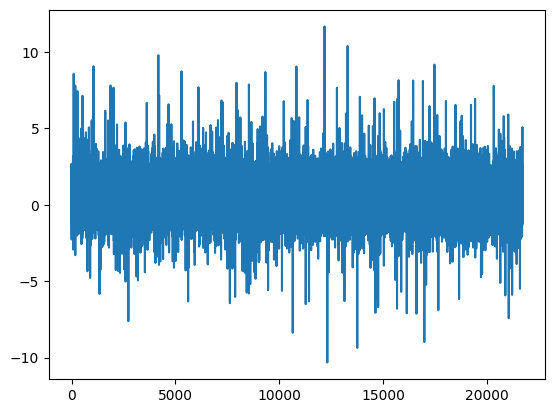

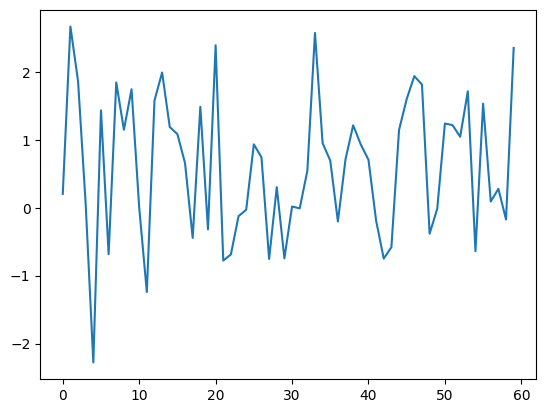

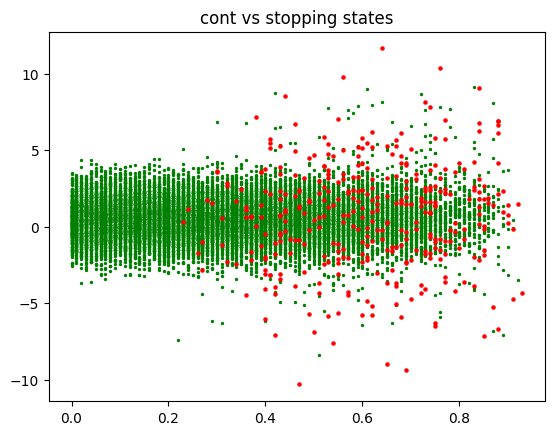

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


 40%|████      | 2/5 [00:55<01:23, 27.76s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 5/5 [02:23<00:00, 28.79s/it]


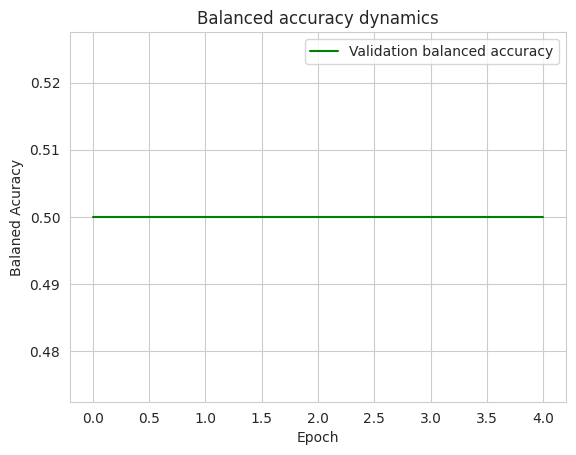

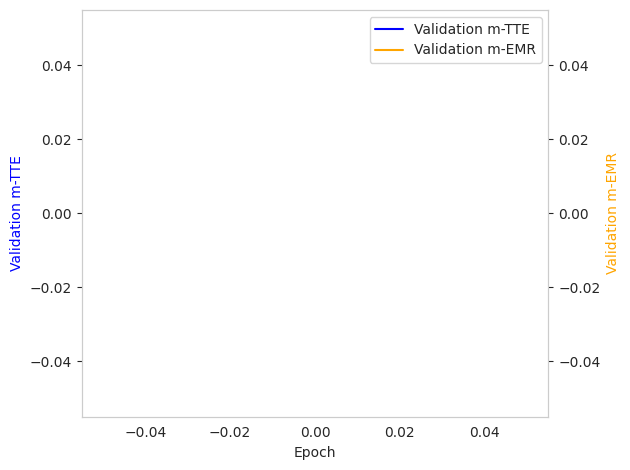

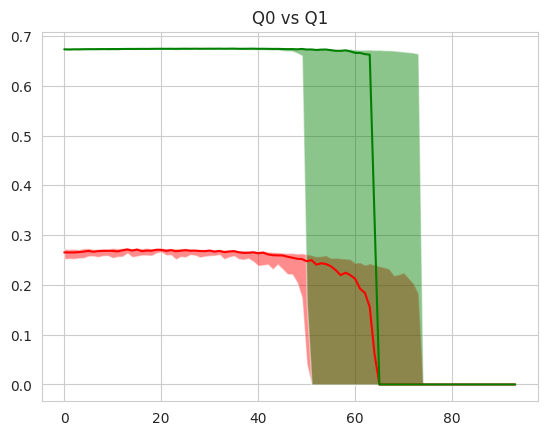

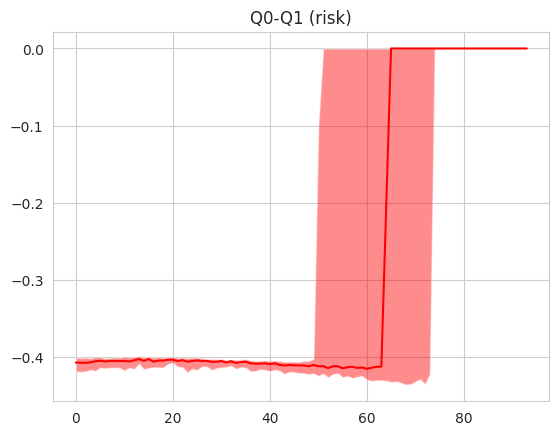

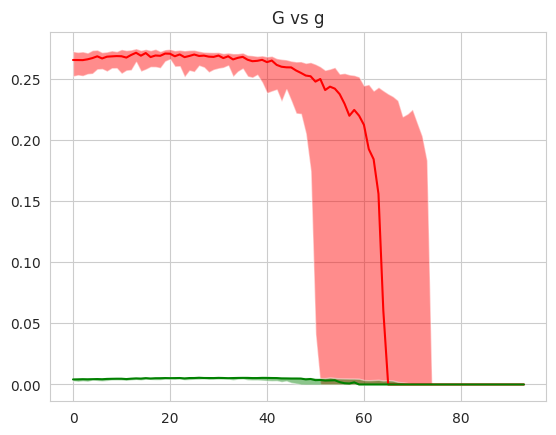

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.01588814744200826
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


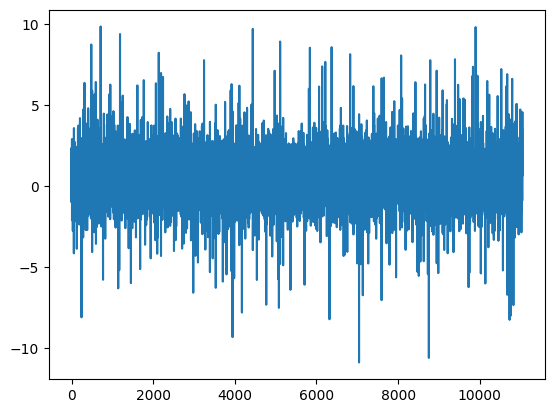

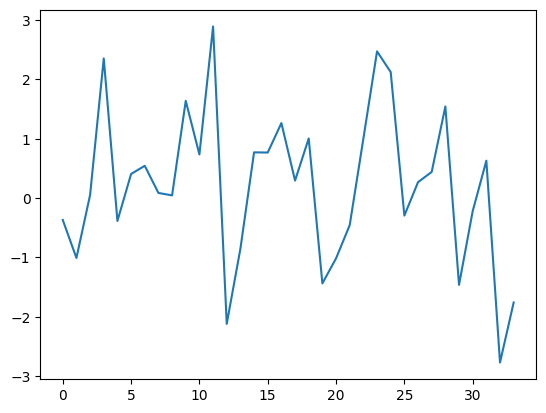

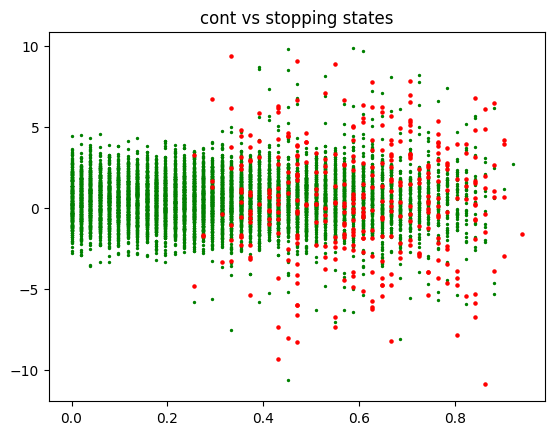

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


 40%|████      | 2/5 [01:32<02:20, 46.99s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.014755018582170615


100%|██████████| 5/5 [04:02<00:00, 48.56s/it]


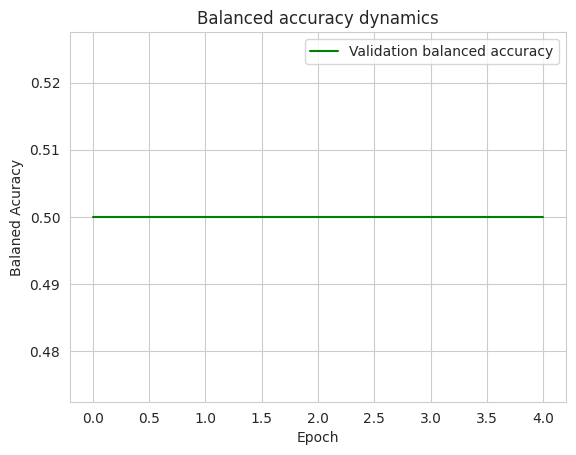

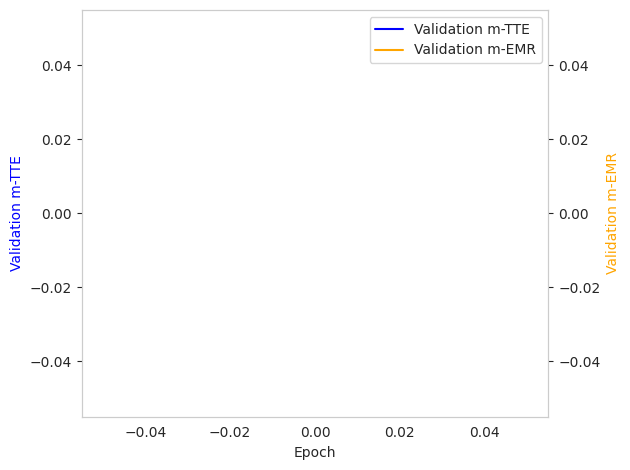

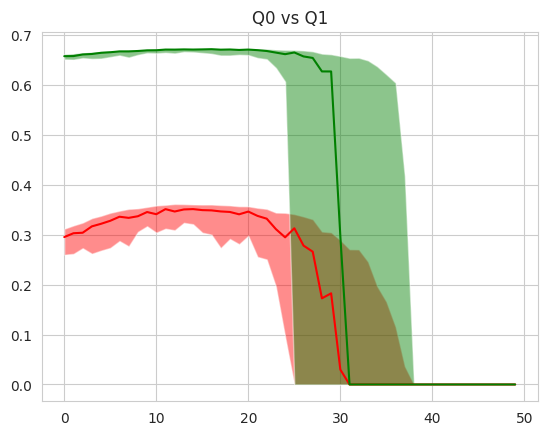

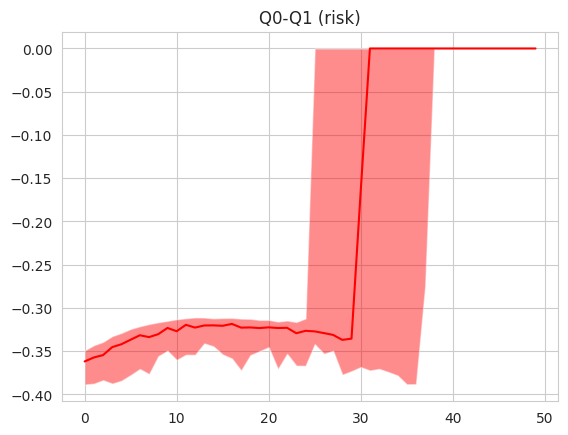

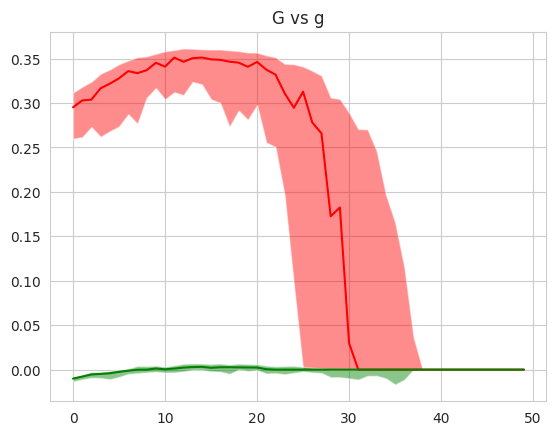

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.031746031746031744
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


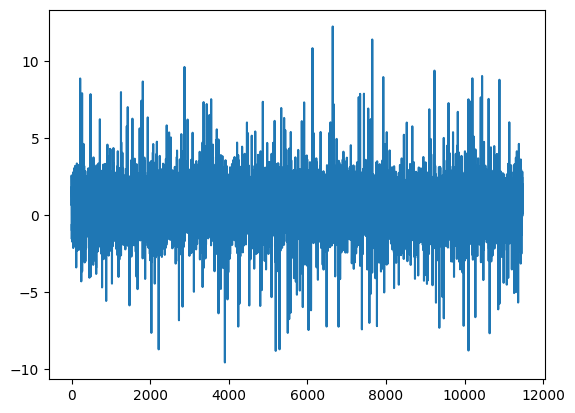

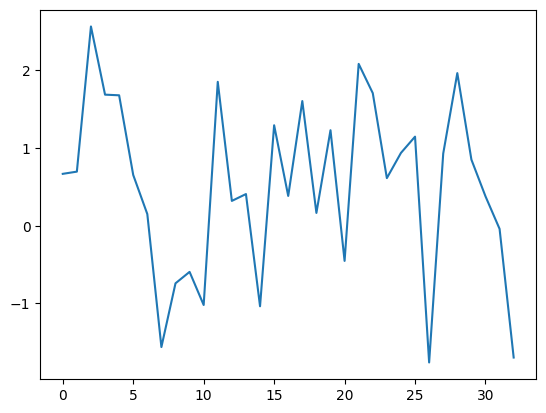

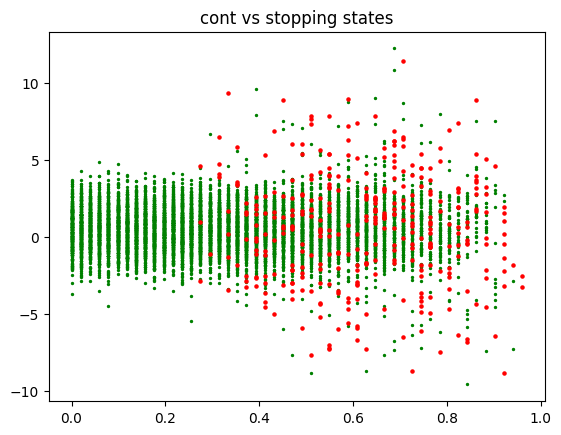

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:01<?, ?it/s]


UnboundLocalError: cannot access local variable 'path_id' where it is not associated with a value

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


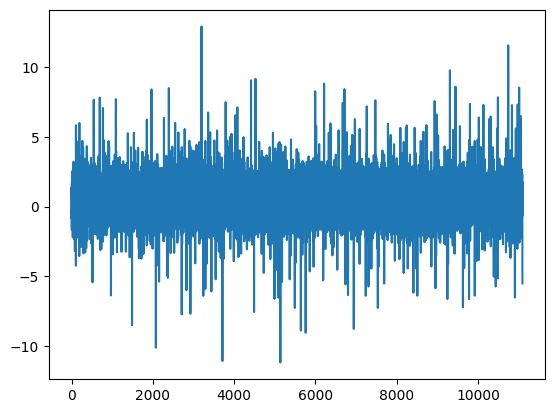

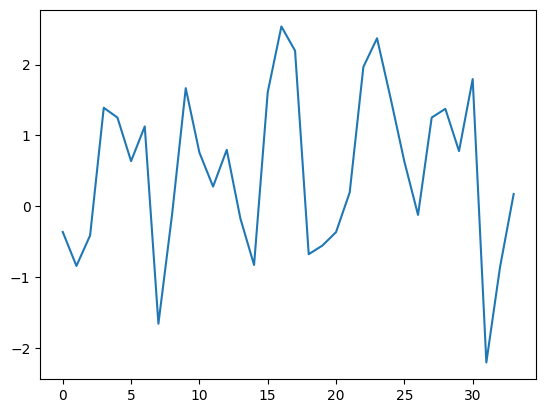

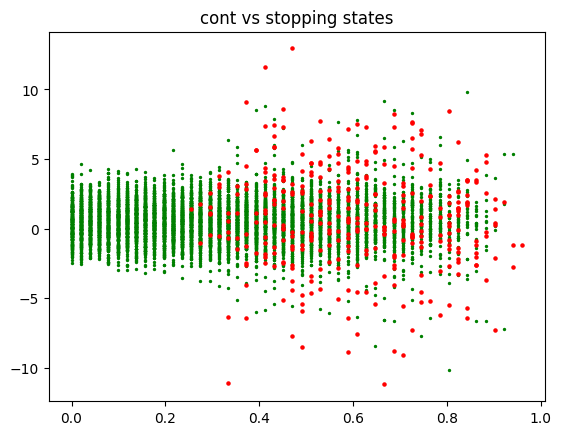

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:01<?, ?it/s]


IndexError: too many indices for tensor of dimension 1

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


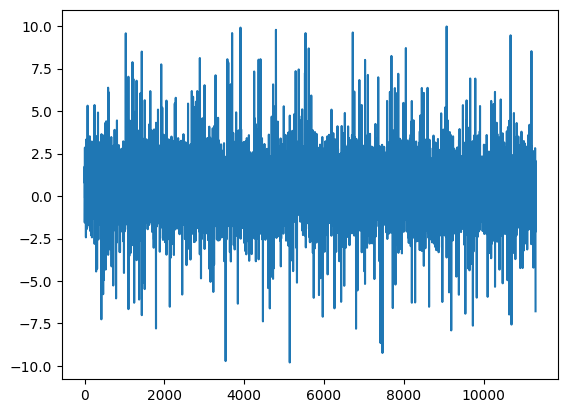

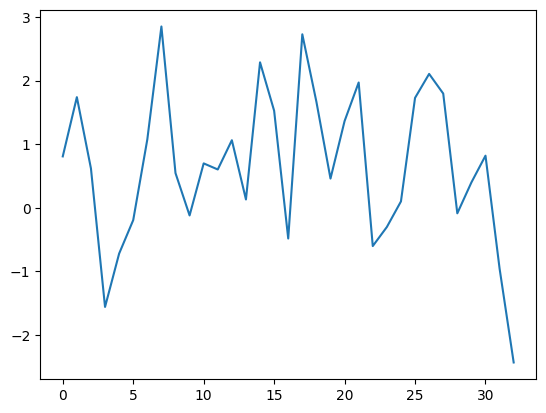

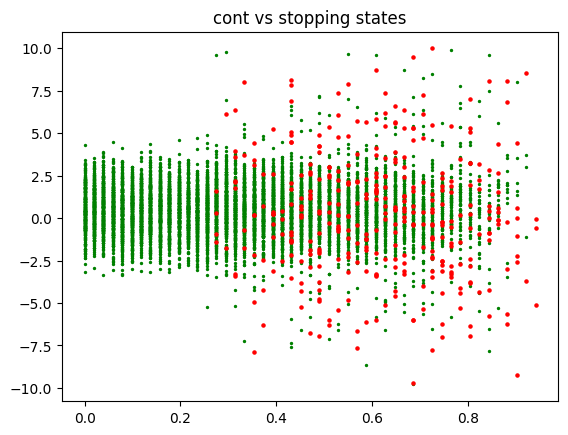

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:01<?, ?it/s]


IndexError: too many indices for tensor of dimension 1

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


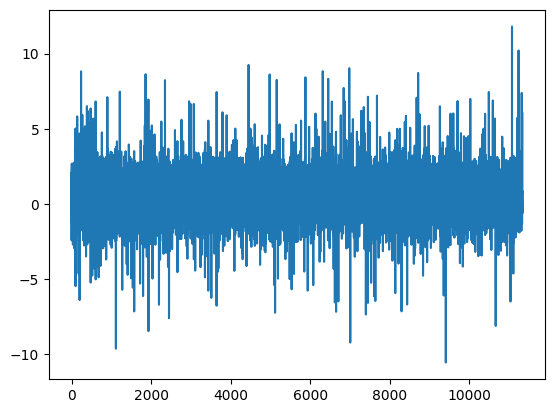

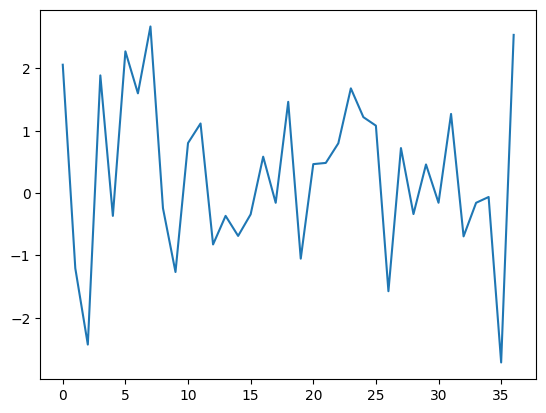

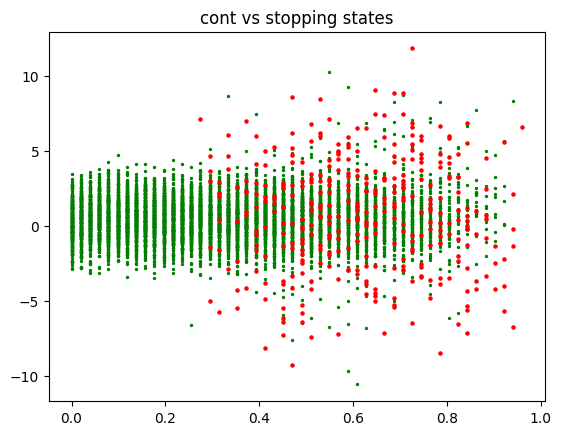

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:02<?, ?it/s]

sample['state_mem'].shape: torch.Size([3361, 2])


RuntimeError: The size of tensor a (2) must match the size of tensor b (3361) at non-singleton dimension 0

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


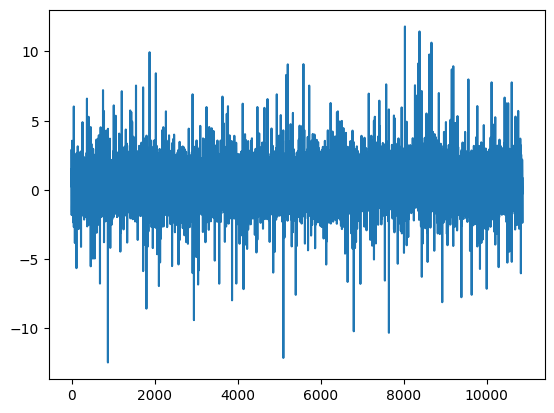

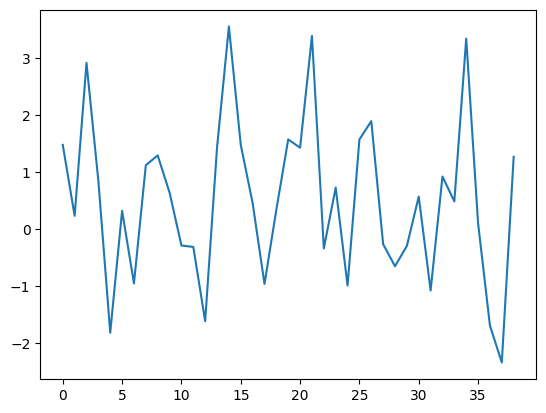

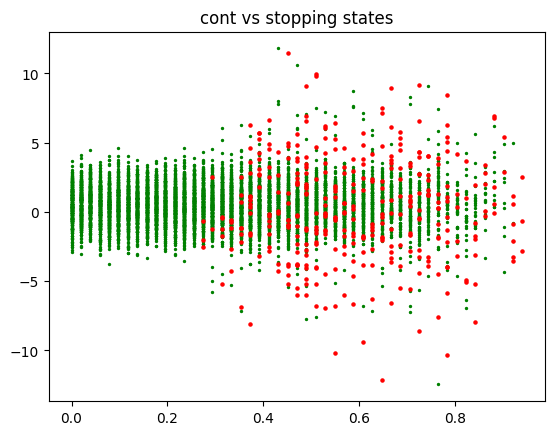

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:02<?, ?it/s]

sample['state_mem'].shape: torch.Size([3337, 2])


AttributeError: 'Tensor' object has no attribute 'rehsape'

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


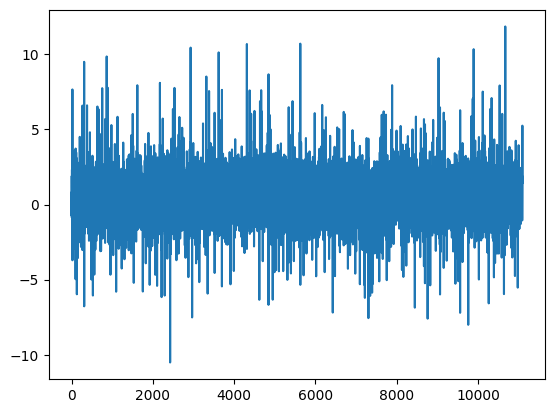

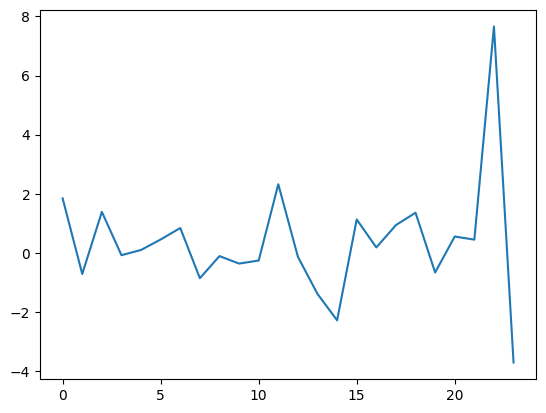

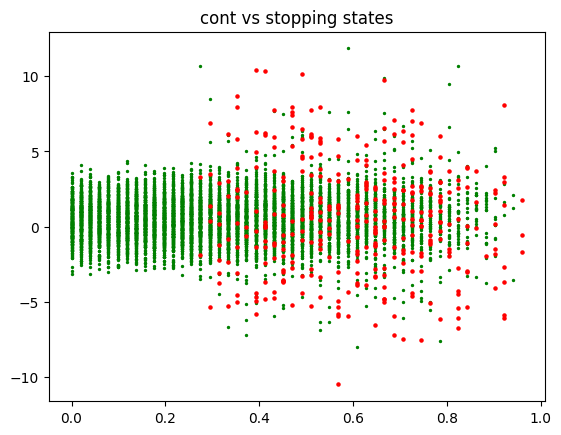

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:01<?, ?it/s]

sample['state_mem'].shape: torch.Size([3458, 2])


RuntimeError: shape '[105, 50]' is invalid for input of size 3458

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

In [ ]:
3458/50

69.16

In [ ]:
3458/51

67.80392156862744

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


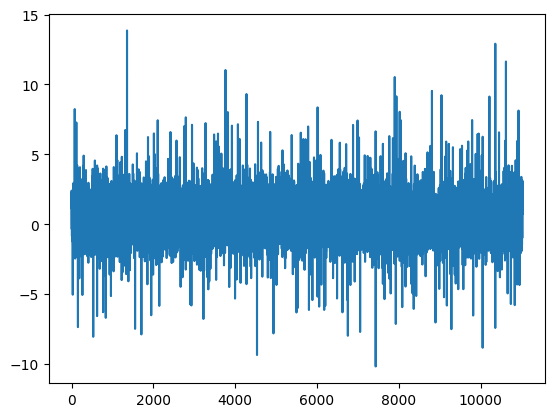

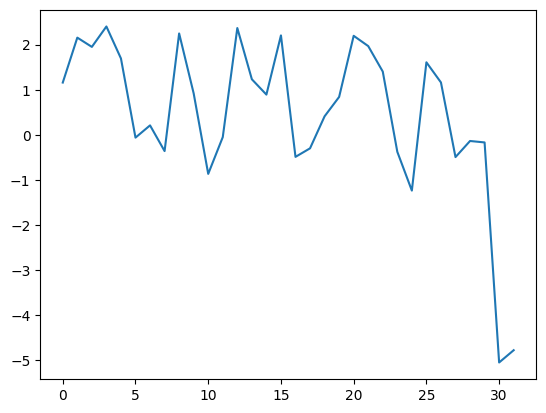

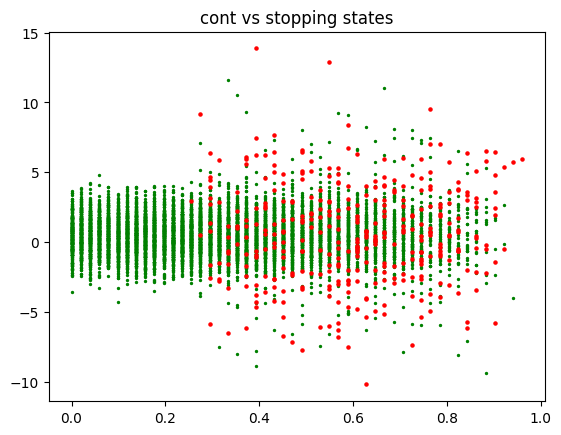

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:01<?, ?it/s]

sample['state_mem'].shape: torch.Size([3265, 2])


ValueError: could not broadcast input array from shape (26,1) into shape (26,)

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


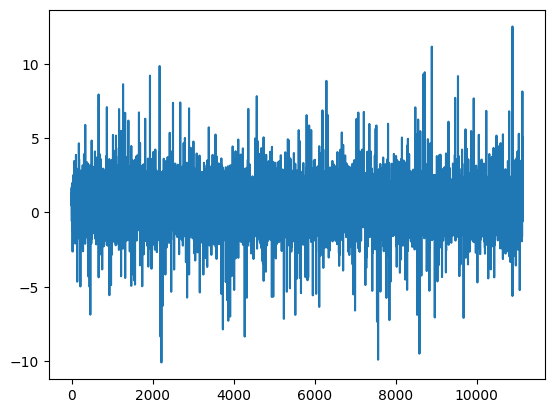

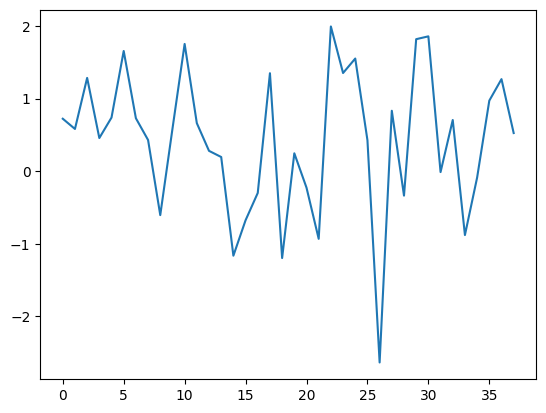

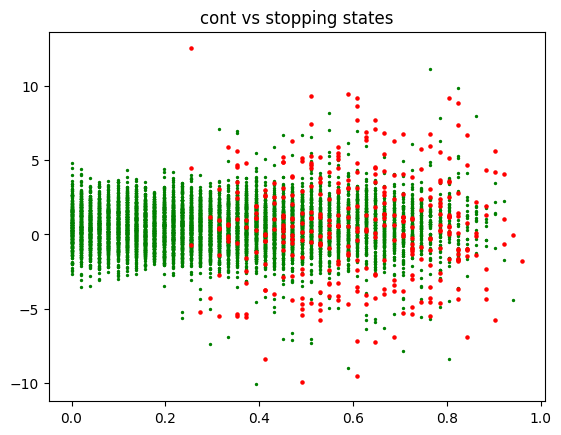

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3323, 2])


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

sample['state_mem'].shape: torch.Size([3323, 2])


 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.002751636052233798
sample['state_mem'].shape: torch.Size([3323, 2])


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

sample['state_mem'].shape: torch.Size([3323, 2])


 80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

sample['state_mem'].shape: torch.Size([3323, 2])


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


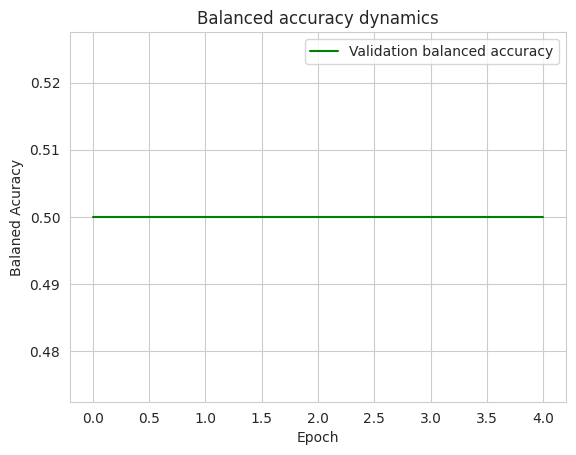

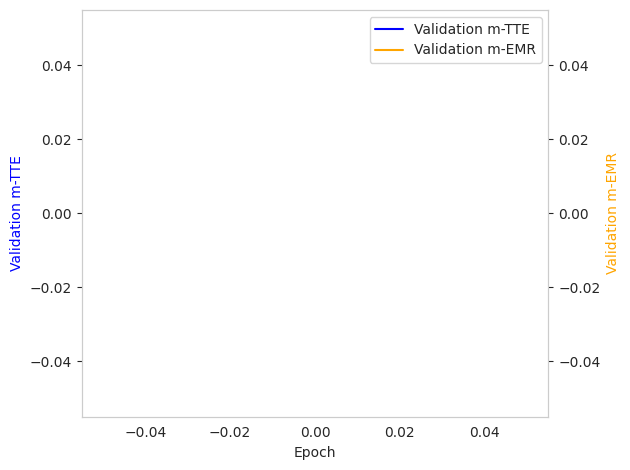

sample['state_mem'].shape: torch.Size([4592, 2])


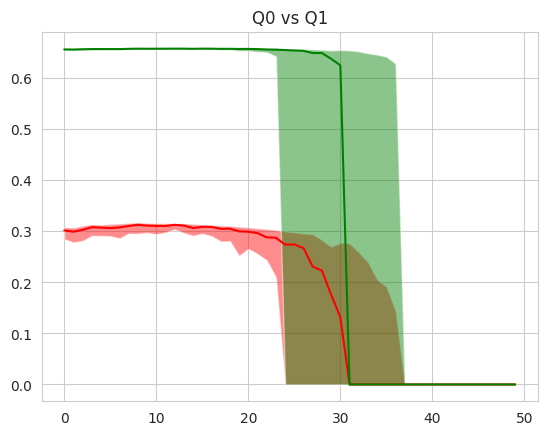

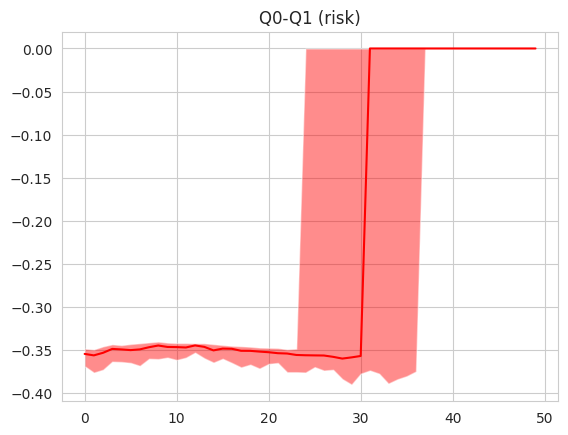

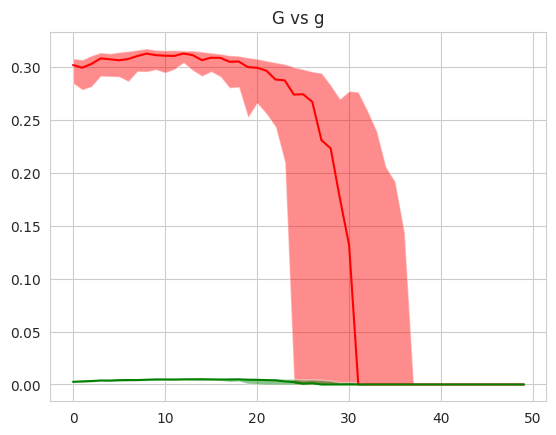

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03266550522648084
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
IQ-Learning + oversampling CS-SMOTE
q_net ON CUDA: False


  0%|          | 0/5 [00:02<?, ?it/s]

sample['state_mem'].shape: torch.Size([3420, 2])


IndexError: The shape of the mask [3420] at index 0 does not match the shape of the indexed tensor [1, 3420] at index 0

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


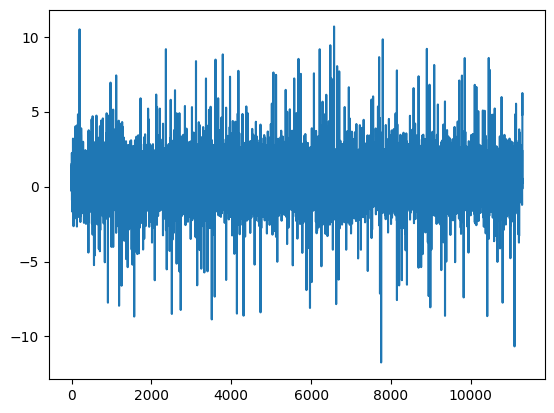

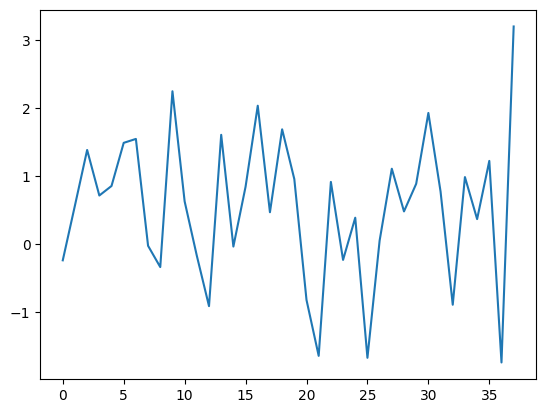

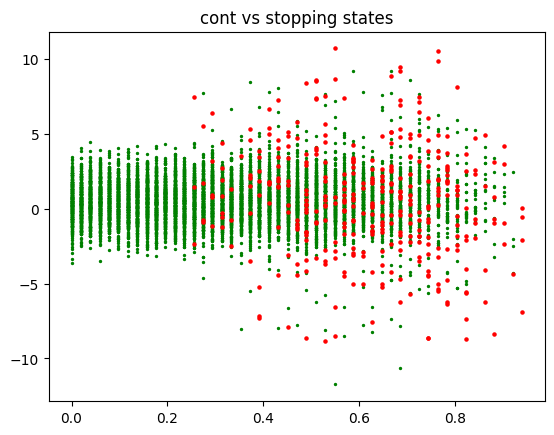

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3179, 2])


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

sample['state_mem'].shape: torch.Size([3179, 2])


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.0018248201938279504
sample['state_mem'].shape: torch.Size([3179, 2])


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

sample['state_mem'].shape: torch.Size([3179, 2])


 80%|████████  | 4/5 [00:12<00:03,  3.35s/it]

sample['state_mem'].shape: torch.Size([3179, 2])


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


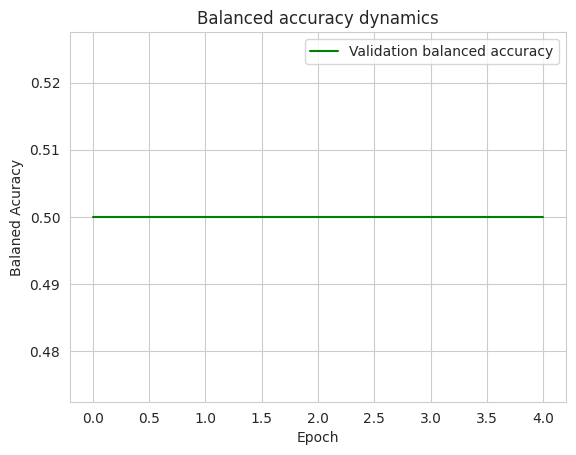

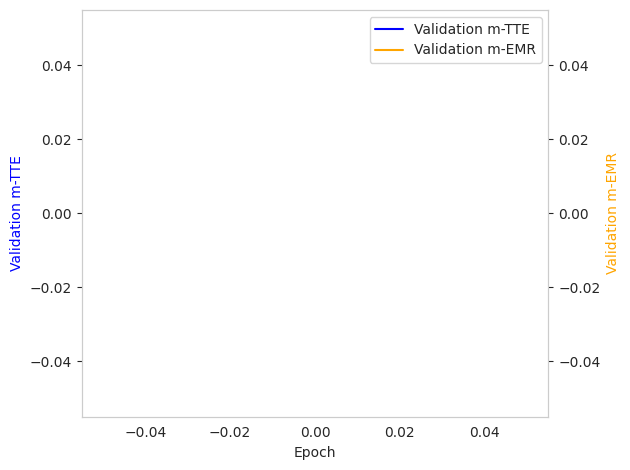

sample['state_mem'].shape: torch.Size([4785, 2])


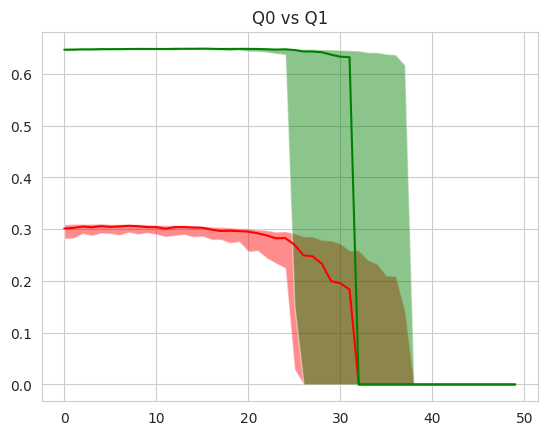

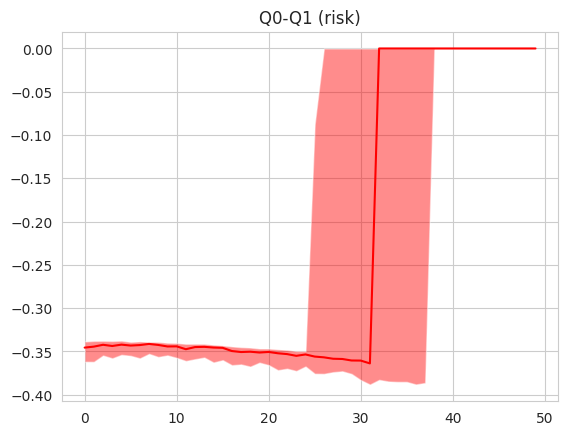

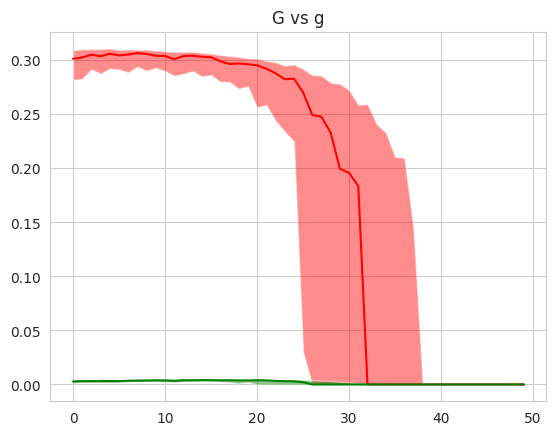

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03134796238244514
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
IQ-Learning + oversampling CS-SMOTE
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3245, 2])


 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

sample['state_mem'].shape: torch.Size([3245, 2])


 40%|████      | 2/5 [00:06<00:09,  3.32s/it]

Saving best model checkpoint with balanced acc: 0.7130421595389749, avg Q-entropy: 0.02587747530390819
sample['state_mem'].shape: torch.Size([3245, 2])


 60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

Saving best model checkpoint with balanced acc: 0.7498635122838945, avg Q-entropy: 0.020731166051700712
sample['state_mem'].shape: torch.Size([3245, 2])


 80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

Saving best model checkpoint with balanced acc: 0.7587048832271762, avg Q-entropy: 0.018147769283192852
sample['state_mem'].shape: torch.Size([3245, 2])


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

Saving best model checkpoint with balanced acc: 0.7853503184713376, avg Q-entropy: 0.01688594480510801


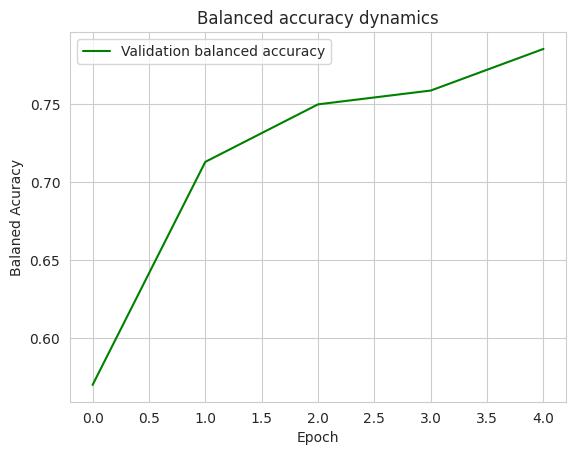

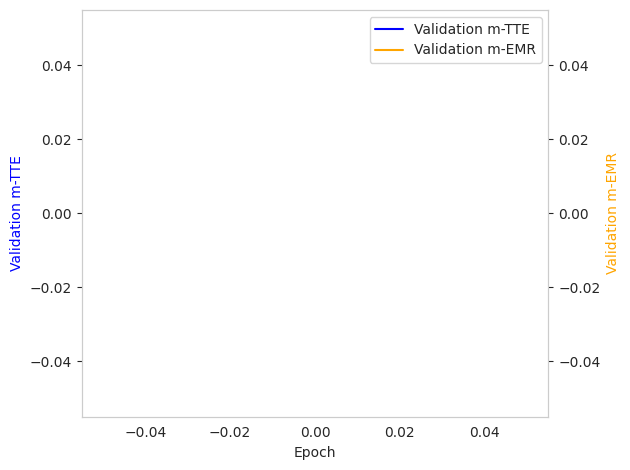

sample['state_mem'].shape: torch.Size([4785, 2])


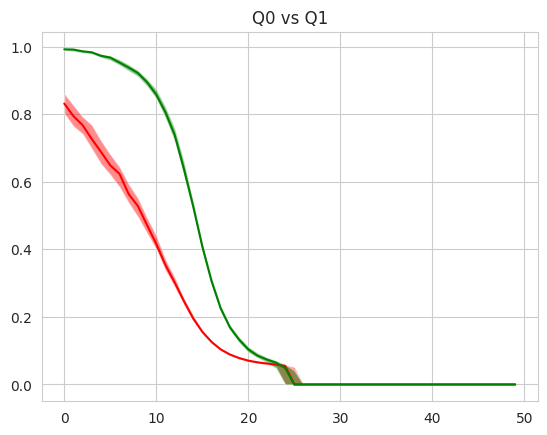

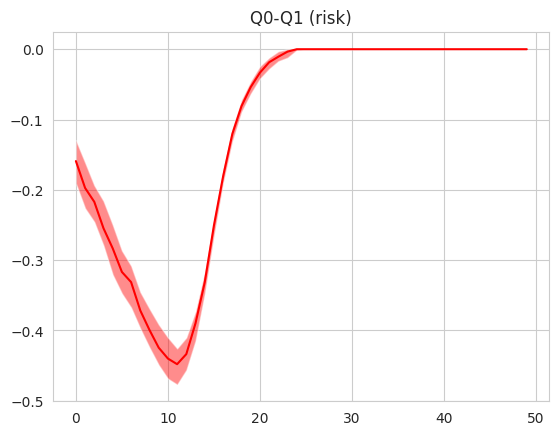

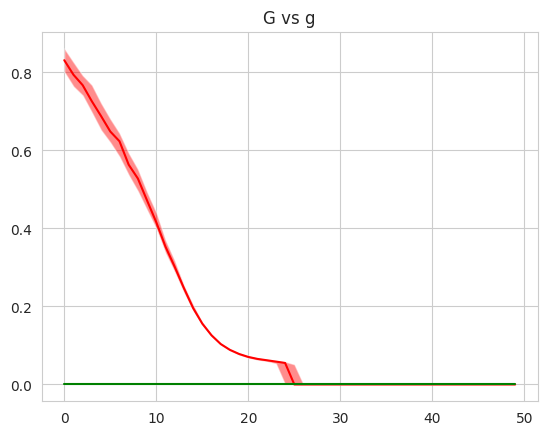

Balance Accuracy Score: 0.7660517799352751
F1: 0.1652542372881356
pr_auc: 0.07898185978100997
median time-to-event: 9.820512820512821
median event miss-rate: 0.22
number of missed events: 33
Approximating P, no oversampling
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3309, 2])


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

sample['state_mem'].shape: torch.Size([3309, 2])


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.0024333367360785843
sample['state_mem'].shape: torch.Size([3309, 2])


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

sample['state_mem'].shape: torch.Size([3309, 2])


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

sample['state_mem'].shape: torch.Size([3309, 2])


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


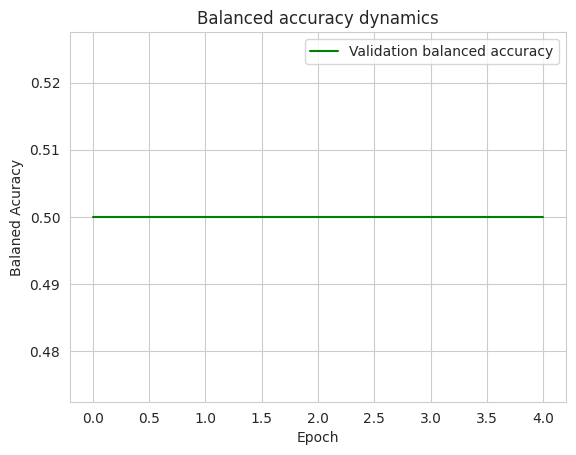

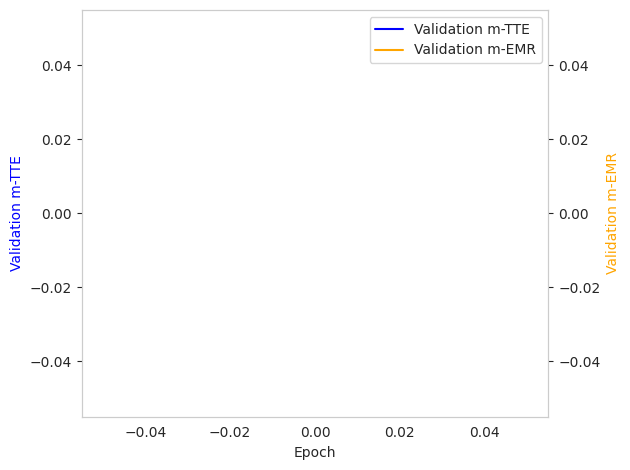

sample['state_mem'].shape: torch.Size([4785, 2])


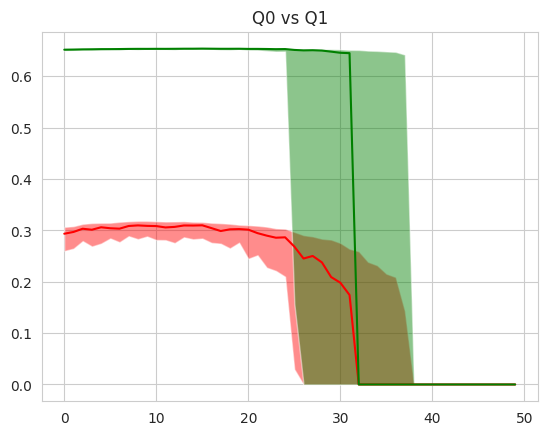

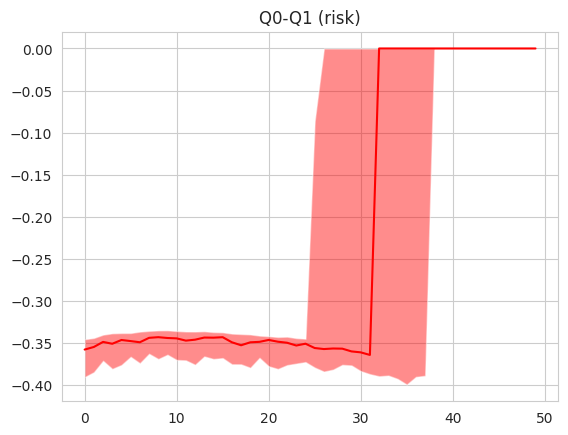

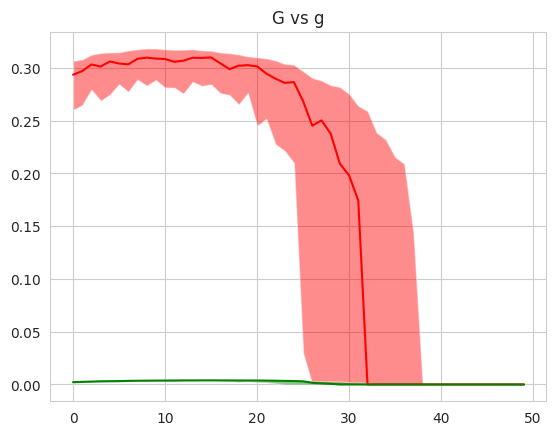

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03134796238244514
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
Approximating P, no oversampling
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3425, 2])


 20%|██        | 1/5 [00:04<00:18,  4.57s/it]

sample['state_mem'].shape: torch.Size([3425, 2])


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

Saving best model checkpoint with balanced acc: 0.5043100975329892, avg Q-entropy: 0.02729723697192356
sample['state_mem'].shape: torch.Size([3425, 2])


 60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

sample['state_mem'].shape: torch.Size([3425, 2])


 80%|████████  | 4/5 [00:13<00:03,  3.13s/it]

sample['state_mem'].shape: torch.Size([3425, 2])


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


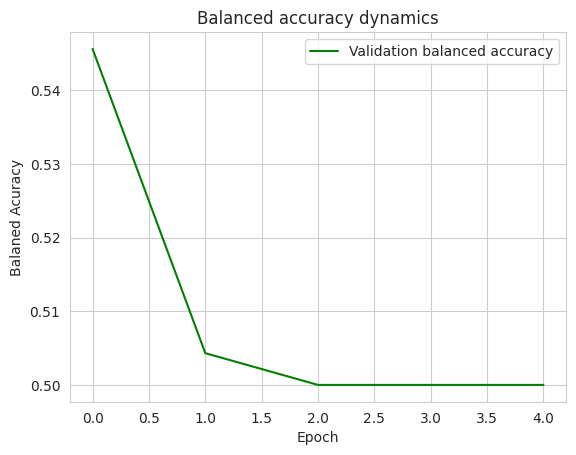

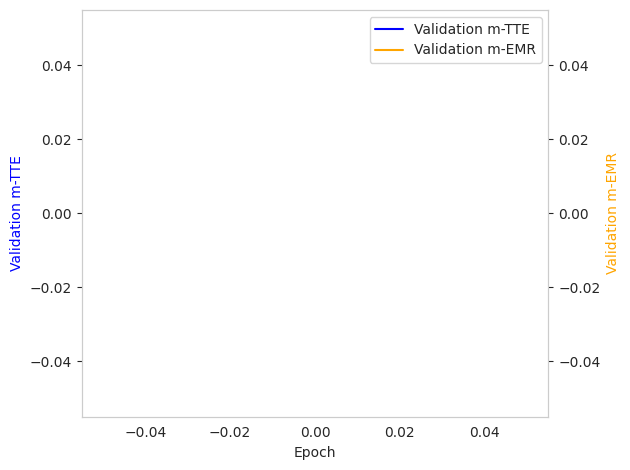

sample['state_mem'].shape: torch.Size([4785, 2])


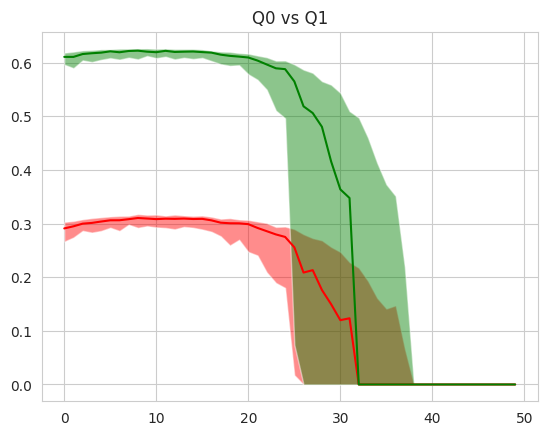

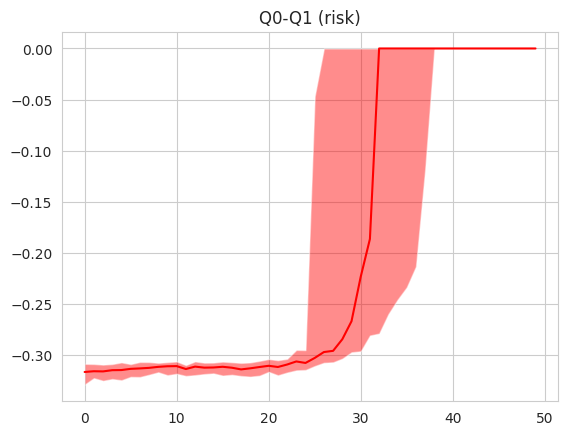

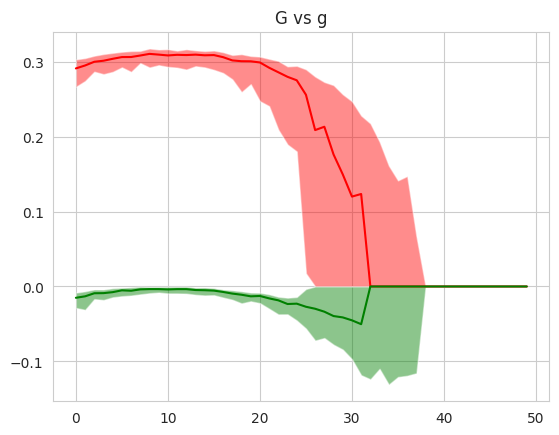

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03134796238244514
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3356, 2])


 20%|██        | 1/5 [00:04<00:18,  4.66s/it]

sample['state_mem'].shape: torch.Size([3356, 2])


 40%|████      | 2/5 [00:09<00:13,  4.64s/it]

Saving best model checkpoint with balanced acc: 0.7479925590660749, avg Q-entropy: 0.013988447651835316
sample['state_mem'].shape: torch.Size([3356, 2])


 60%|██████    | 3/5 [00:16<00:11,  5.63s/it]

Saving best model checkpoint with balanced acc: 0.752109973488011, avg Q-entropy: 0.011727019970826173
sample['state_mem'].shape: torch.Size([3356, 2])


 80%|████████  | 4/5 [00:20<00:05,  5.30s/it]

Saving best model checkpoint with balanced acc: 0.7525772289844883, avg Q-entropy: 0.01036569079920902
sample['state_mem'].shape: torch.Size([3356, 2])


100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


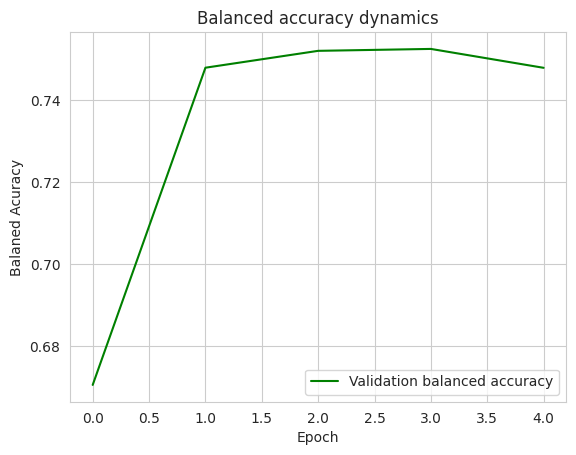

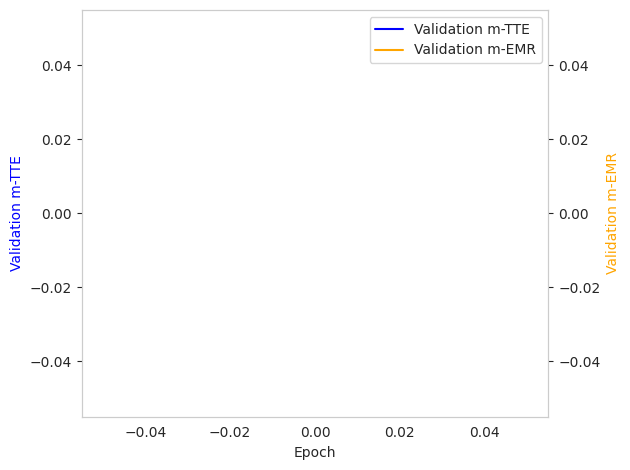

sample['state_mem'].shape: torch.Size([4785, 2])


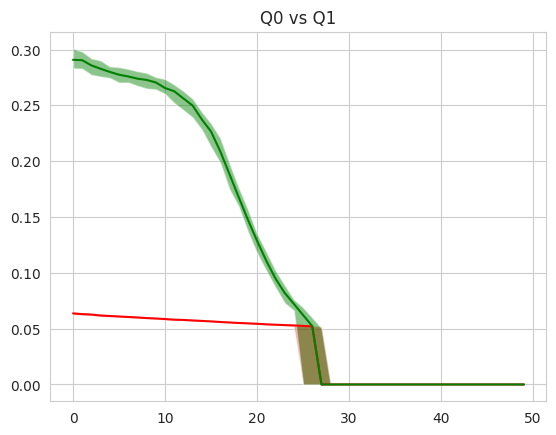

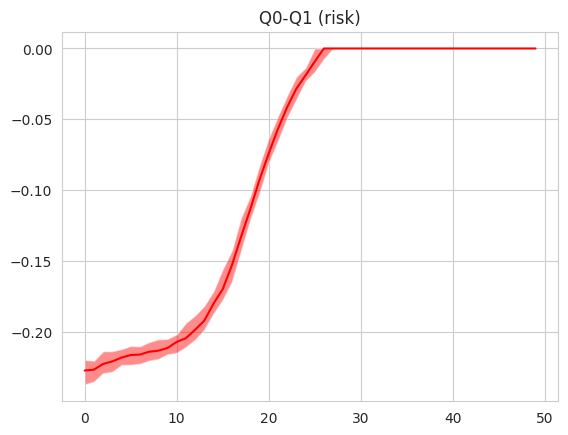

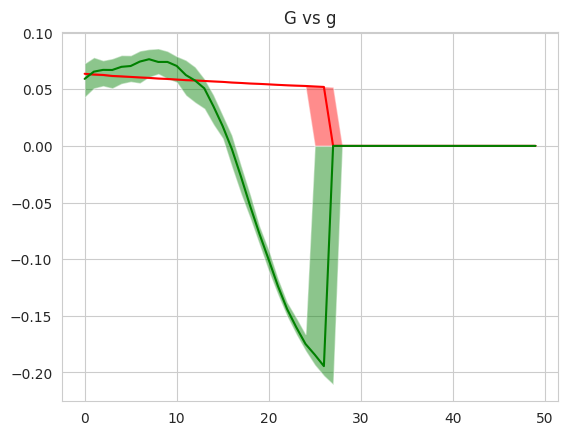

Balance Accuracy Score: 0.7218554476806904
F1: 0.17216117216117216
pr_auc: 0.07423685570841293
median time-to-event: 9.02127659574468
median event miss-rate: 0.37333333333333335
number of missed events: 56
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]

sample['state_mem'].shape: torch.Size([3307, 2])


 20%|██        | 1/5 [00:04<00:19,  4.86s/it]

sample['state_mem'].shape: torch.Size([3307, 2])


 40%|████      | 2/5 [00:10<00:15,  5.13s/it]

Saving best model checkpoint with balanced acc: 0.7043618571726005, avg Q-entropy: 0.015682753253759455
sample['state_mem'].shape: torch.Size([3307, 2])


 60%|██████    | 3/5 [00:14<00:09,  4.92s/it]

sample['state_mem'].shape: torch.Size([3307, 2])


 80%|████████  | 4/5 [00:19<00:04,  4.69s/it]

Saving best model checkpoint with balanced acc: 0.7417506915320782, avg Q-entropy: 0.010334320695084684
sample['state_mem'].shape: torch.Size([3307, 2])


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


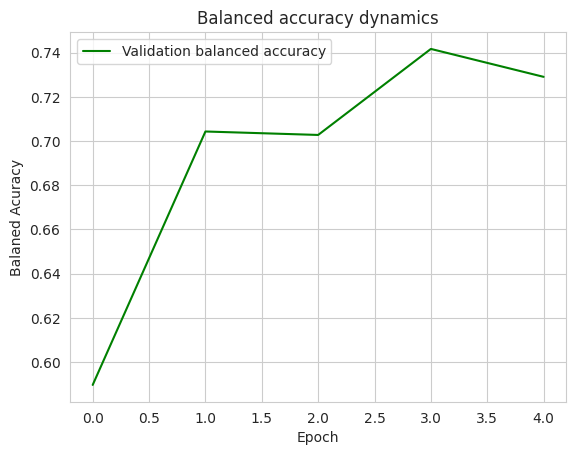

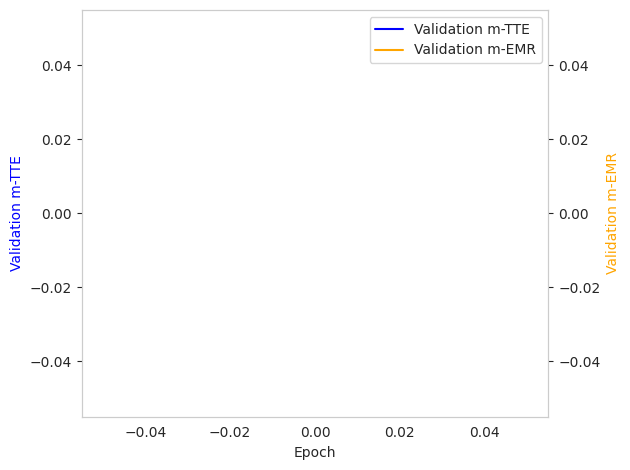

sample['state_mem'].shape: torch.Size([4785, 2])


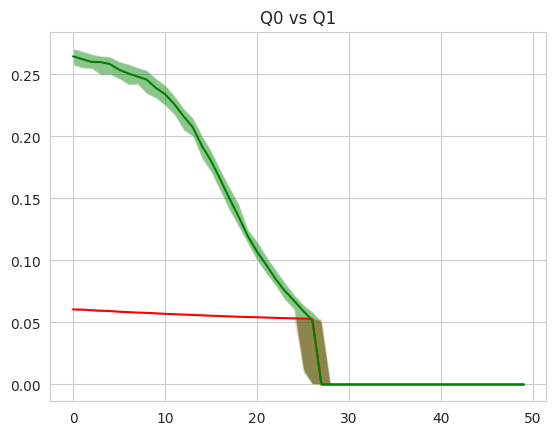

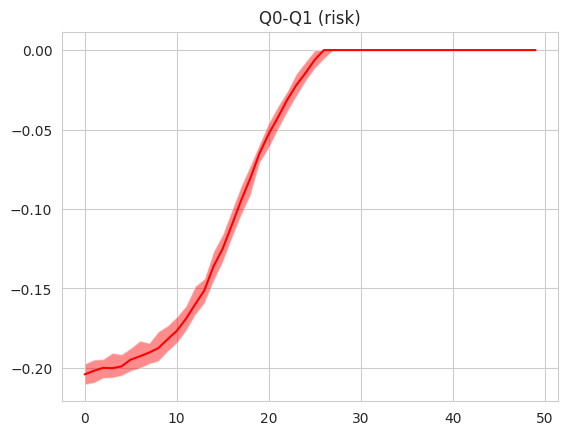

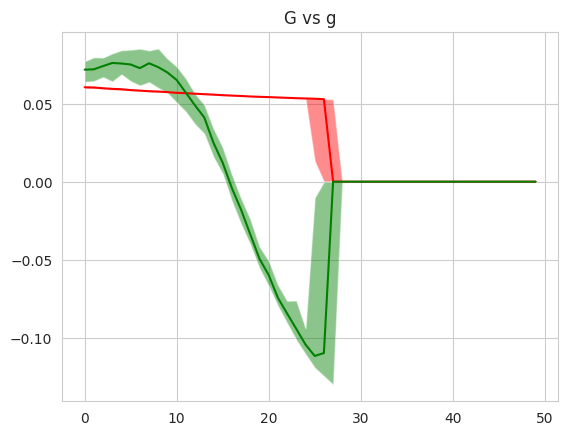

Balance Accuracy Score: 0.7264724919093851
F1: 0.1725067385444744
pr_auc: 0.07508588951063974
median time-to-event: 9.03125
median event miss-rate: 0.36
number of missed events: 54
Approximating g and P, no oversampling
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'tuple' and 'Tensor'

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'tuple' and 'Tensor'

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


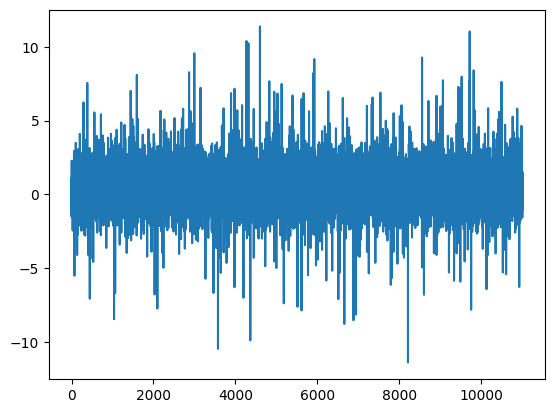

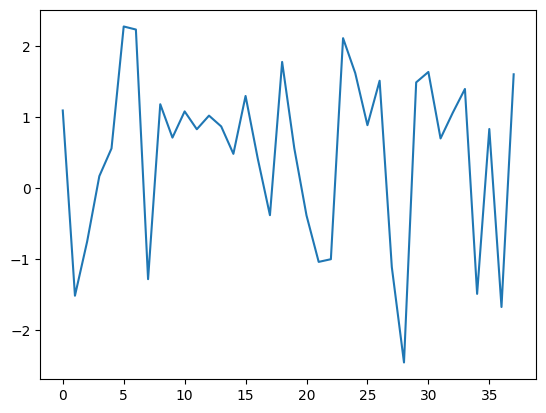

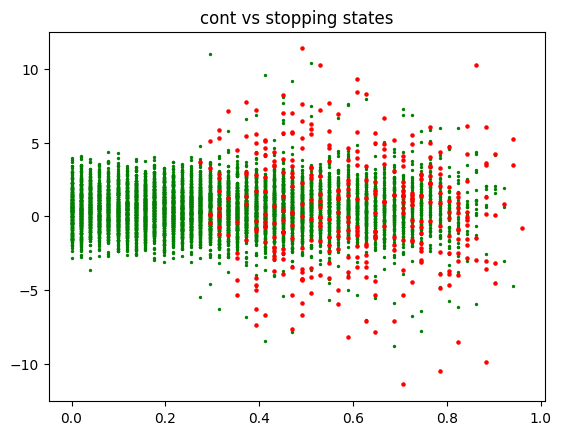

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


 40%|████      | 2/5 [00:56<01:23, 27.78s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 5/5 [02:32<00:00, 30.57s/it]


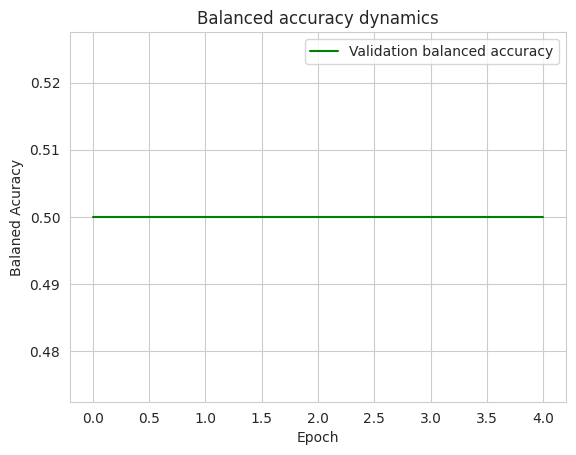

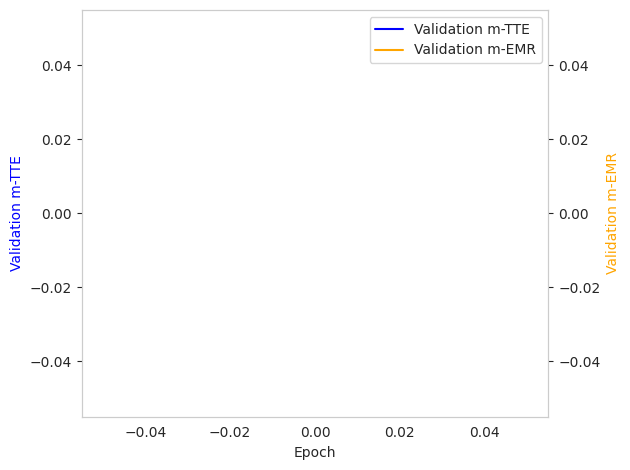

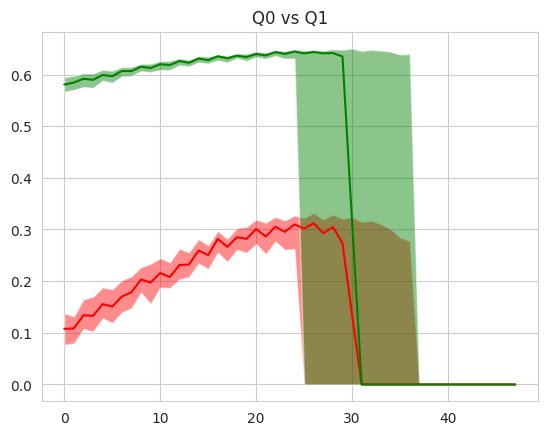

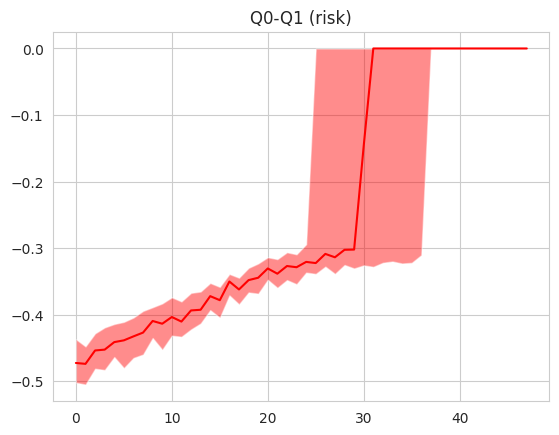

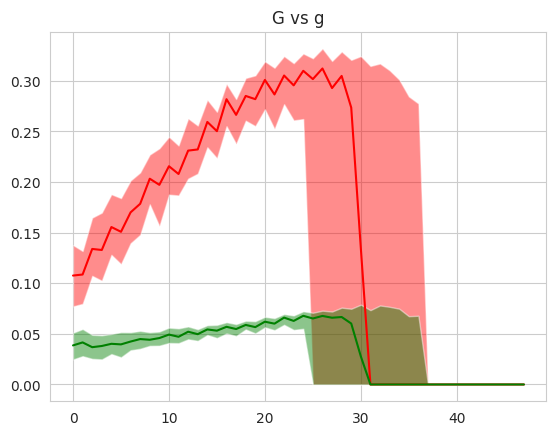

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03207184092366902
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
IQ-Learning + oversampling CS-SMOTE
q_net ON CUDA: False


 40%|████      | 2/5 [00:05<00:08,  2.92s/it]

Saving best model checkpoint with balanced acc: 0.593364122148704, avg Q-entropy: nan


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

Saving best model checkpoint with balanced acc: 0.7189602853886348, avg Q-entropy: nan


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

Saving best model checkpoint with balanced acc: 0.7658125730864307, avg Q-entropy: nan


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


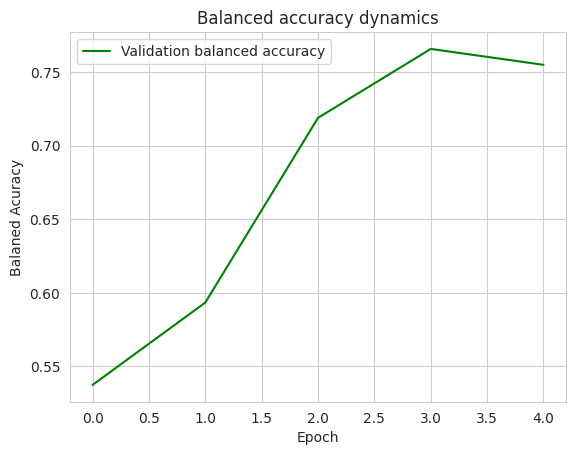

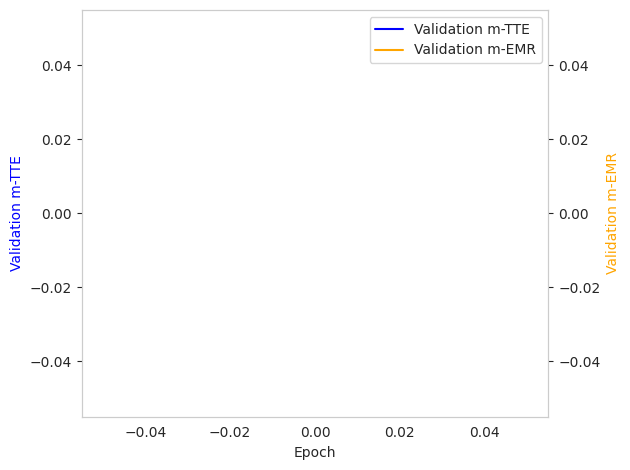

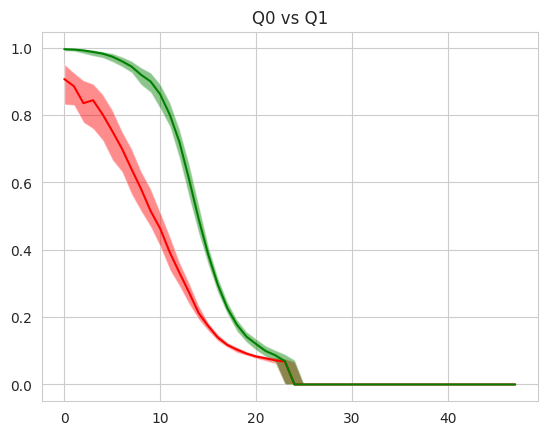

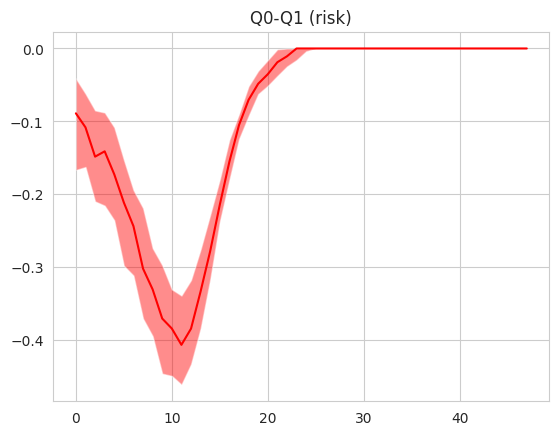

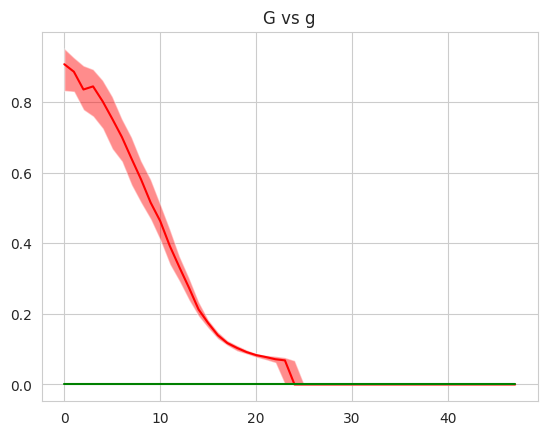

Balance Accuracy Score: 0.7423613872321626
F1: 0.15280594996619337
pr_auc: 0.07196422690614285
median time-to-event: 10.761061946902656
median event miss-rate: 0.24666666666666667
number of missed events: 37
Approximating P, no oversampling
q_net ON CUDA: False


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


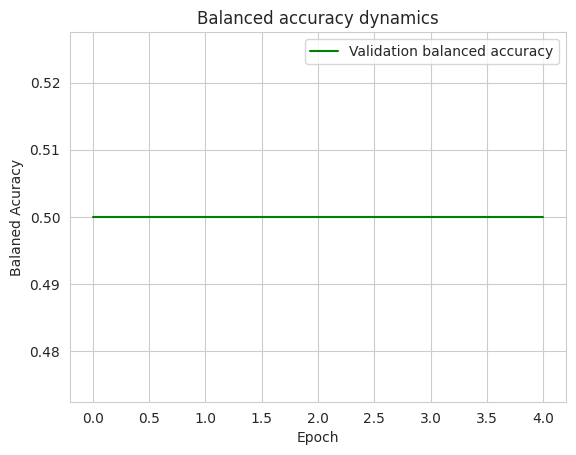

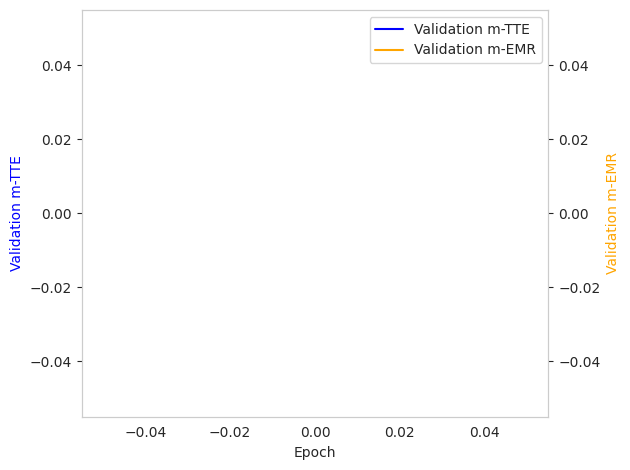

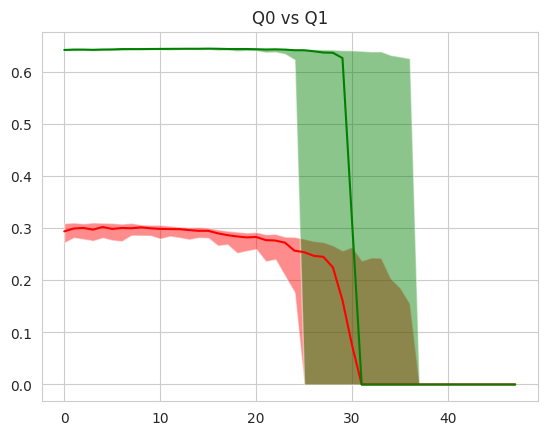

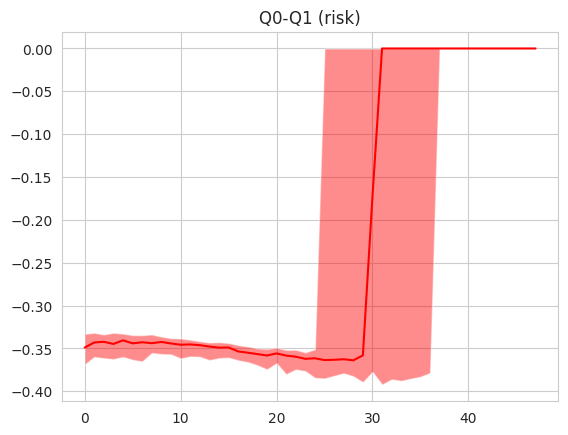

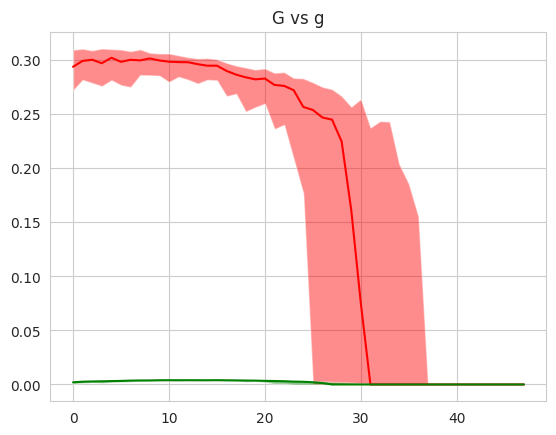

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03207184092366902
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
Approximating P, no oversampling
q_net ON CUDA: False


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


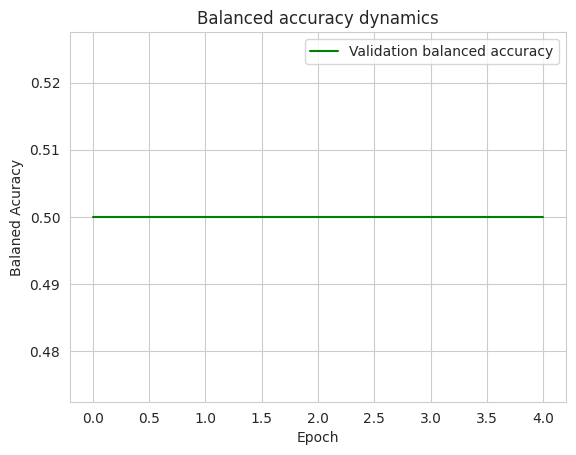

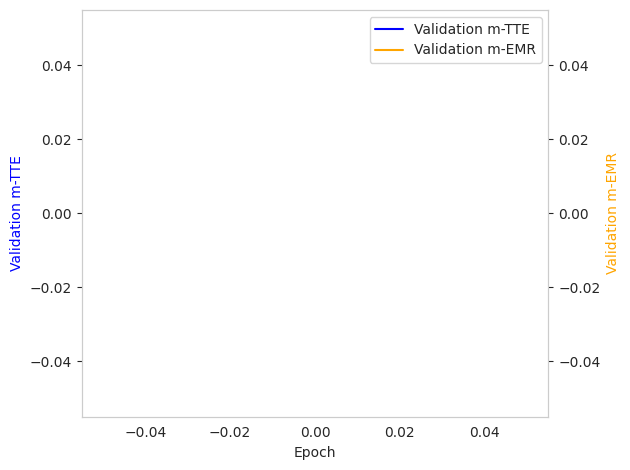

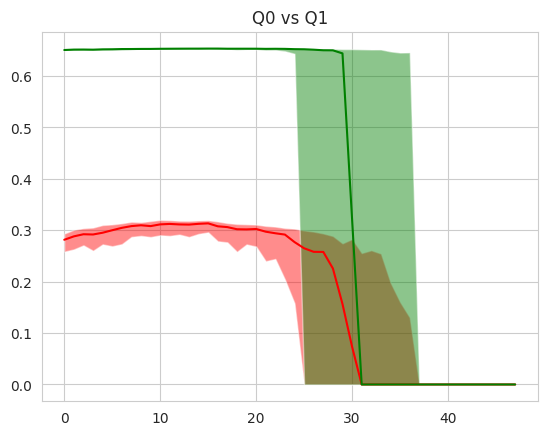

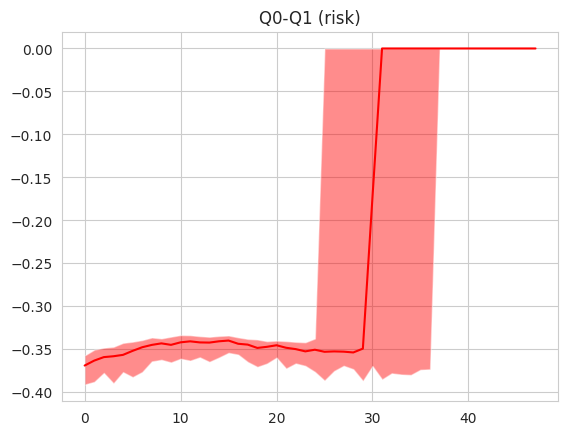

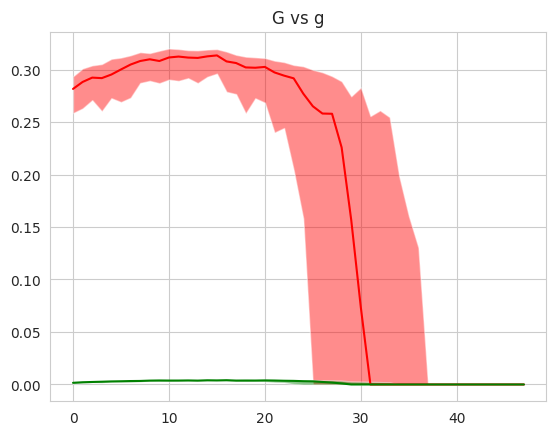

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03207184092366902
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


 40%|████      | 2/5 [00:08<00:12,  4.31s/it]

Saving best model checkpoint with balanced acc: 0.6953551289650874, avg Q-entropy: nan


 80%|████████  | 4/5 [00:17<00:04,  4.38s/it]

Saving best model checkpoint with balanced acc: 0.7158953080114906, avg Q-entropy: nan


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


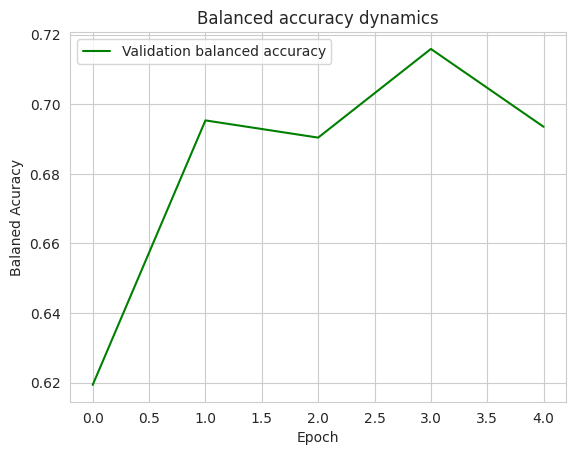

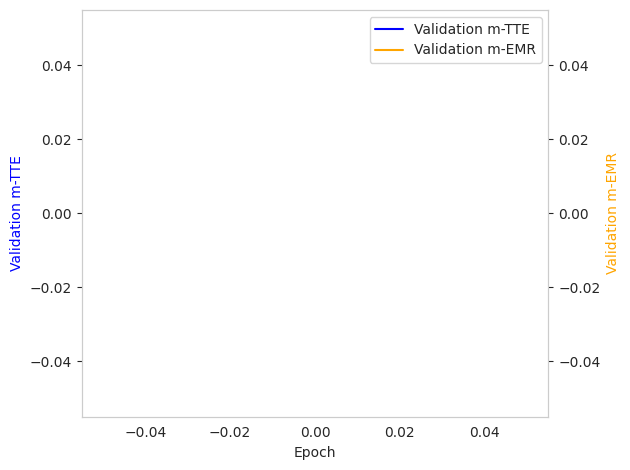

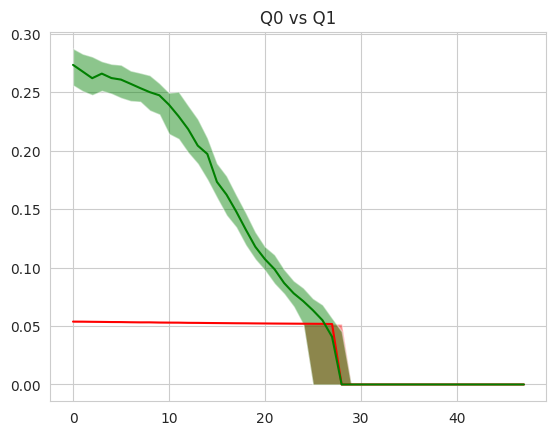

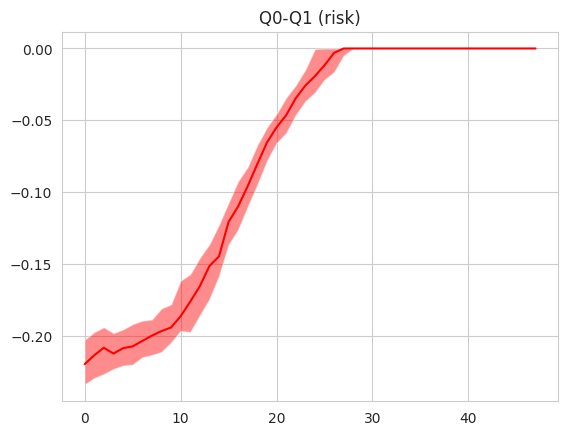

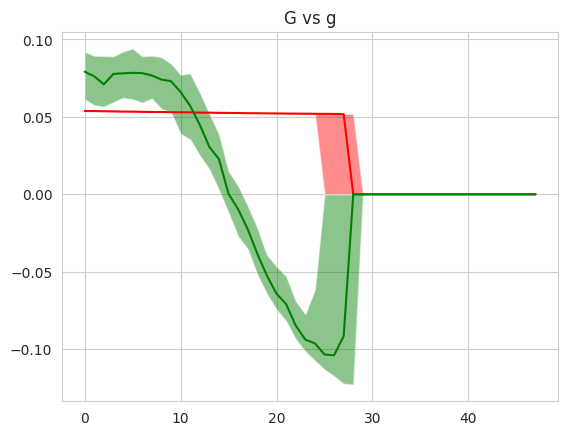

Balance Accuracy Score: 0.7228164347249835
F1: 0.18762886597938144
pr_auc: 0.07994012734867567
median time-to-event: 8.010989010989011
median event miss-rate: 0.3933333333333333
number of missed events: 59
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


 40%|████      | 2/5 [00:08<00:12,  4.11s/it]

Saving best model checkpoint with balanced acc: 0.6967420909281374, avg Q-entropy: nan


 80%|████████  | 4/5 [00:16<00:04,  4.09s/it]

Saving best model checkpoint with balanced acc: 0.7046810930531862, avg Q-entropy: nan


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]

Saving best model checkpoint with balanced acc: 0.7369010206219508, avg Q-entropy: nan


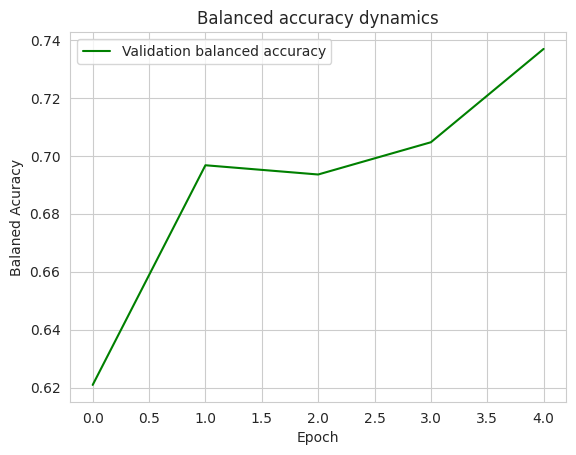

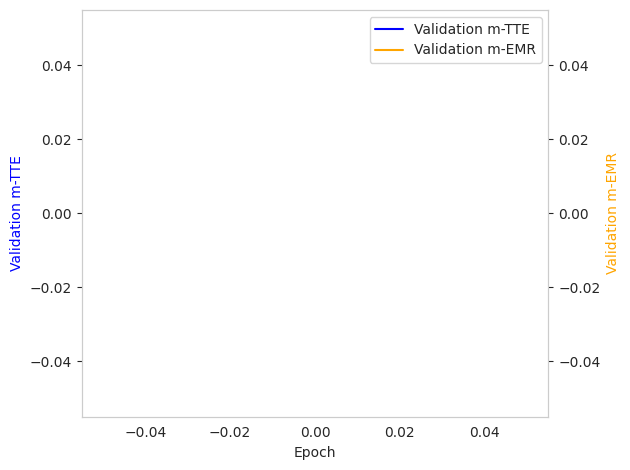

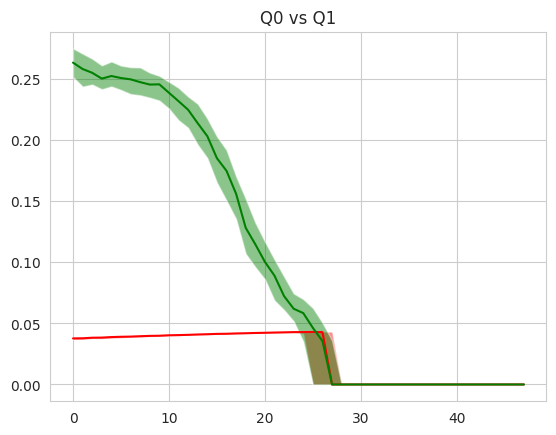

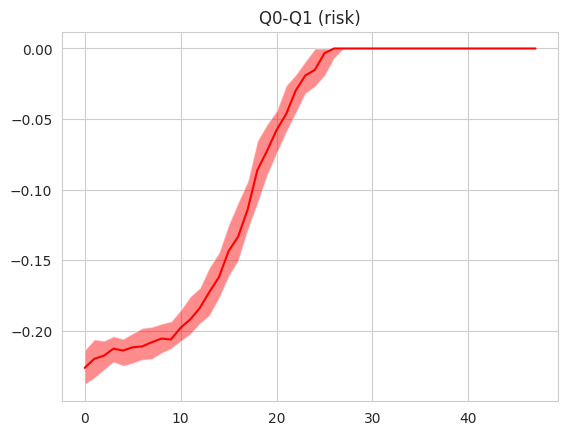

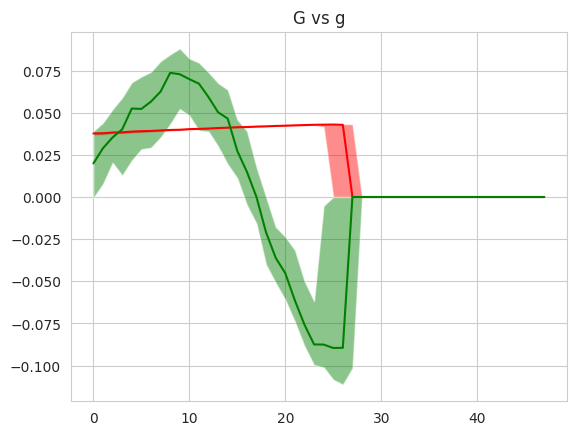

Balance Accuracy Score: 0.7326551800309256
F1: 0.18164794007490637
pr_auc: 0.07966175271096726
median time-to-event: 8.463917525773196
median event miss-rate: 0.35333333333333333
number of missed events: 53
Approximating g and P, no oversampling
g_net ON CUDA: False
q_net ON CUDA: False


 40%|████      | 2/5 [01:08<01:45, 35.08s/it]

Saving best model checkpoint with balanced acc: 0.5632205513784462, avg Q-entropy: nan


 80%|████████  | 4/5 [02:09<00:31, 31.89s/it]

Saving best model checkpoint with balanced acc: 0.6048558897243108, avg Q-entropy: nan


100%|██████████| 5/5 [02:39<00:00, 31.95s/it]


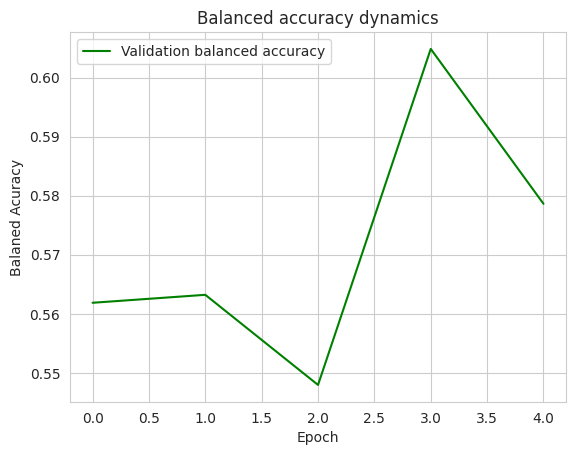

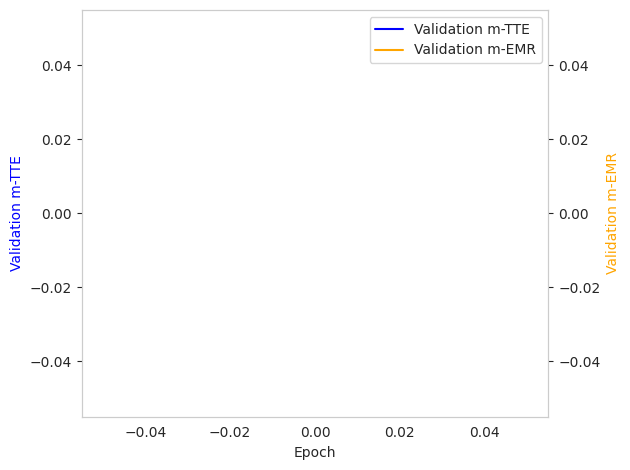

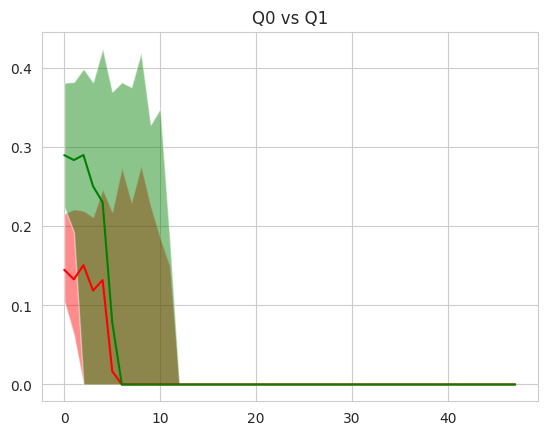

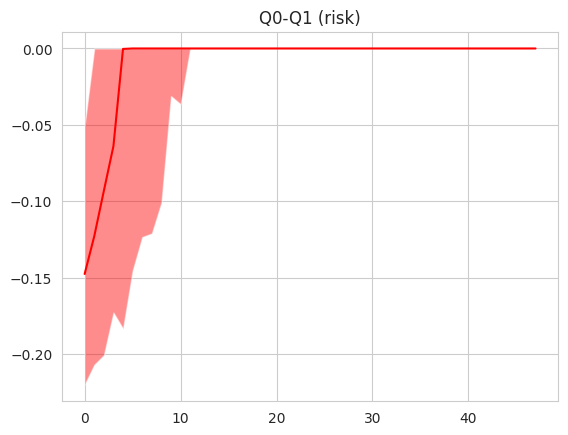

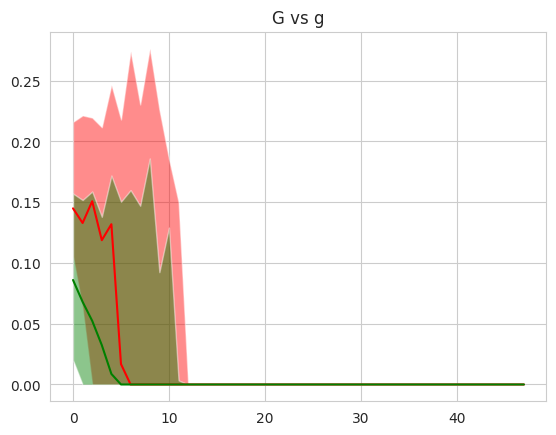

Balance Accuracy Score: 0.5921161917384581
F1: 0.07616438356164383
pr_auc: 0.039153839762973826
median time-to-event: 24.179856115107913
median event miss-rate: 0.07333333333333333
number of missed events: 11
Approximating g and P, no oversampling
g_net ON CUDA: False
q_net ON CUDA: False


 40%|████      | 2/5 [00:56<01:24, 28.09s/it]

Saving best model checkpoint with balanced acc: 0.5399920964236317, avg Q-entropy: nan


 60%|██████    | 3/5 [01:22<00:54, 27.44s/it]

Saving best model checkpoint with balanced acc: 0.5609069353882632, avg Q-entropy: nan


 80%|████████  | 4/5 [01:51<00:27, 27.83s/it]

Saving best model checkpoint with balanced acc: 0.5758842126062043, avg Q-entropy: nan


100%|██████████| 5/5 [02:20<00:00, 28.16s/it]


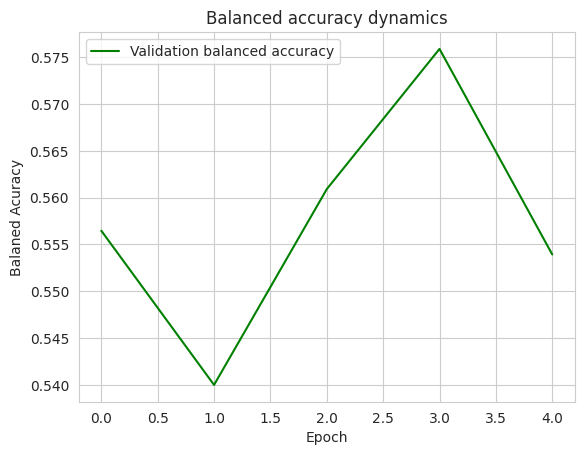

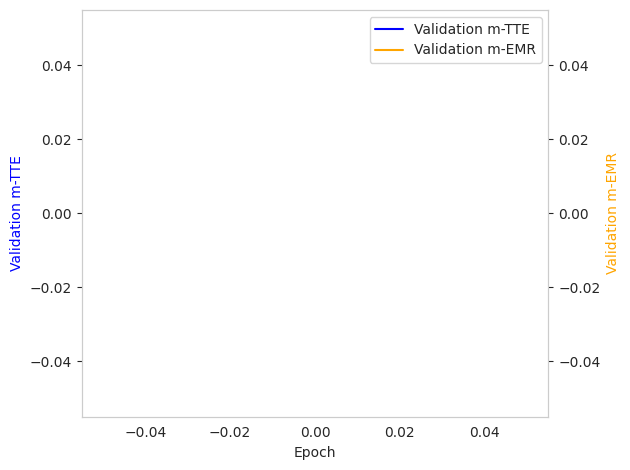

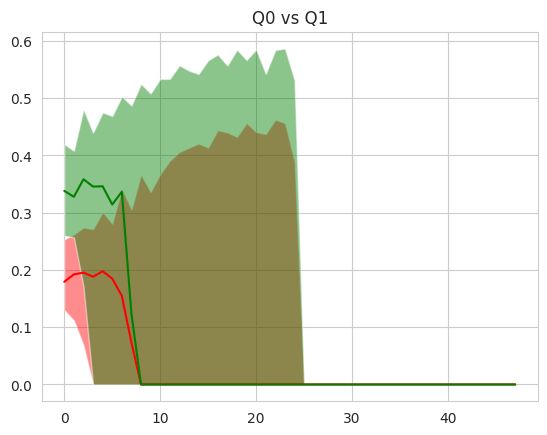

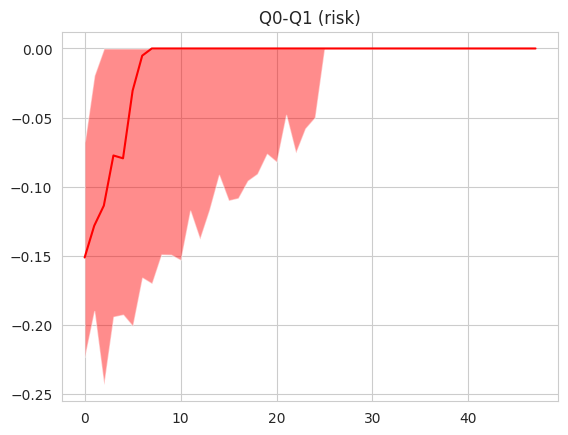

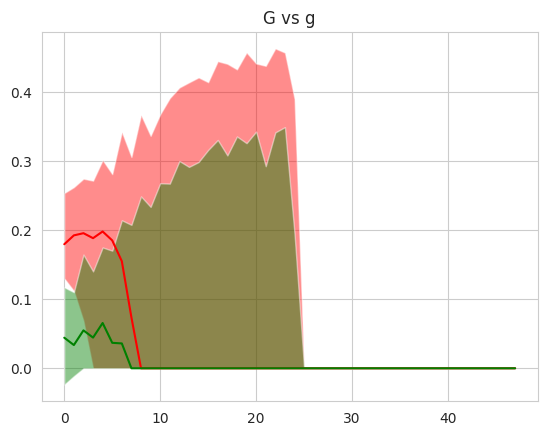

Balance Accuracy Score: 0.5776231499889551
F1: 0.0764685436218283
pr_auc: 0.03813322676434132
median time-to-event: 23.79090909090909
median event miss-rate: 0.26666666666666666
number of missed events: 40


NameError: name 'iq_smote' is not defined

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 5
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=500)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=True, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=True
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)
    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


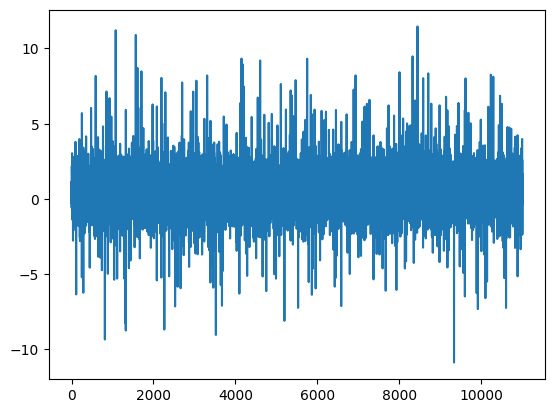

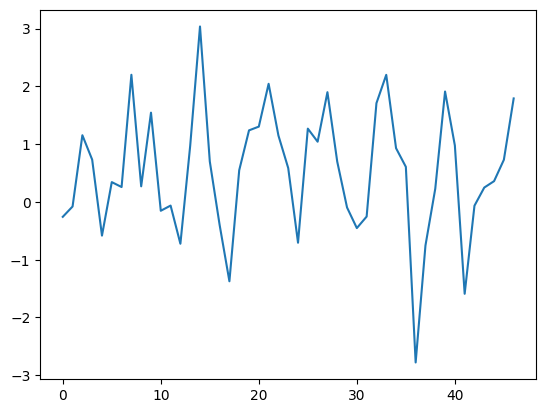

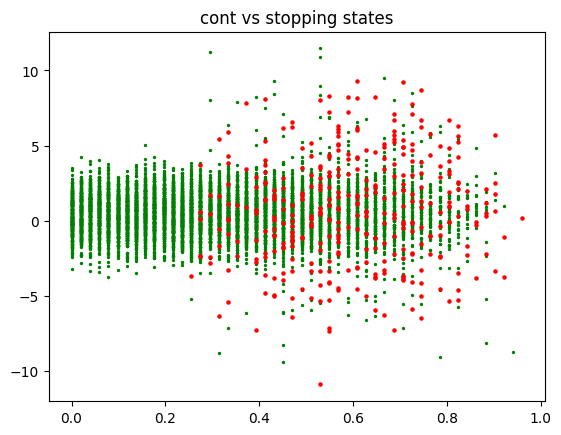

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  1%|▏         | 2/150 [00:01<02:10,  1.13it/s]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.05151887691539267


 40%|████      | 60/150 [00:48<01:12,  1.25it/s]

Saving best model checkpoint with balanced acc: 0.5047619047619047, avg Q-entropy: 0.004006576623119738


 45%|████▍     | 67/150 [00:53<01:04,  1.28it/s]

Saving best model checkpoint with balanced acc: 0.5095238095238095, avg Q-entropy: 0.003910338890779278


 46%|████▌     | 69/150 [00:55<01:01,  1.32it/s]

Saving best model checkpoint with balanced acc: 0.5285714285714286, avg Q-entropy: 0.00387711125506979


 57%|█████▋    | 85/150 [01:07<00:50,  1.28it/s]

Saving best model checkpoint with balanced acc: 0.5333333333333333, avg Q-entropy: 0.0034115283000890327


 57%|█████▋    | 86/150 [01:08<00:51,  1.25it/s]

Saving best model checkpoint with balanced acc: 0.5428571428571428, avg Q-entropy: 0.003357100472583071


 59%|█████▊    | 88/150 [01:09<00:48,  1.28it/s]

Saving best model checkpoint with balanced acc: 0.6042820583127685, avg Q-entropy: 0.003305501891705005


 71%|███████   | 106/150 [01:23<00:34,  1.29it/s]

Saving best model checkpoint with balanced acc: 0.6095238095238096, avg Q-entropy: 0.002920888951453178


 84%|████████▍ | 126/150 [01:38<00:17,  1.39it/s]

Saving best model checkpoint with balanced acc: 0.638095238095238, avg Q-entropy: 0.0024298492657101674


100%|██████████| 150/150 [01:59<00:00,  1.26it/s]


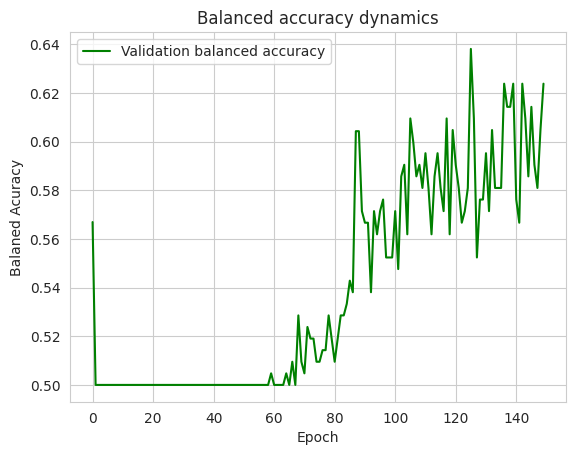

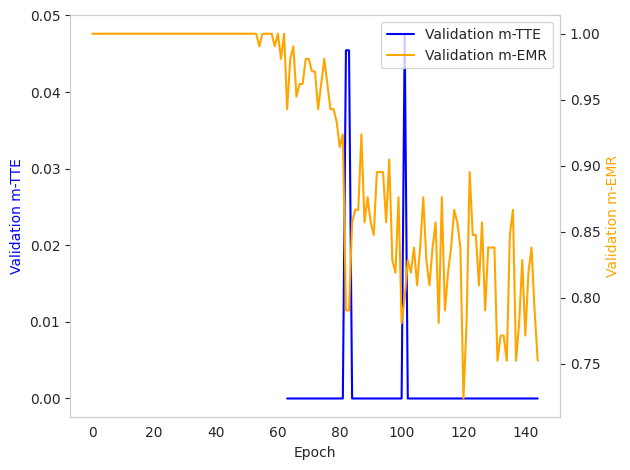

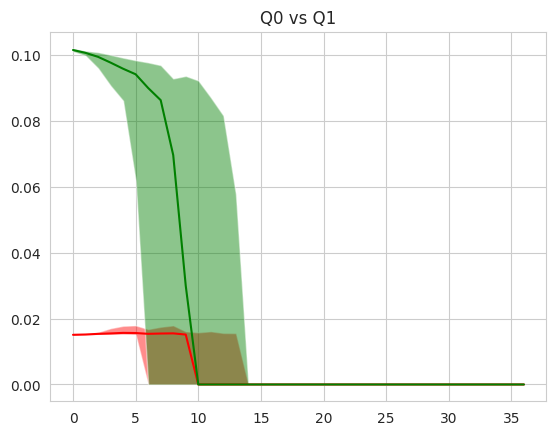

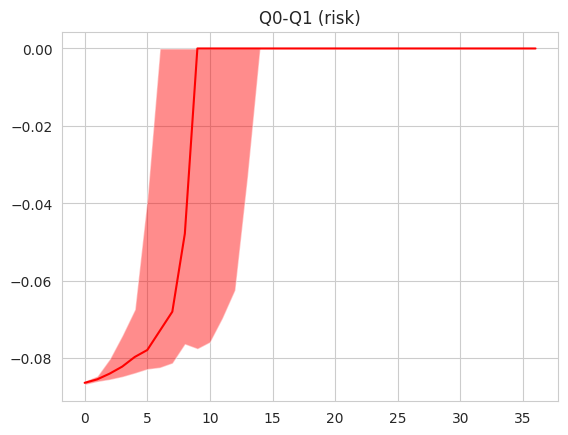

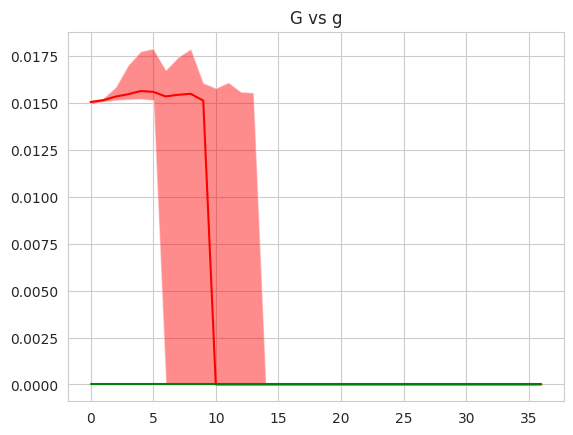

Balance Accuracy Score: 0.6663451232583065
F1: 0.4975124378109453
pr_auc: 0.38544841201387686
median time-to-event: 0.02
median event miss-rate: 0.6666666666666666
number of missed events: 100
IQ-Learning + oversampling CS-SMOTE
q_net ON CUDA: False


  1%|▏         | 2/150 [00:02<03:01,  1.22s/it]

Saving best model checkpoint with balanced acc: 0.6309950066983315, avg Q-entropy: 0.05641408064044439


  2%|▏         | 3/150 [00:03<02:52,  1.17s/it]

Saving best model checkpoint with balanced acc: 0.7047010108391183, avg Q-entropy: 0.05015532987622114


  3%|▎         | 4/150 [00:04<02:42,  1.11s/it]

Saving best model checkpoint with balanced acc: 0.7762026549750336, avg Q-entropy: 0.043597581390386976


  4%|▍         | 6/150 [00:07<02:51,  1.19s/it]

Saving best model checkpoint with balanced acc: 0.8084764340518816, avg Q-entropy: 0.03363198739213821


  6%|▌         | 9/150 [00:10<02:44,  1.17s/it]

Saving best model checkpoint with balanced acc: 0.8372670807453416, avg Q-entropy: 0.023099561150257405


  7%|▋         | 10/150 [00:12<02:59,  1.28s/it]

Saving best model checkpoint with balanced acc: 0.8497016197783461, avg Q-entropy: 0.020079327556185234


  7%|▋         | 11/150 [00:13<03:01,  1.30s/it]

Saving best model checkpoint with balanced acc: 0.876141761052247, avg Q-entropy: 0.01844991232531193


 13%|█▎        | 19/150 [00:23<02:44,  1.25s/it]

Saving best model checkpoint with balanced acc: 0.88438679819754, avg Q-entropy: 0.010432253878277082


 15%|█▌        | 23/150 [00:28<02:45,  1.31s/it]

Saving best model checkpoint with balanced acc: 0.8939836804286931, avg Q-entropy: 0.008859138732823806


100%|██████████| 150/150 [03:17<00:00,  1.32s/it]


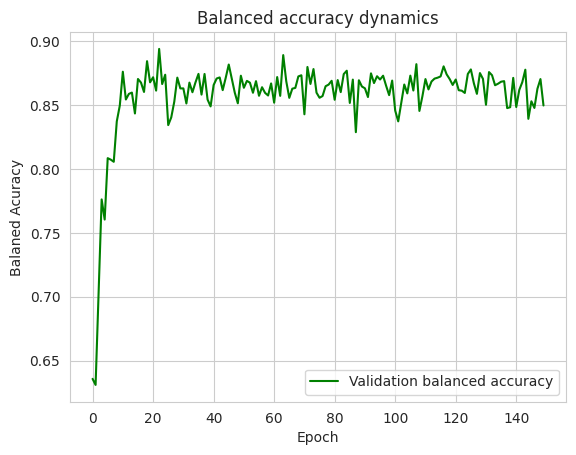

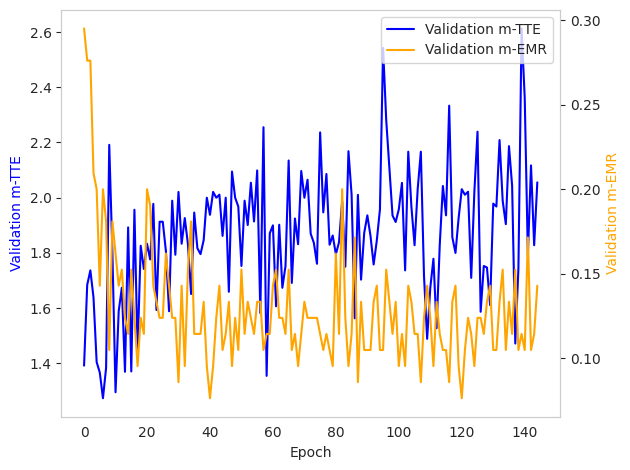

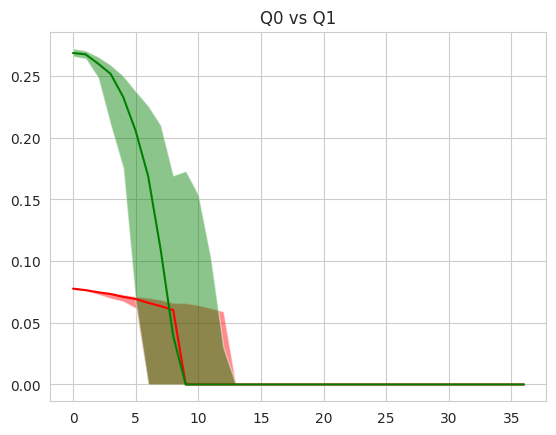

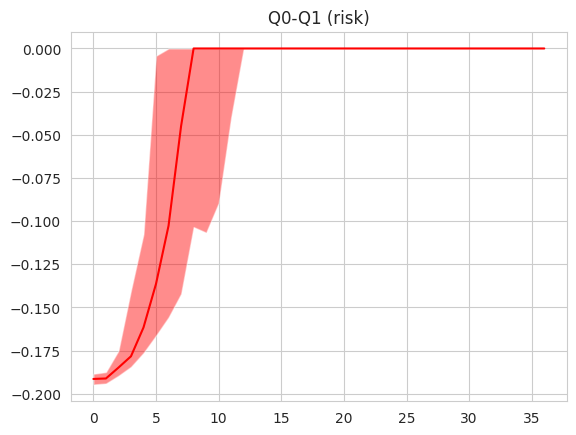

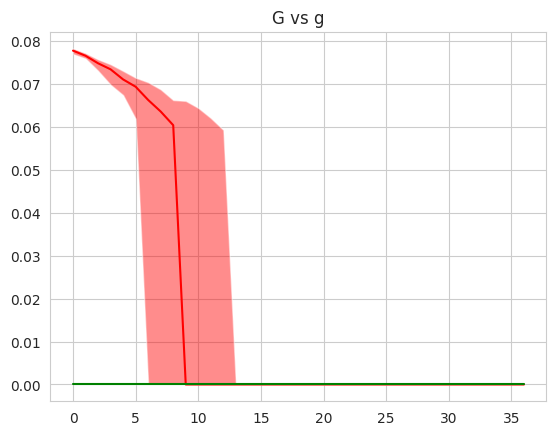

Balance Accuracy Score: 0.84513397642015
F1: 0.5353982300884956
pr_auc: 0.34020968065616647
median time-to-event: 1.4958677685950412
median event miss-rate: 0.19333333333333333
number of missed events: 29
Approximating P, no oversampling
q_net ON CUDA: False


 40%|████      | 2/5 [00:02<00:03,  1.17s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: 0.02790358510207046


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


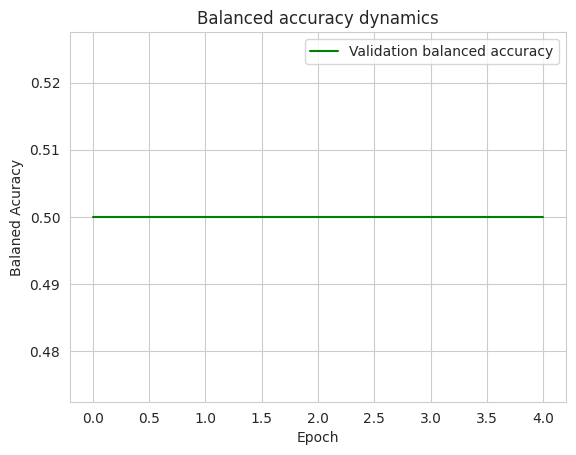

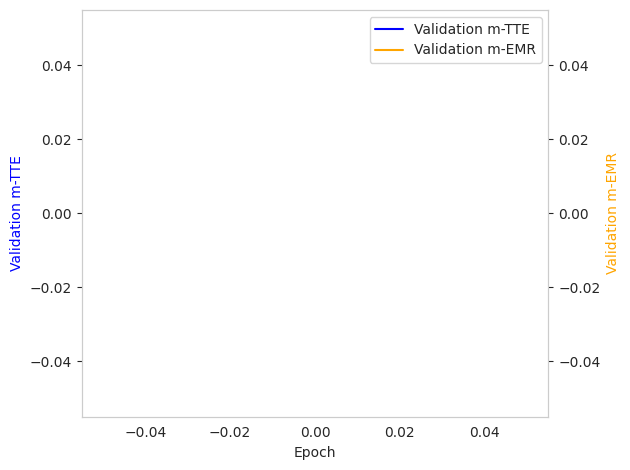

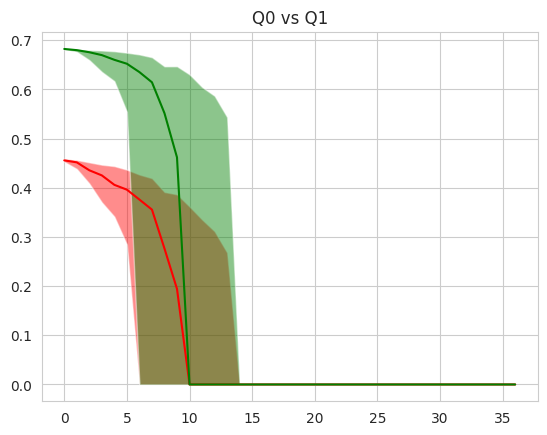

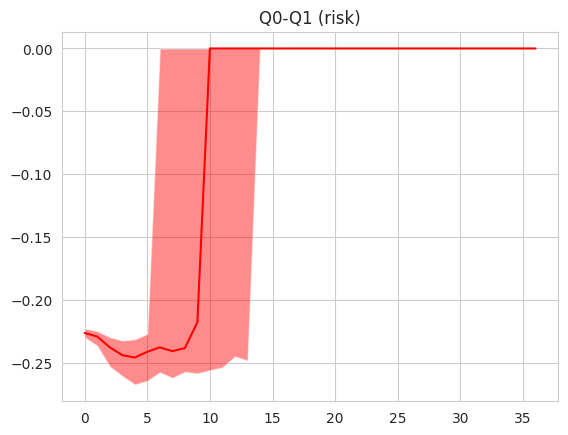

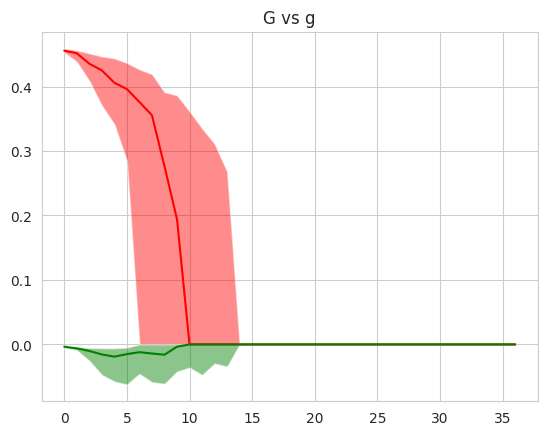

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.08797653958944282
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 150
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


  1%|▏         | 2/150 [00:03<03:46,  1.53s/it]

Saving best model checkpoint with balanced acc: 0.7673690125017558, avg Q-entropy: 0.047242407573432454


  2%|▏         | 3/150 [00:04<04:04,  1.66s/it]

Saving best model checkpoint with balanced acc: 0.8348925410872313, avg Q-entropy: 0.03436265181659198


  3%|▎         | 4/150 [00:06<04:19,  1.78s/it]

Saving best model checkpoint with balanced acc: 0.8368310155920775, avg Q-entropy: 0.026152993983975272


  3%|▎         | 5/150 [00:08<04:21,  1.80s/it]

Saving best model checkpoint with balanced acc: 0.8368591094254811, avg Q-entropy: 0.020807889403729903


  4%|▍         | 6/150 [00:10<04:18,  1.80s/it]

Saving best model checkpoint with balanced acc: 0.8760921477735637, avg Q-entropy: 0.01768169979133257


  5%|▍         | 7/150 [00:12<04:46,  2.01s/it]

Saving best model checkpoint with balanced acc: 0.8822025565388397, avg Q-entropy: 0.015719991631624176


  5%|▌         | 8/150 [00:14<04:47,  2.02s/it]

Saving best model checkpoint with balanced acc: 0.8926815563983705, avg Q-entropy: 0.014122229637350978


 19%|█▉        | 29/150 [00:53<03:34,  1.77s/it]

Saving best model checkpoint with balanced acc: 0.9138783537013626, avg Q-entropy: 0.010200362016515033


100%|██████████| 150/150 [04:35<00:00,  1.83s/it]


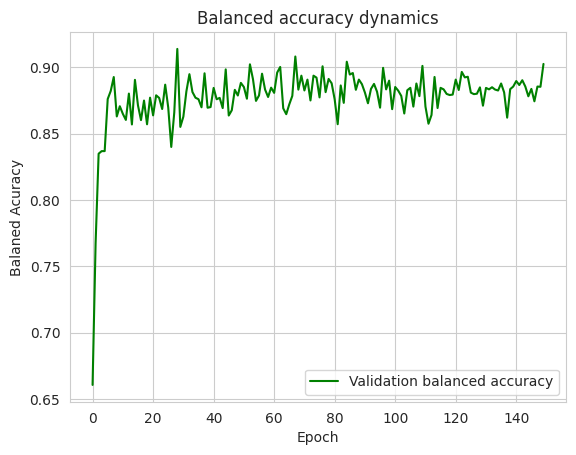

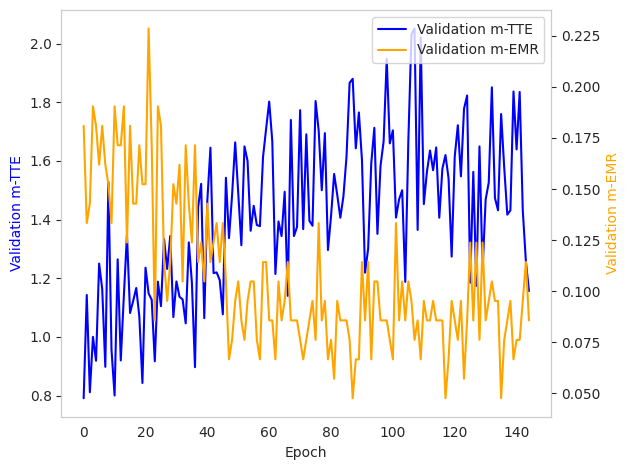

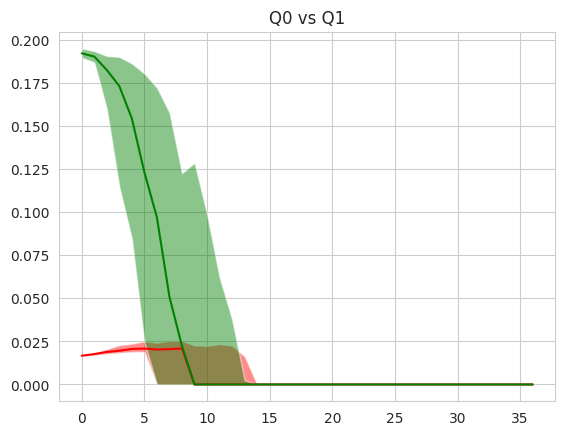

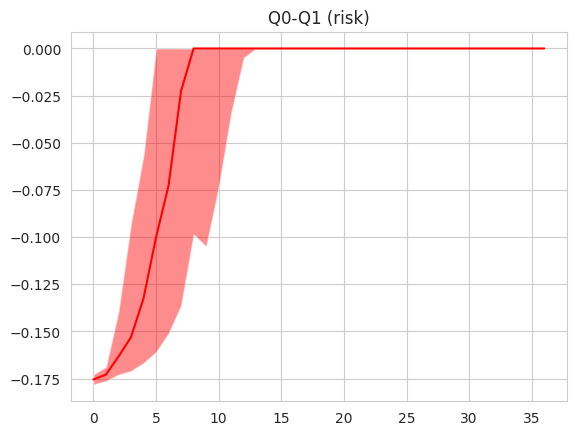

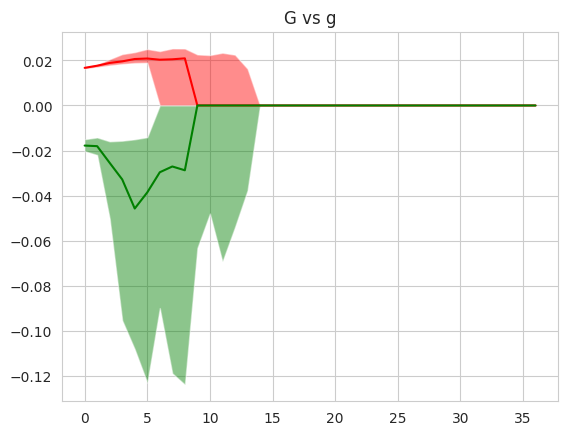

Balance Accuracy Score: 0.8609217577706323
F1: 0.5675057208237986
pr_auc: 0.3724153528087438
median time-to-event: 1.314516129032258
median event miss-rate: 0.17333333333333334
number of missed events: 26
Approximating g and P, no oversampling
g_net ON CUDA: False
q_net ON CUDA: False


  1%|▏         | 2/150 [00:53<1:05:11, 26.43s/it]

Saving best model checkpoint with balanced acc: 0.5122078682219156, avg Q-entropy: 0.04889681901444088


  2%|▏         | 3/150 [01:18<1:03:08, 25.78s/it]

Saving best model checkpoint with balanced acc: 0.52524353024792, avg Q-entropy: 0.04707277955656702


  3%|▎         | 5/150 [02:10<1:02:53, 26.03s/it]

Saving best model checkpoint with balanced acc: 0.538375350140056, avg Q-entropy: 0.050212864340706306


  4%|▍         | 6/150 [02:37<1:02:59, 26.25s/it]

Saving best model checkpoint with balanced acc: 0.539102805301225, avg Q-entropy: 0.051341146738691765


 93%|█████████▎| 140/150 [1:02:25<04:27, 26.75s/it]


KeyboardInterrupt: 

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    # bm_sym = Simulation(problem='CP1', total_n=500)
    bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.001, env_lr=0.001, g_lr=0.001,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


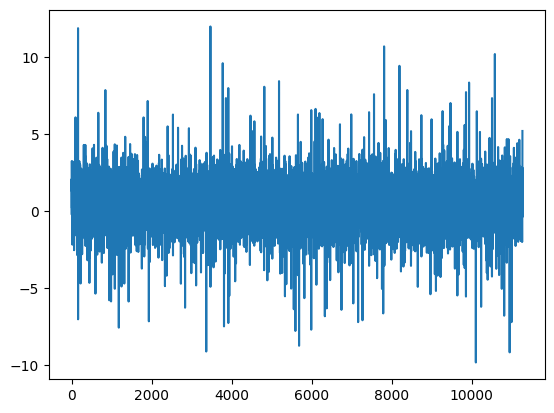

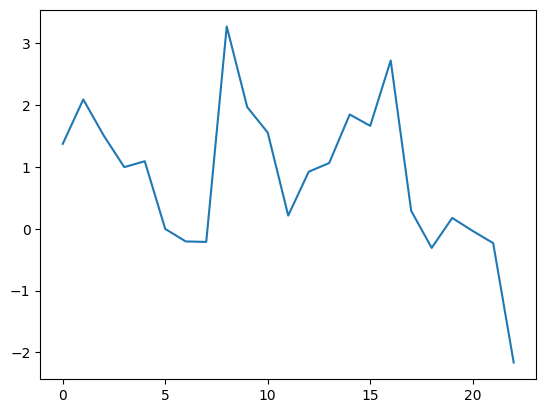

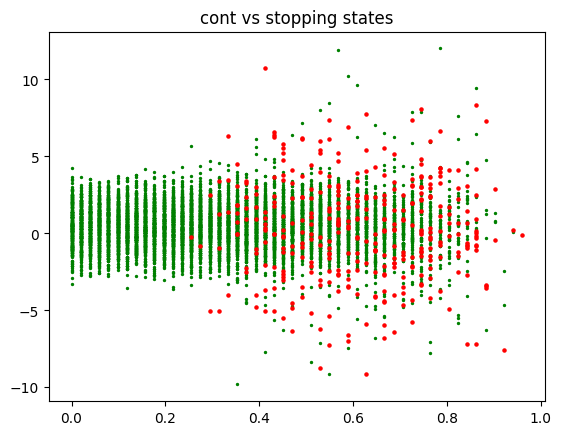

RANDOM SEED: 0
Start training
IQ-Learn
q_net ON CUDA: False


  1%|▏         | 2/150 [00:01<01:47,  1.37it/s]

Saving best model checkpoint with balanced acc: 0.5511932070667643, avg Q-entropy: nan


100%|██████████| 150/150 [02:03<00:00,  1.21it/s]


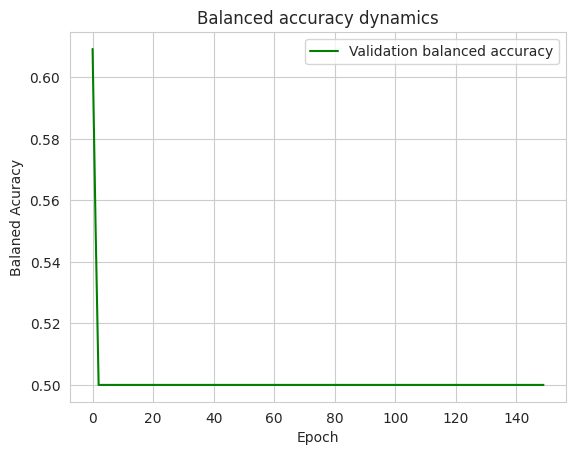

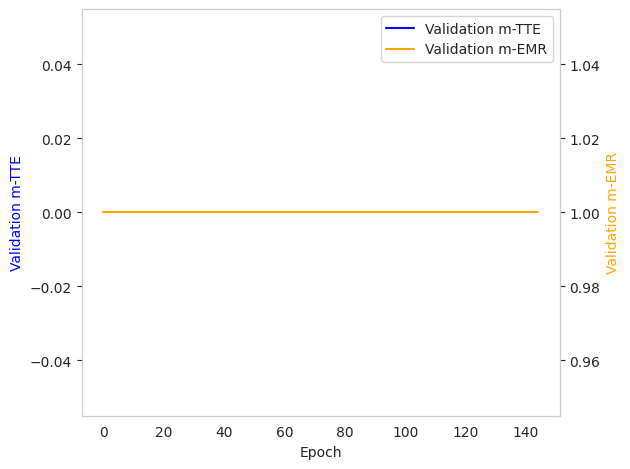

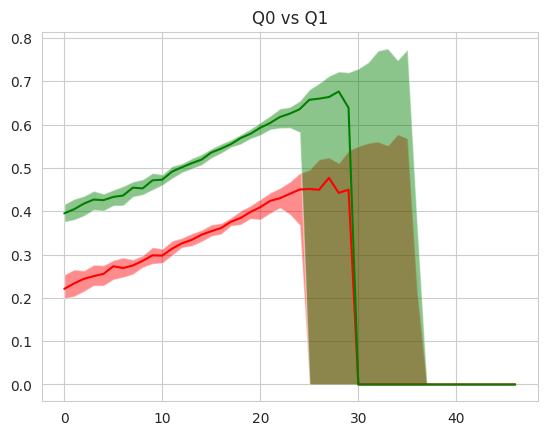

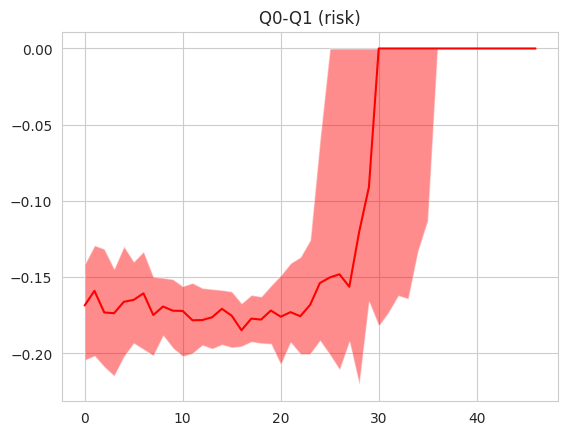

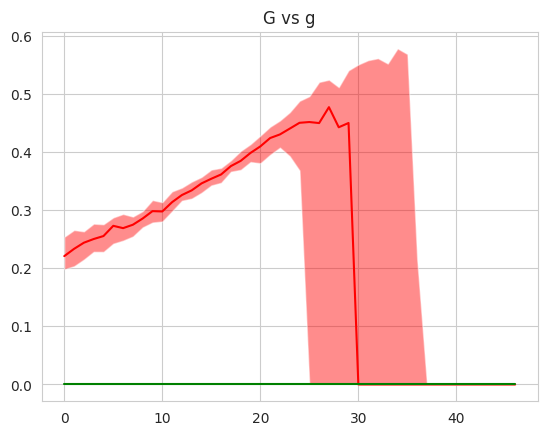

Balance Accuracy Score: 0.5423989218328841
F1: 0.13861386138613863
pr_auc: 0.05468057366362451
median time-to-event: 2.7142857142857144
median event miss-rate: 0.9066666666666666
number of missed events: 68
IQ-Learning + oversampling CS-SMOTE
q_net ON CUDA: False


  1%|▏         | 2/150 [00:02<02:59,  1.21s/it]

Saving best model checkpoint with balanced acc: 0.5445136471881297, avg Q-entropy: nan


  2%|▏         | 3/150 [00:04<03:44,  1.53s/it]

Saving best model checkpoint with balanced acc: 0.5906587745008244, avg Q-entropy: nan


  3%|▎         | 4/150 [00:06<04:19,  1.78s/it]

Saving best model checkpoint with balanced acc: 0.609108811137571, avg Q-entropy: nan


  3%|▎         | 5/150 [00:09<05:44,  2.37s/it]

Saving best model checkpoint with balanced acc: 0.6763200677779813, avg Q-entropy: nan


  4%|▍         | 6/150 [00:12<06:09,  2.56s/it]

Saving best model checkpoint with balanced acc: 0.7315098919215974, avg Q-entropy: nan


  5%|▍         | 7/150 [00:15<05:50,  2.45s/it]

Saving best model checkpoint with balanced acc: 0.7459871313427369, avg Q-entropy: nan


  5%|▌         | 8/150 [00:16<05:13,  2.21s/it]

Saving best model checkpoint with balanced acc: 0.7590332478475912, avg Q-entropy: nan


  6%|▌         | 9/150 [00:19<05:29,  2.34s/it]

Saving best model checkpoint with balanced acc: 0.766011403187397, avg Q-entropy: nan


  7%|▋         | 11/150 [00:22<04:08,  1.79s/it]

Saving best model checkpoint with balanced acc: 0.7702875984612567, avg Q-entropy: nan


  9%|▊         | 13/150 [00:25<04:11,  1.84s/it]

Saving best model checkpoint with balanced acc: 0.7849365726323503, avg Q-entropy: nan


 10%|█         | 15/150 [00:29<03:51,  1.71s/it]

Saving best model checkpoint with balanced acc: 0.7864249404652868, avg Q-entropy: nan


 11%|█         | 16/150 [00:30<03:28,  1.55s/it]

Saving best model checkpoint with balanced acc: 0.7937351163216706, avg Q-entropy: nan


 13%|█▎        | 19/150 [00:34<03:04,  1.41s/it]

Saving best model checkpoint with balanced acc: 0.7983147096537828, avg Q-entropy: nan


 22%|██▏       | 33/150 [00:55<03:22,  1.73s/it]

Saving best model checkpoint with balanced acc: 0.8007418941198021, avg Q-entropy: nan


 32%|███▏      | 48/150 [01:14<02:11,  1.29s/it]

Saving best model checkpoint with balanced acc: 0.8013486902363071, avg Q-entropy: nan


 35%|███▍      | 52/150 [01:20<02:07,  1.30s/it]

Saving best model checkpoint with balanced acc: 0.8141486535995603, avg Q-entropy: nan


 50%|█████     | 75/150 [01:54<01:53,  1.51s/it]

Saving best model checkpoint with balanced acc: 0.8272233925627404, avg Q-entropy: nan


100%|██████████| 150/150 [03:38<00:00,  1.46s/it]


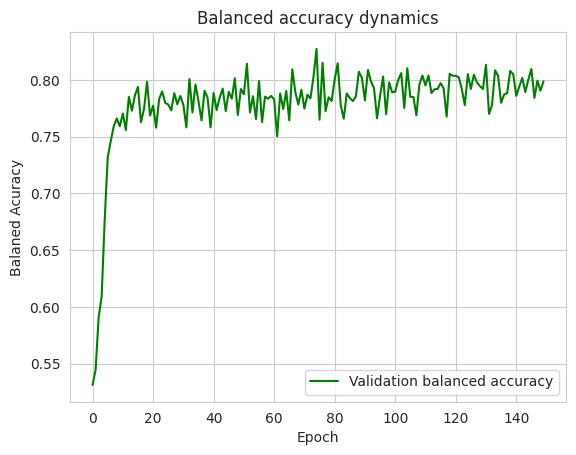

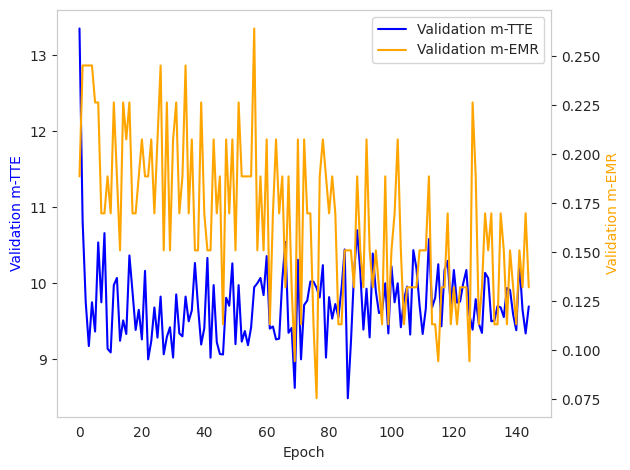

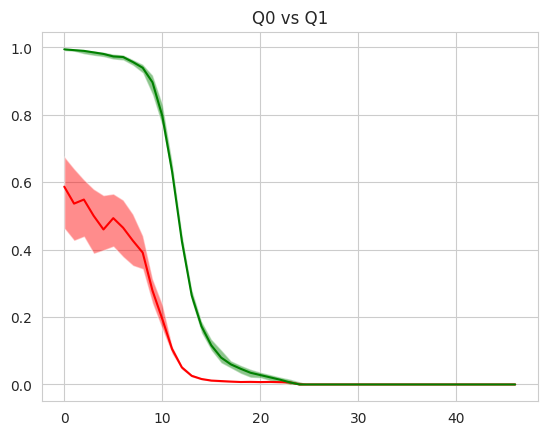

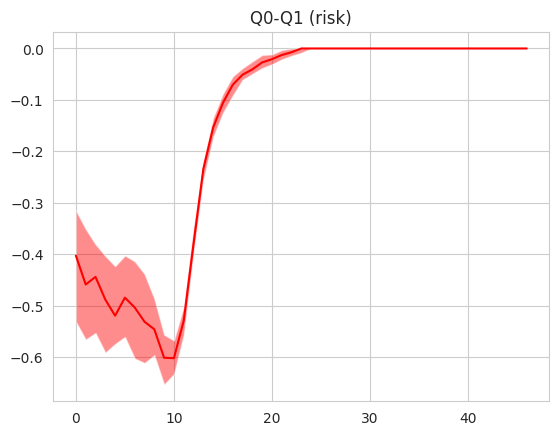

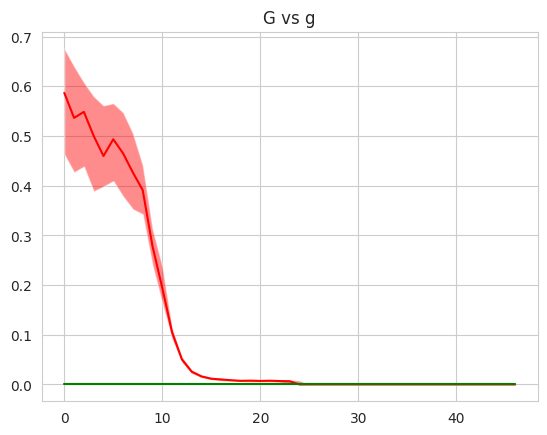

Balance Accuracy Score: 0.7515902964959569
F1: 0.1664190193164933
pr_auc: 0.07817924153959525
median time-to-event: 9.678571428571429
median event miss-rate: 0.25333333333333335
number of missed events: 19
Approximating P, no oversampling
q_net ON CUDA: False


 40%|████      | 2/5 [00:02<00:03,  1.24s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


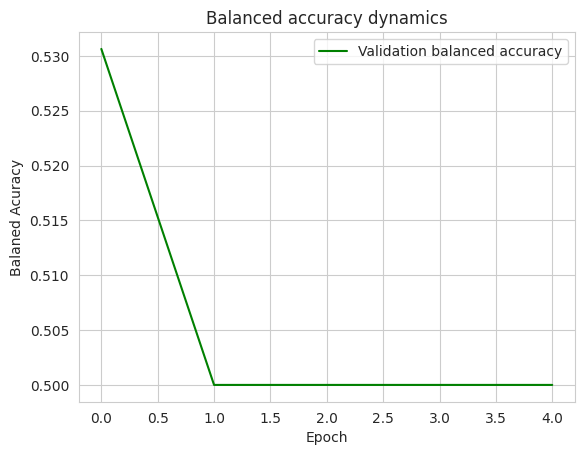

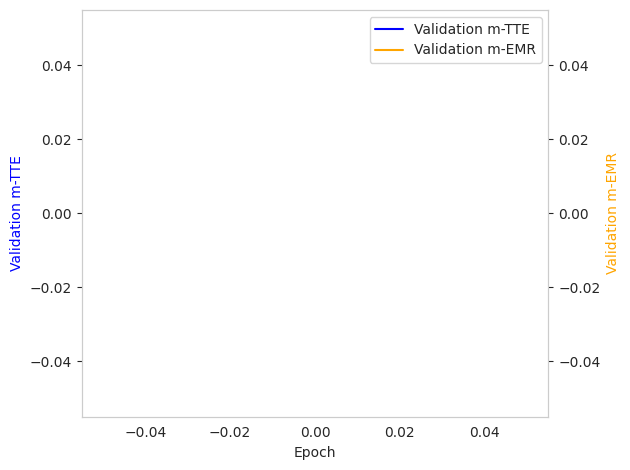

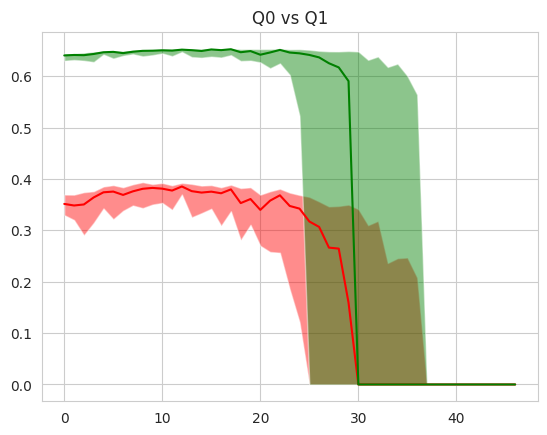

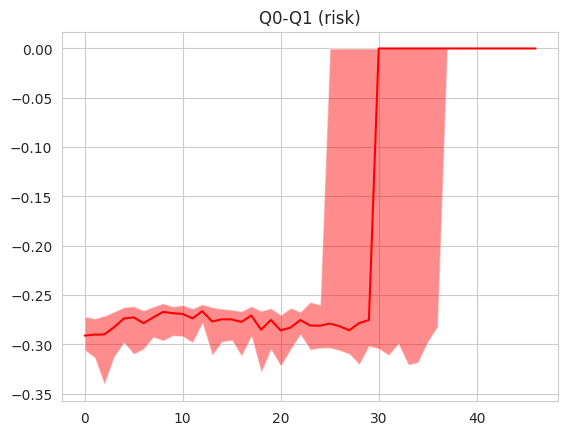

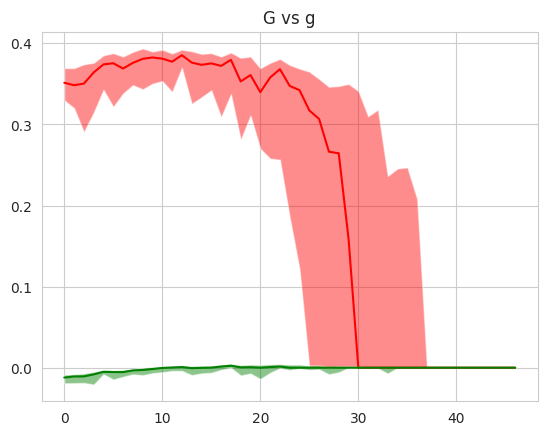

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03259452411994785
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 75
Approximating P + oversampling CS-SMOTE
q_net ON CUDA: False


  1%|▏         | 2/150 [00:03<04:29,  1.82s/it]

Saving best model checkpoint with balanced acc: 0.610019368457705, avg Q-entropy: nan


  2%|▏         | 3/150 [00:05<04:00,  1.64s/it]

Saving best model checkpoint with balanced acc: 0.7578561946421187, avg Q-entropy: nan


  3%|▎         | 4/150 [00:07<04:17,  1.76s/it]

Saving best model checkpoint with balanced acc: 0.8070879850275293, avg Q-entropy: nan


  6%|▌         | 9/150 [00:15<04:04,  1.74s/it]

Saving best model checkpoint with balanced acc: 0.80832299623512, avg Q-entropy: nan


  7%|▋         | 11/150 [00:19<04:01,  1.74s/it]

Saving best model checkpoint with balanced acc: 0.8088180888337577, avg Q-entropy: nan


 10%|█         | 15/150 [00:26<03:59,  1.78s/it]

Saving best model checkpoint with balanced acc: 0.8142151422167091, avg Q-entropy: nan


 12%|█▏        | 18/150 [00:31<03:52,  1.76s/it]

Saving best model checkpoint with balanced acc: 0.82364910448086, avg Q-entropy: nan


 83%|████████▎ | 125/150 [04:19<00:55,  2.23s/it]

Saving best model checkpoint with balanced acc: 0.8260810428499924, avg Q-entropy: nan


100%|██████████| 150/150 [05:16<00:00,  2.11s/it]


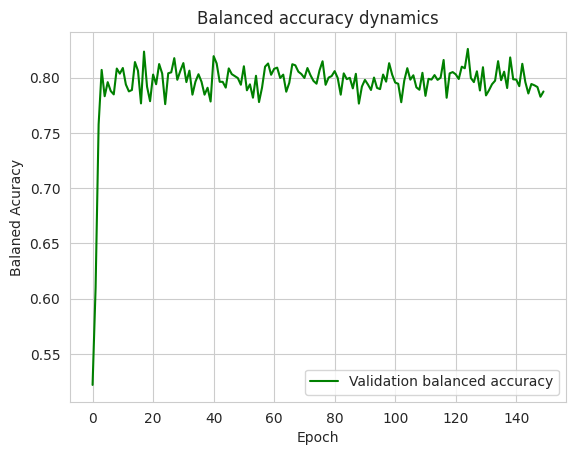

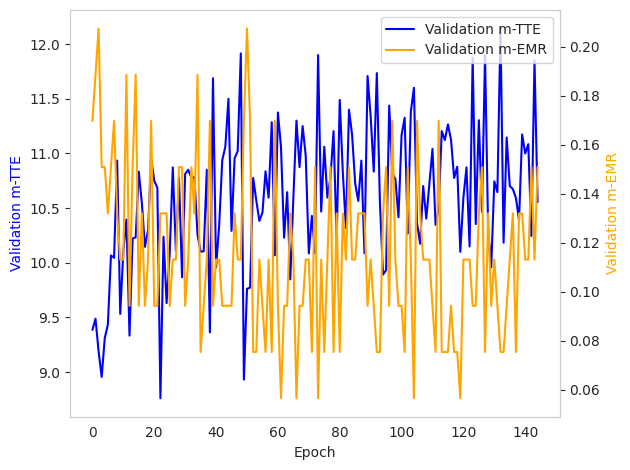

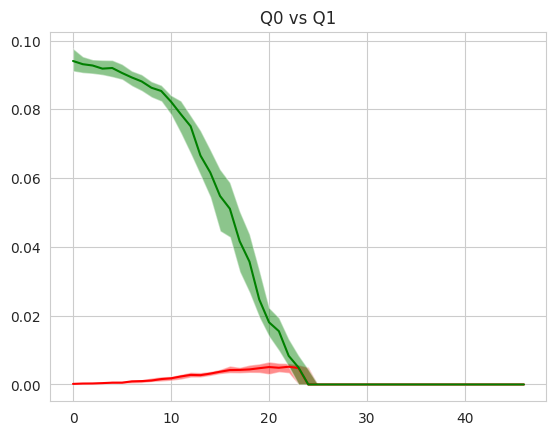

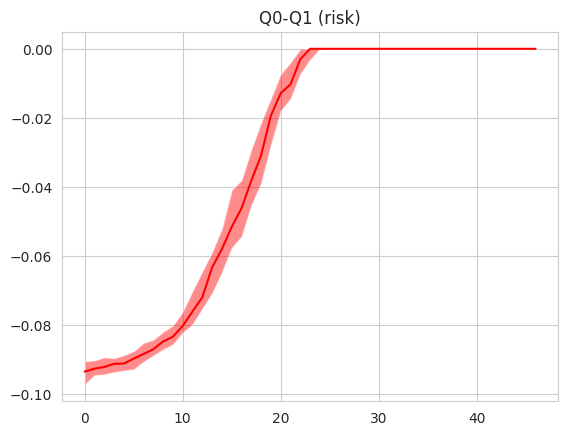

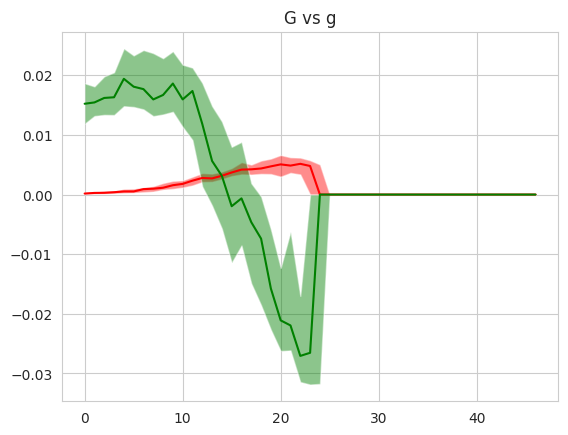

Balance Accuracy Score: 0.7587061994609164
F1: 0.16964285714285715
pr_auc: 0.08038549985913925
median time-to-event: 9.473684210526315
median event miss-rate: 0.24
number of missed events: 18
Approximating g and P, no oversampling
g_net ON CUDA: False
q_net ON CUDA: False


  1%|▏         | 2/150 [00:32<40:34, 16.45s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


100%|██████████| 150/150 [38:16<00:00, 15.31s/it]


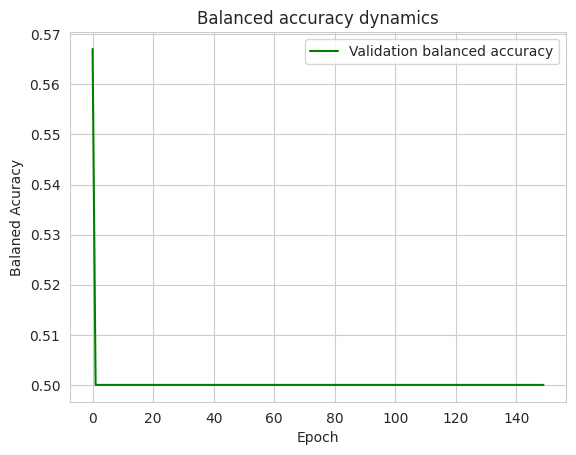

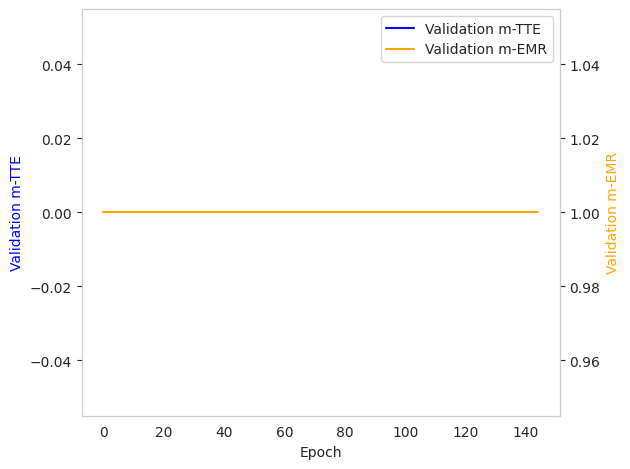

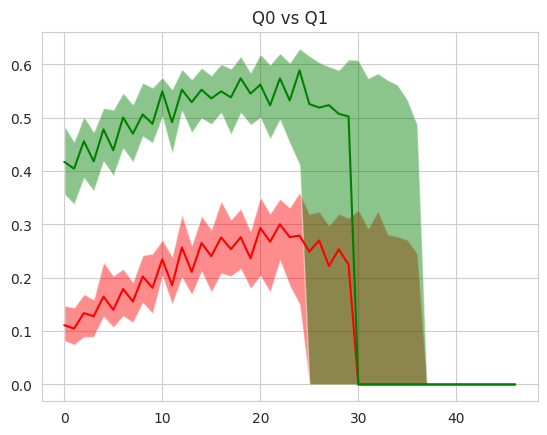

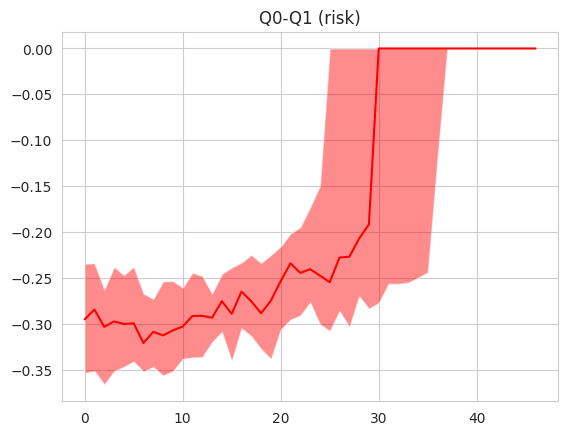

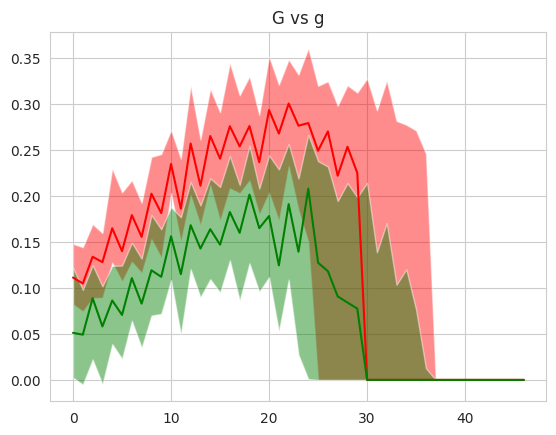

Balance Accuracy Score: 0.5
F1: 0.0
pr_auc: 0.03259452411994785
median time-to-event: nan
median event miss-rate: 1.0
number of missed events: 75


NameError: name 'iq_smote' is not defined

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # # iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


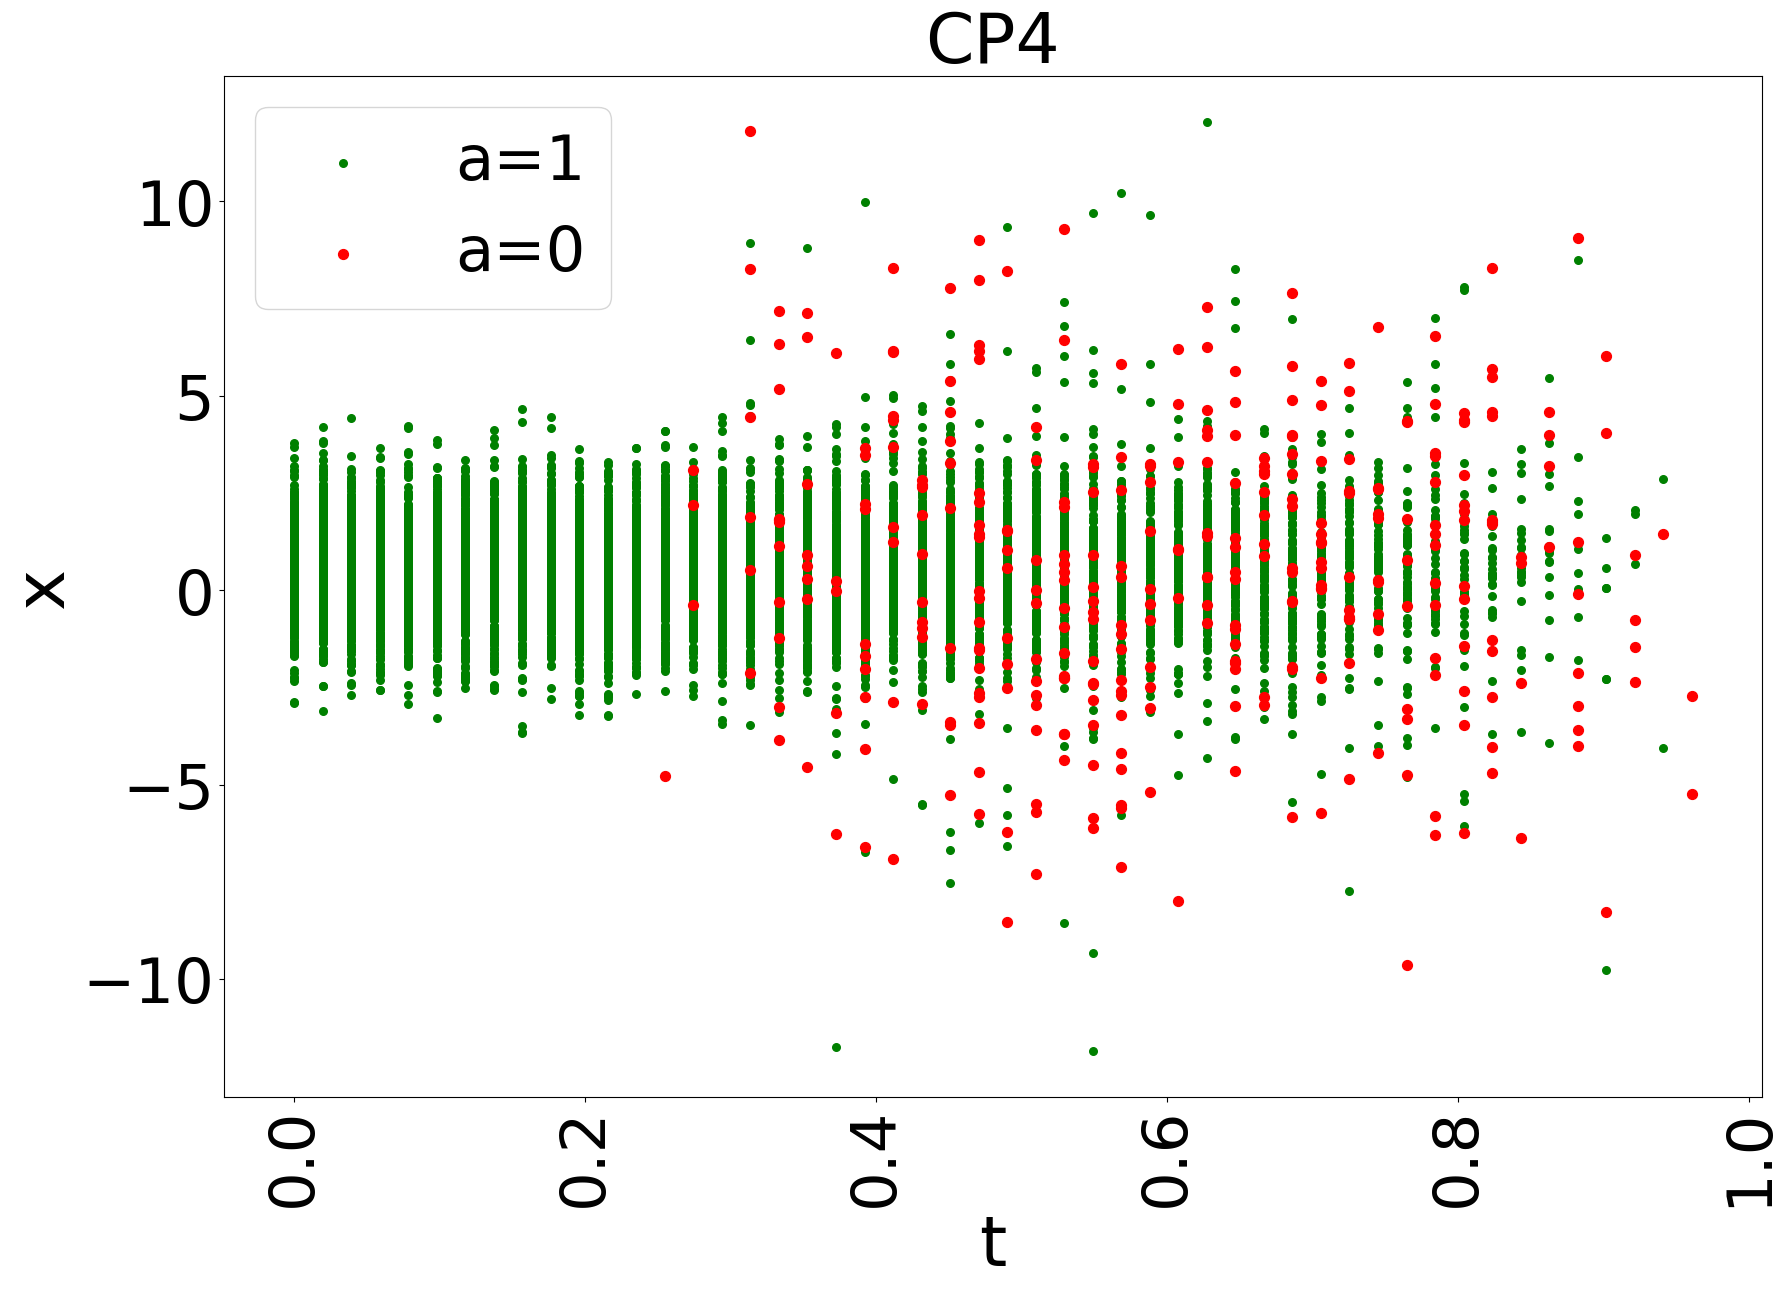

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:06<?, ?it/s]


TypeError: cumsum() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, name dim, *, torch.dtype dtype = None, Tensor out = None)


In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

: 

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


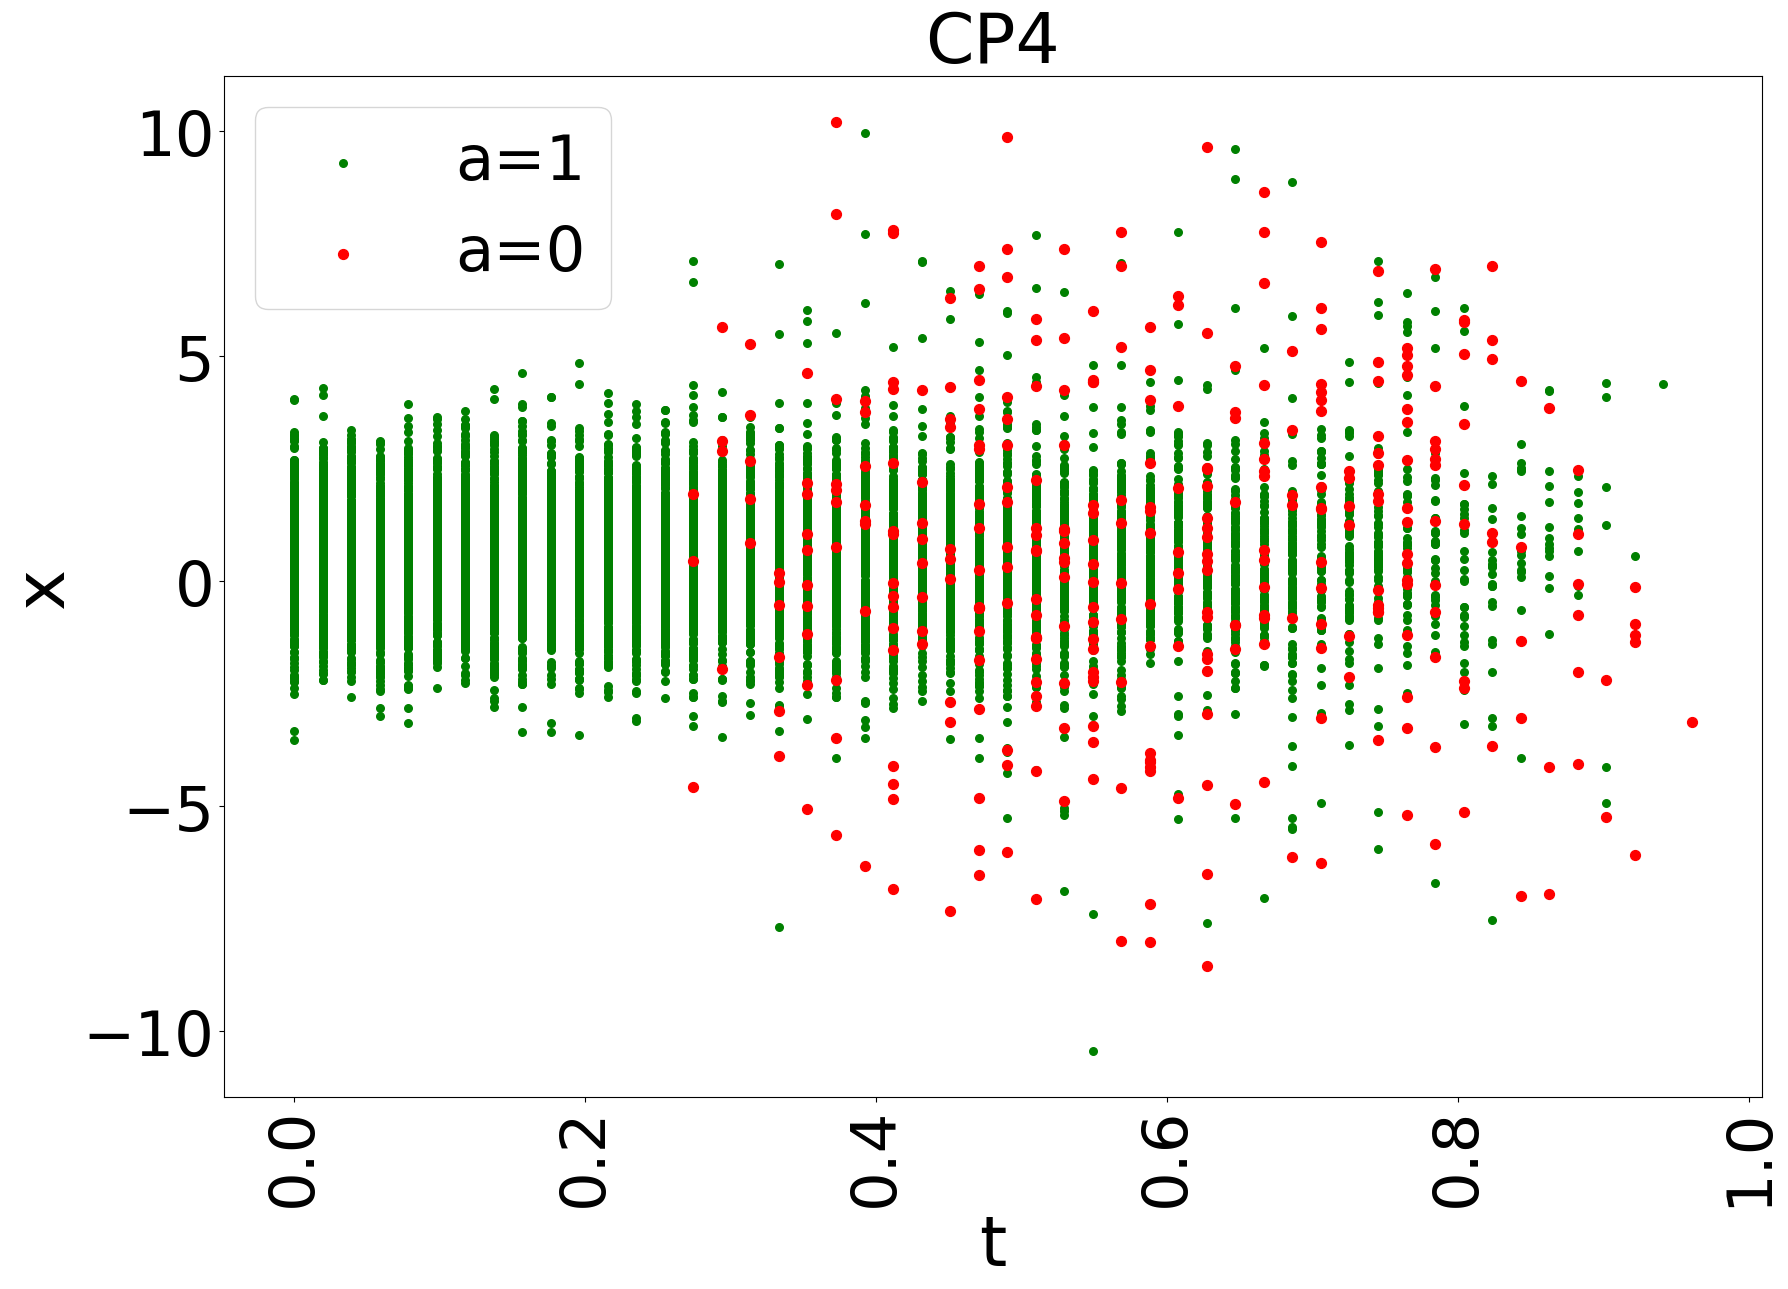

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:07<?, ?it/s]

irl_g.shape: torch.Size([1753, 1])
irl_y.shape: torch.Size([1753, 1])


TypeError: expected np.ndarray (got Tensor)

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


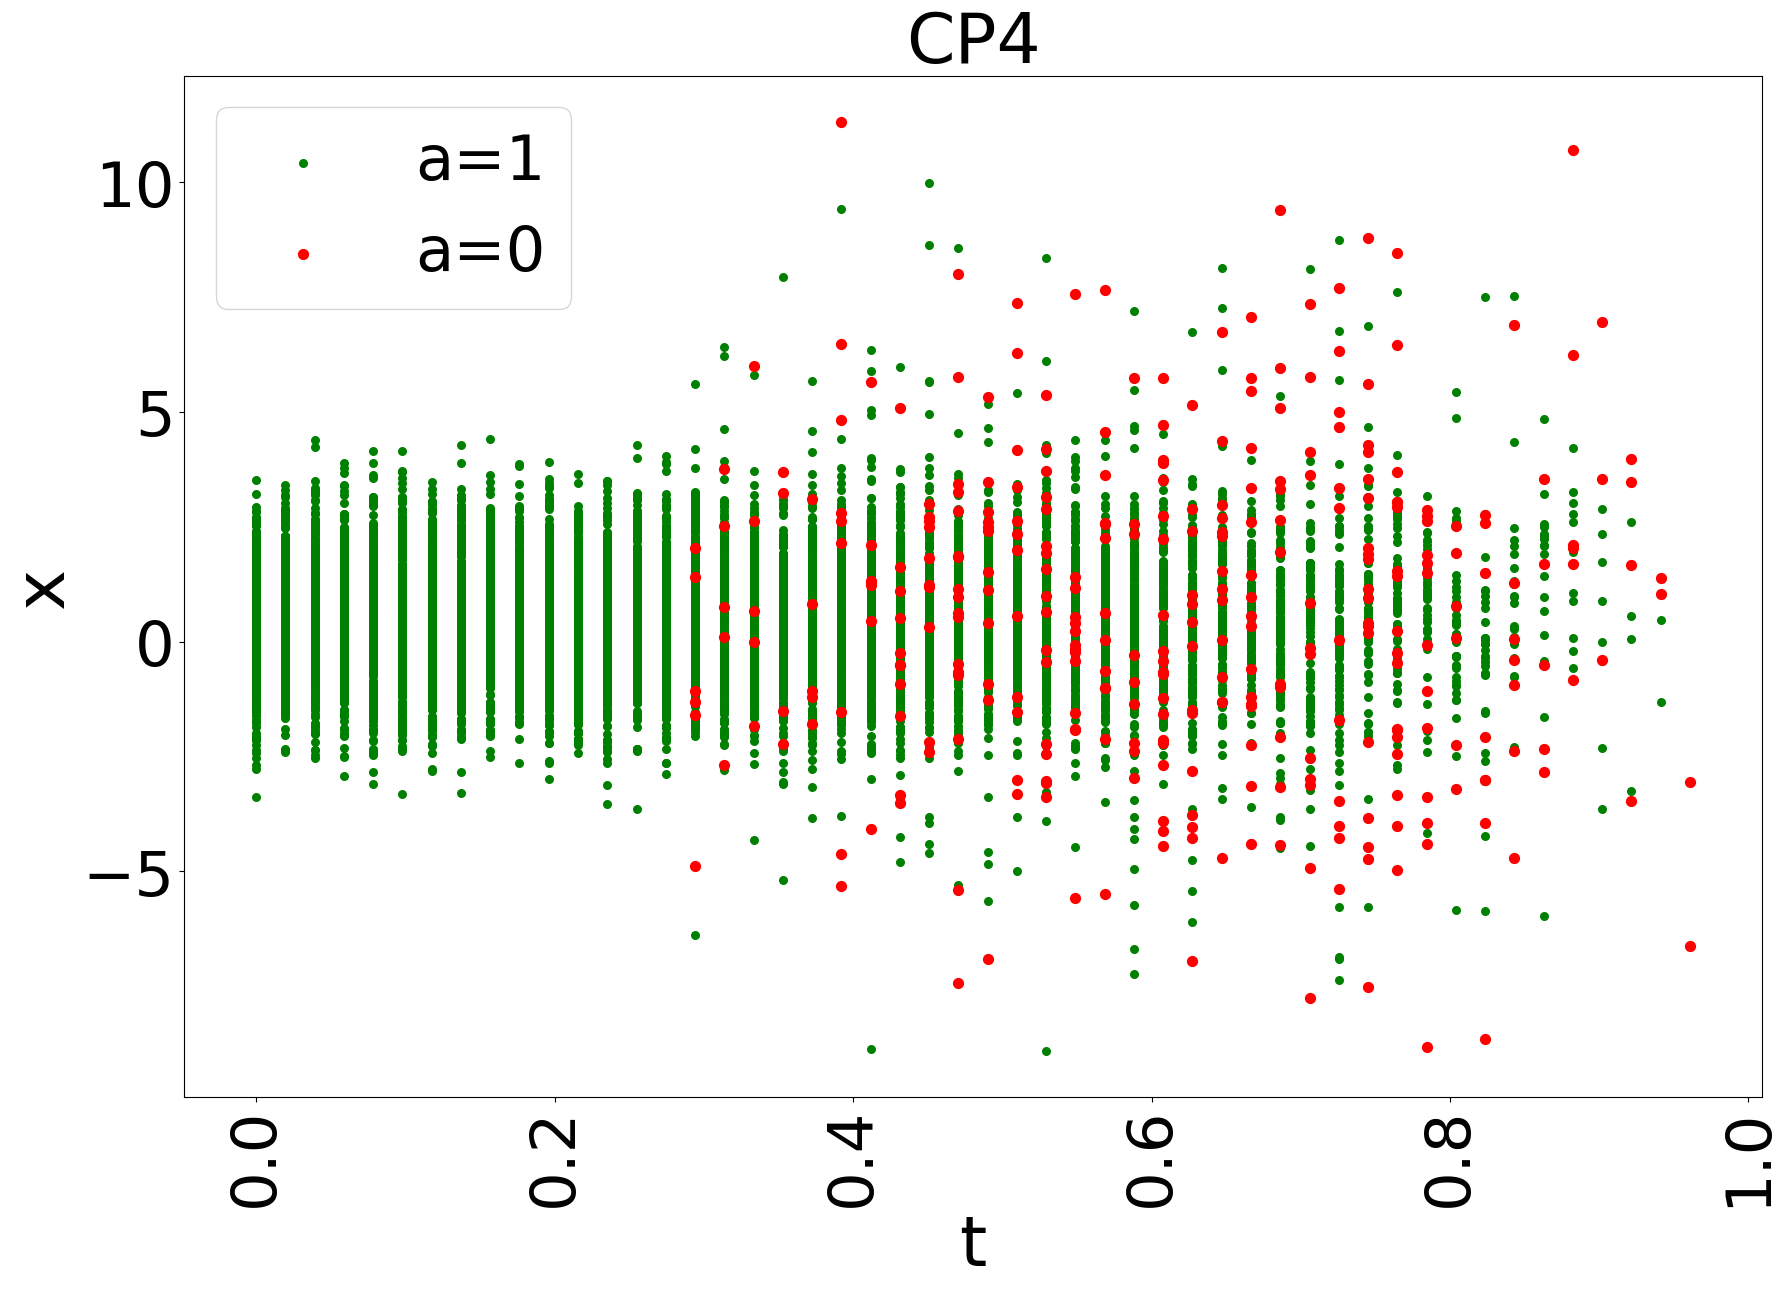

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:07<?, ?it/s]

irl_g.shape: torch.Size([1800, 1])
irl_y.shape: torch.Size([1800, 1])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1800 but got size 1 for tensor number 1 in the list.

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


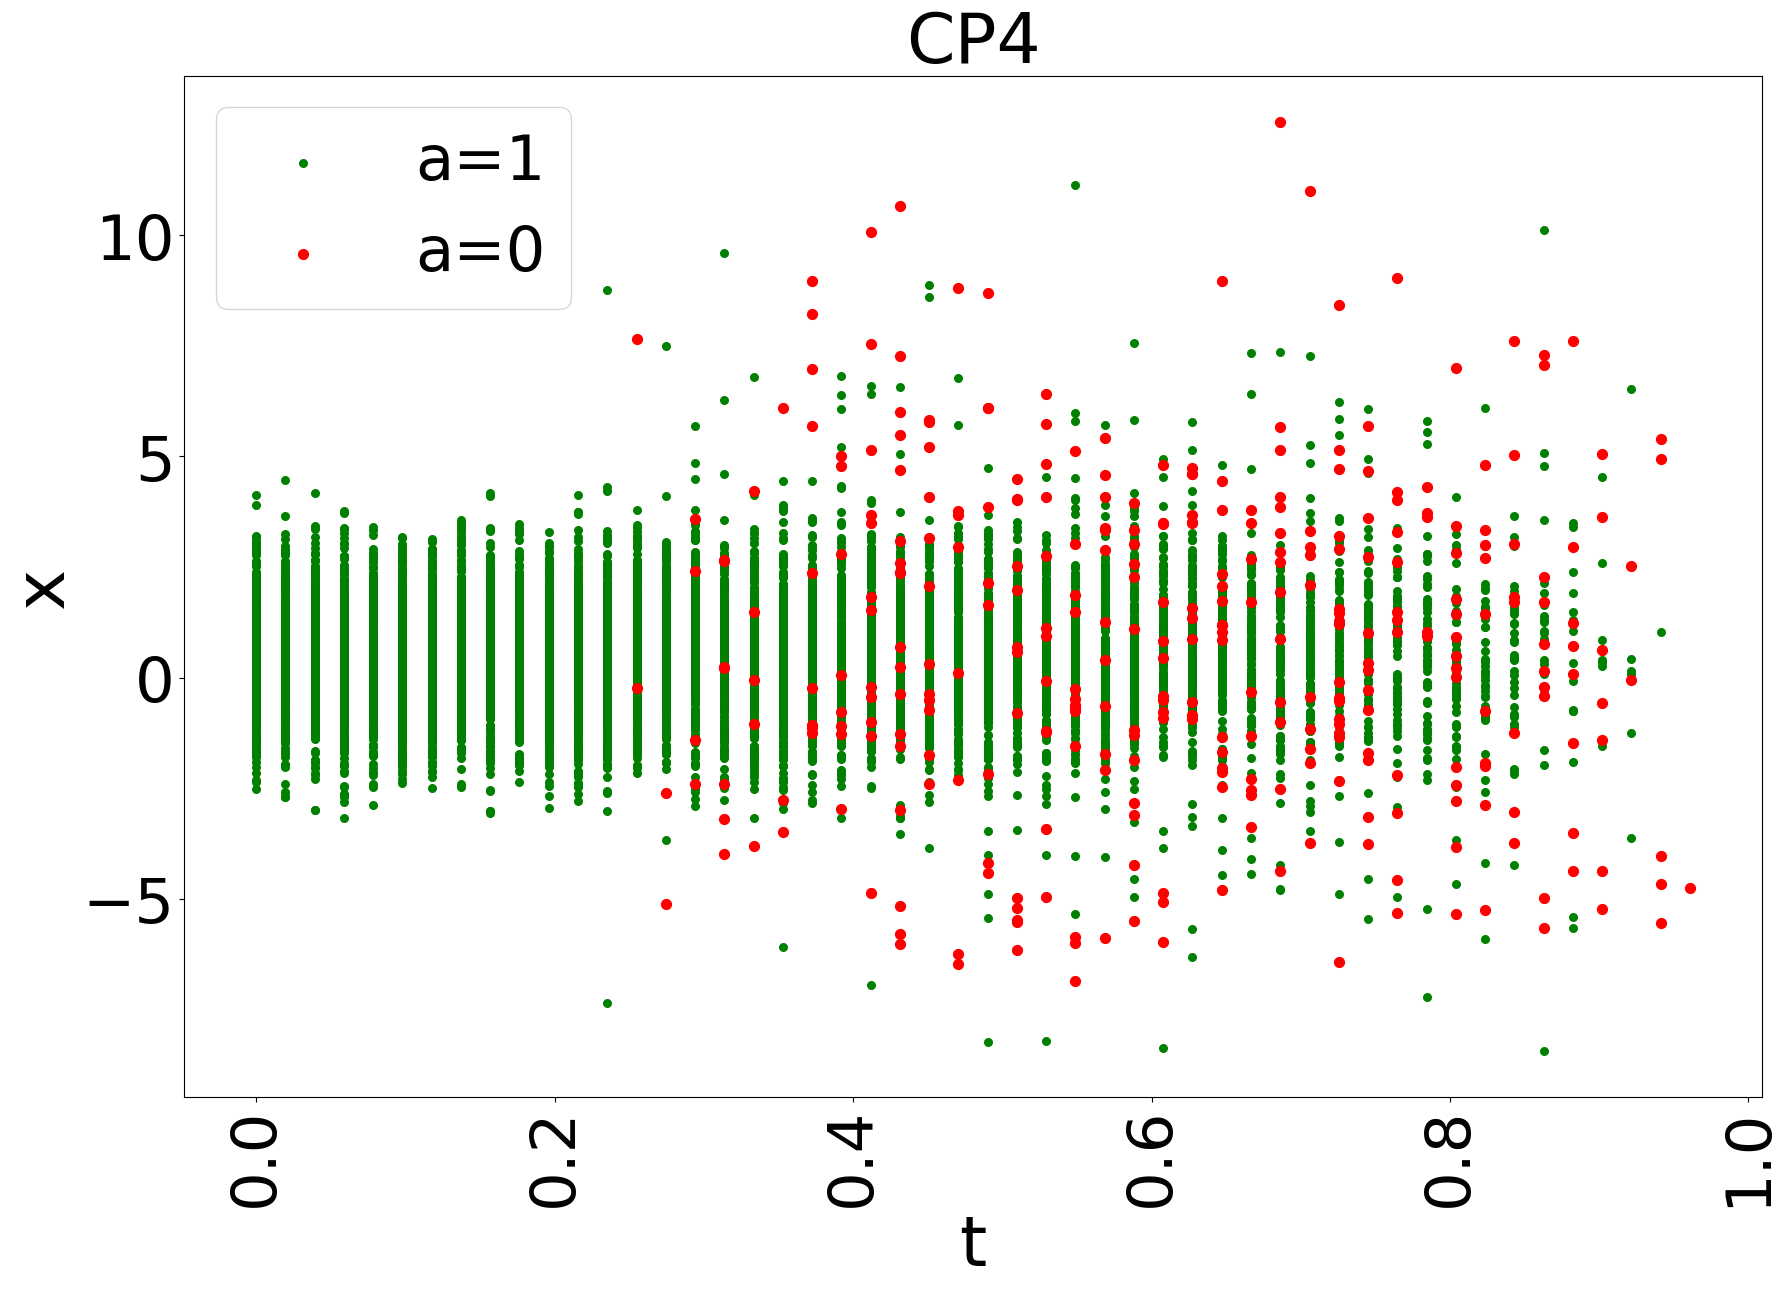

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:07<?, ?it/s]

irl_g.shape: torch.Size([1705, 1])


AttributeError: 'torch.Size' object has no attribute 'reshape'

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


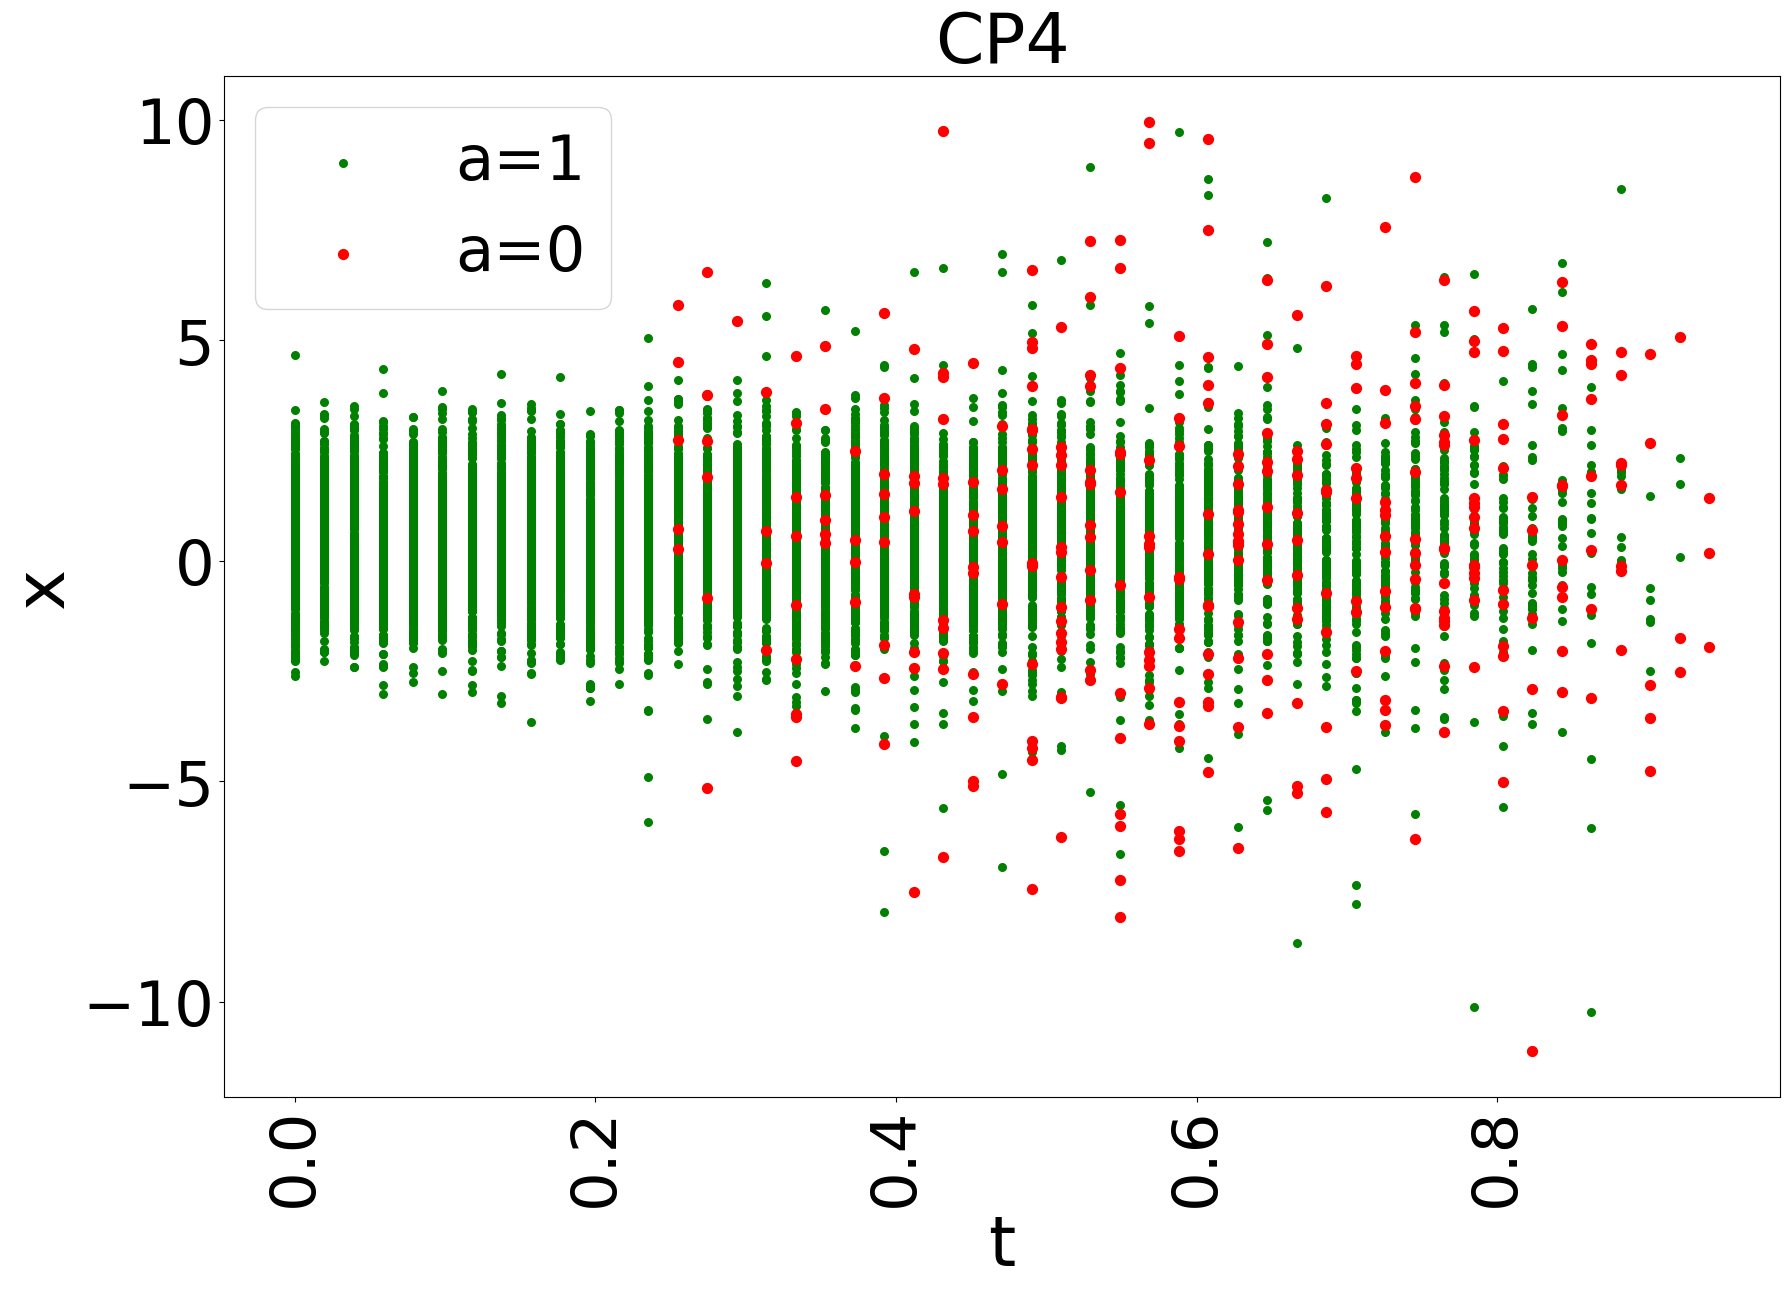

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:00<?, ?it/s]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  1%|          | 1/150 [00:07<18:03,  7.27s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  1%|▏         | 2/150 [00:14<17:46,  7.21s/it]

Saving best model checkpoint with balanced acc: 0.6304392783718356, avg Q-entropy: nan


  2%|▏         | 3/150 [00:22<18:31,  7.56s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])
irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  3%|▎         | 5/150 [00:36<17:22,  7.19s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])
irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  4%|▍         | 6/150 [00:43<16:59,  7.08s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  5%|▌         | 8/150 [00:57<16:58,  7.17s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  6%|▌         | 9/150 [01:04<16:24,  6.98s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])
irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  7%|▋         | 10/150 [01:10<16:10,  6.93s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  7%|▋         | 11/150 [01:19<17:06,  7.38s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  8%|▊         | 12/150 [01:26<16:54,  7.35s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  9%|▊         | 13/150 [01:40<21:28,  9.41s/it]

irl_g.shape: torch.Size([1604, 1])
irl_y.shape: torch.Size([1604, 1])
sample['state_mem'].shape: torch.Size([1604, 2])
state.shape: torch.Size([1604, 3])


  9%|▊         | 13/150 [01:54<20:08,  8.82s/it]


KeyboardInterrupt: 

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


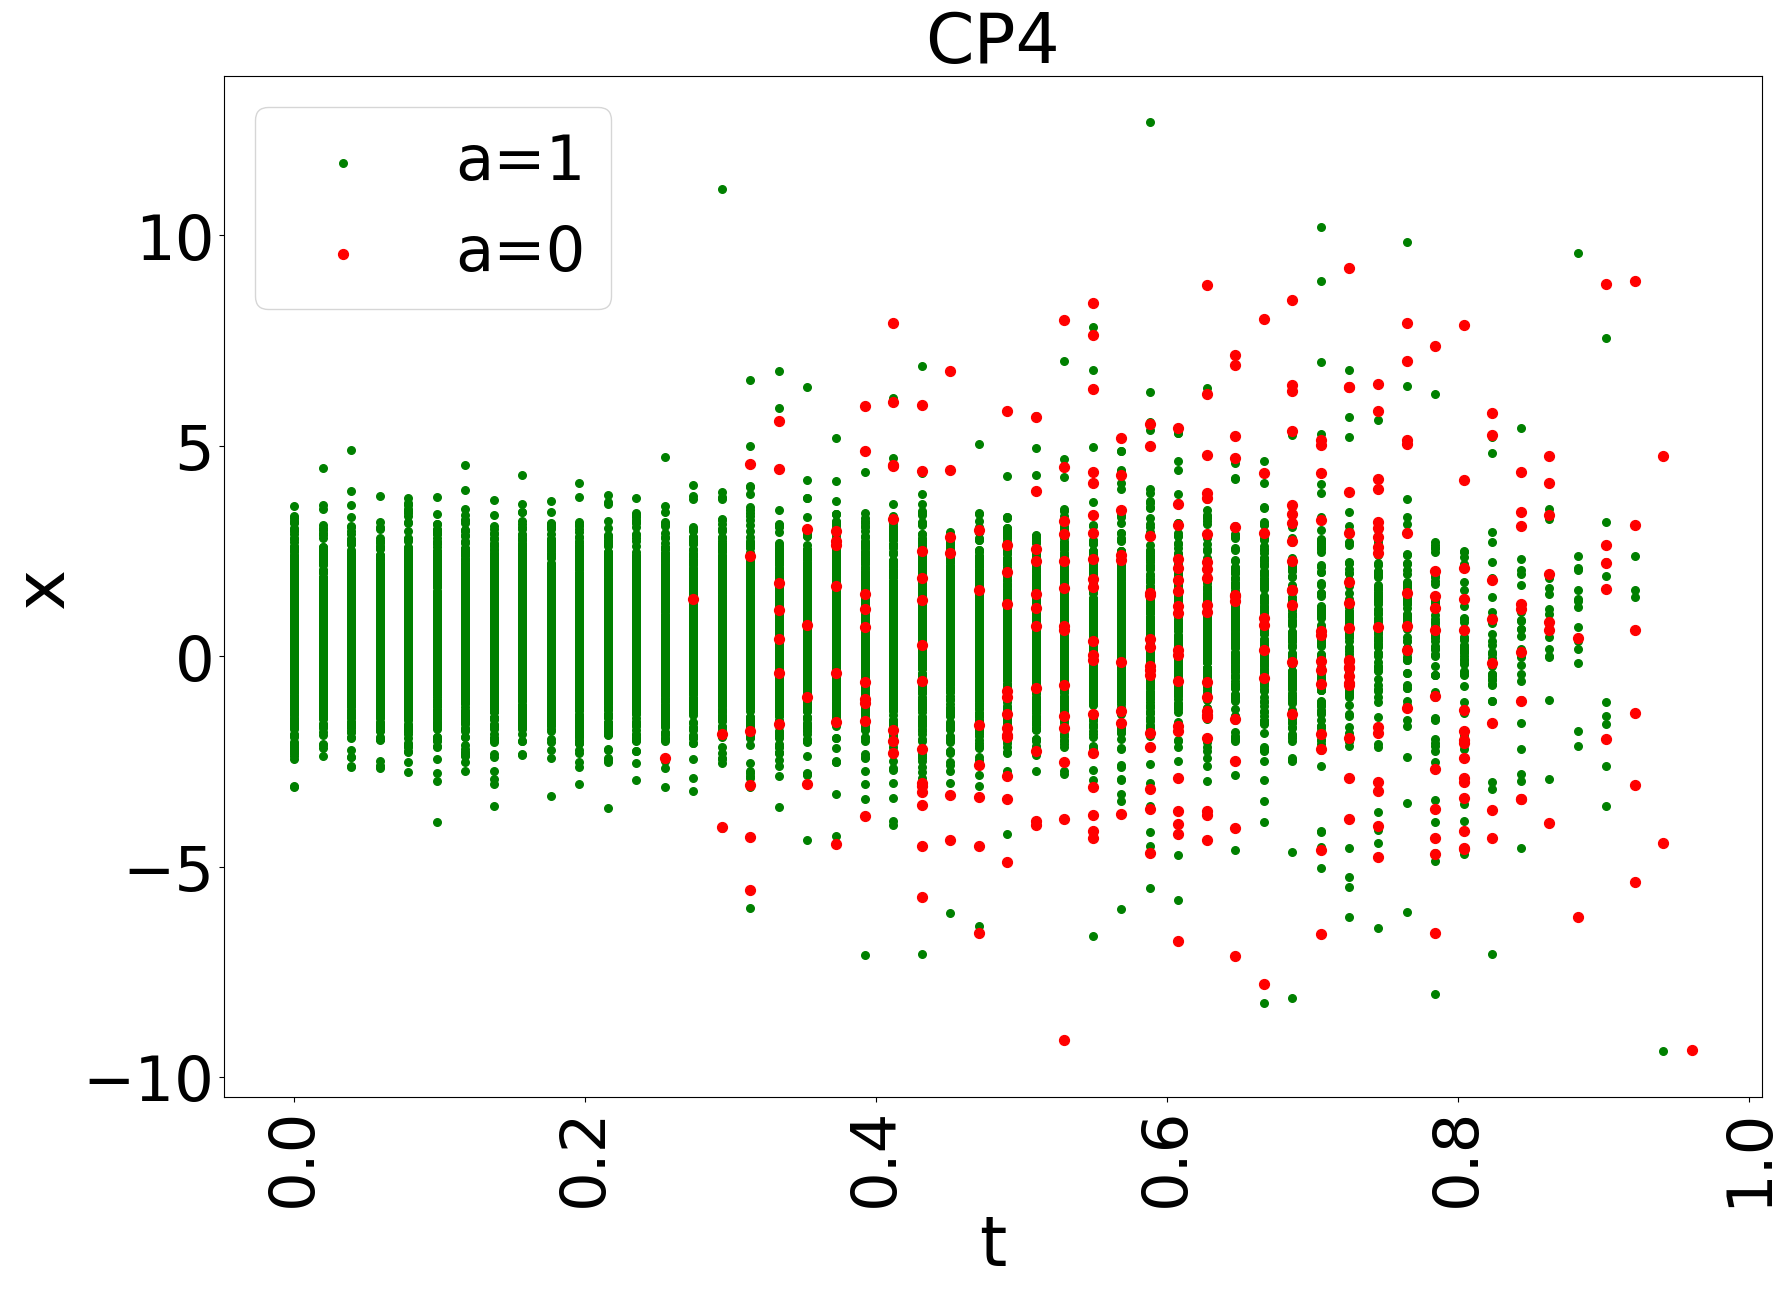

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  1%|▏         | 2/150 [00:15<18:47,  7.62s/it]

Saving best model checkpoint with balanced acc: 0.6211505401447461, avg Q-entropy: nan


  5%|▌         | 8/150 [01:05<19:19,  8.17s/it]


KeyboardInterrupt: 

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


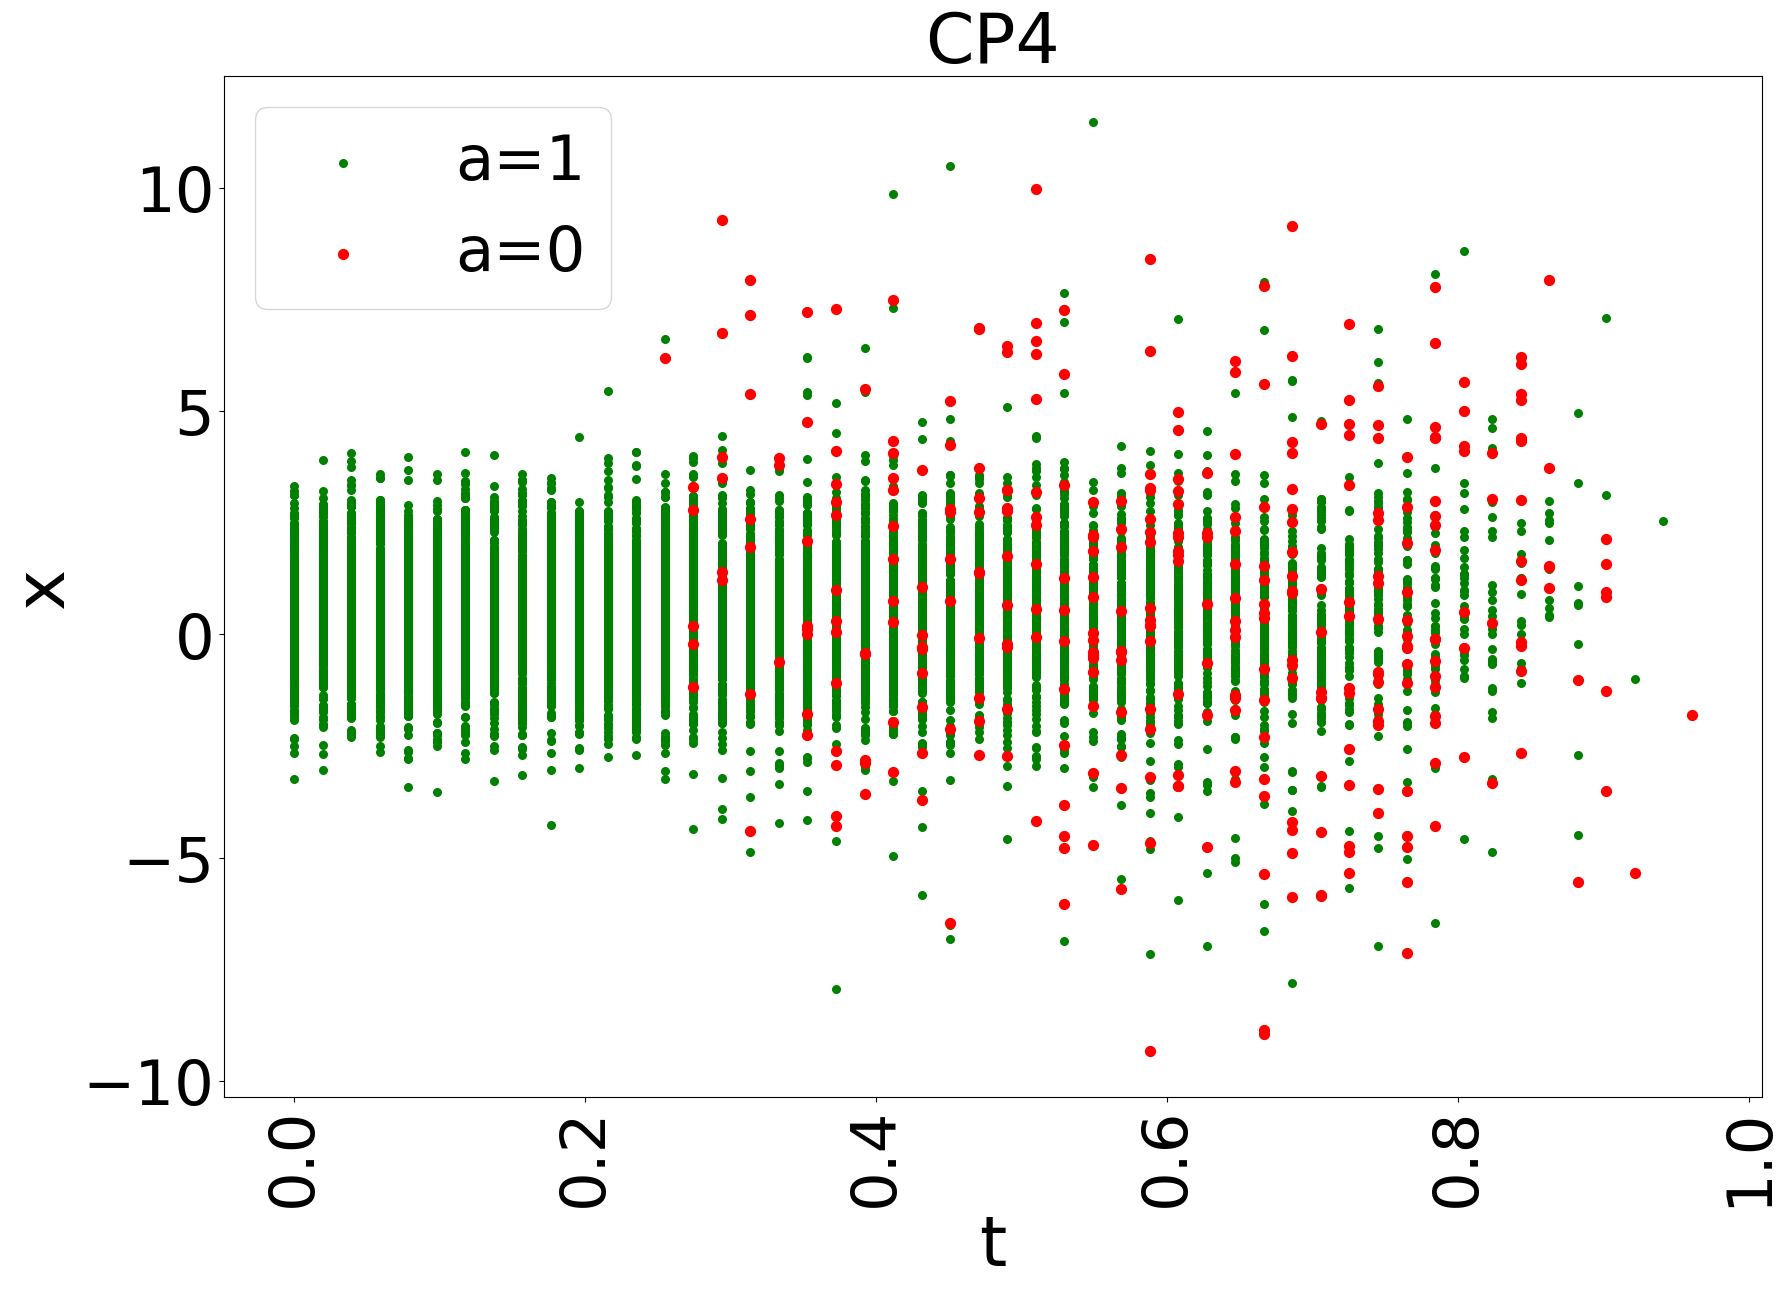

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:07<?, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


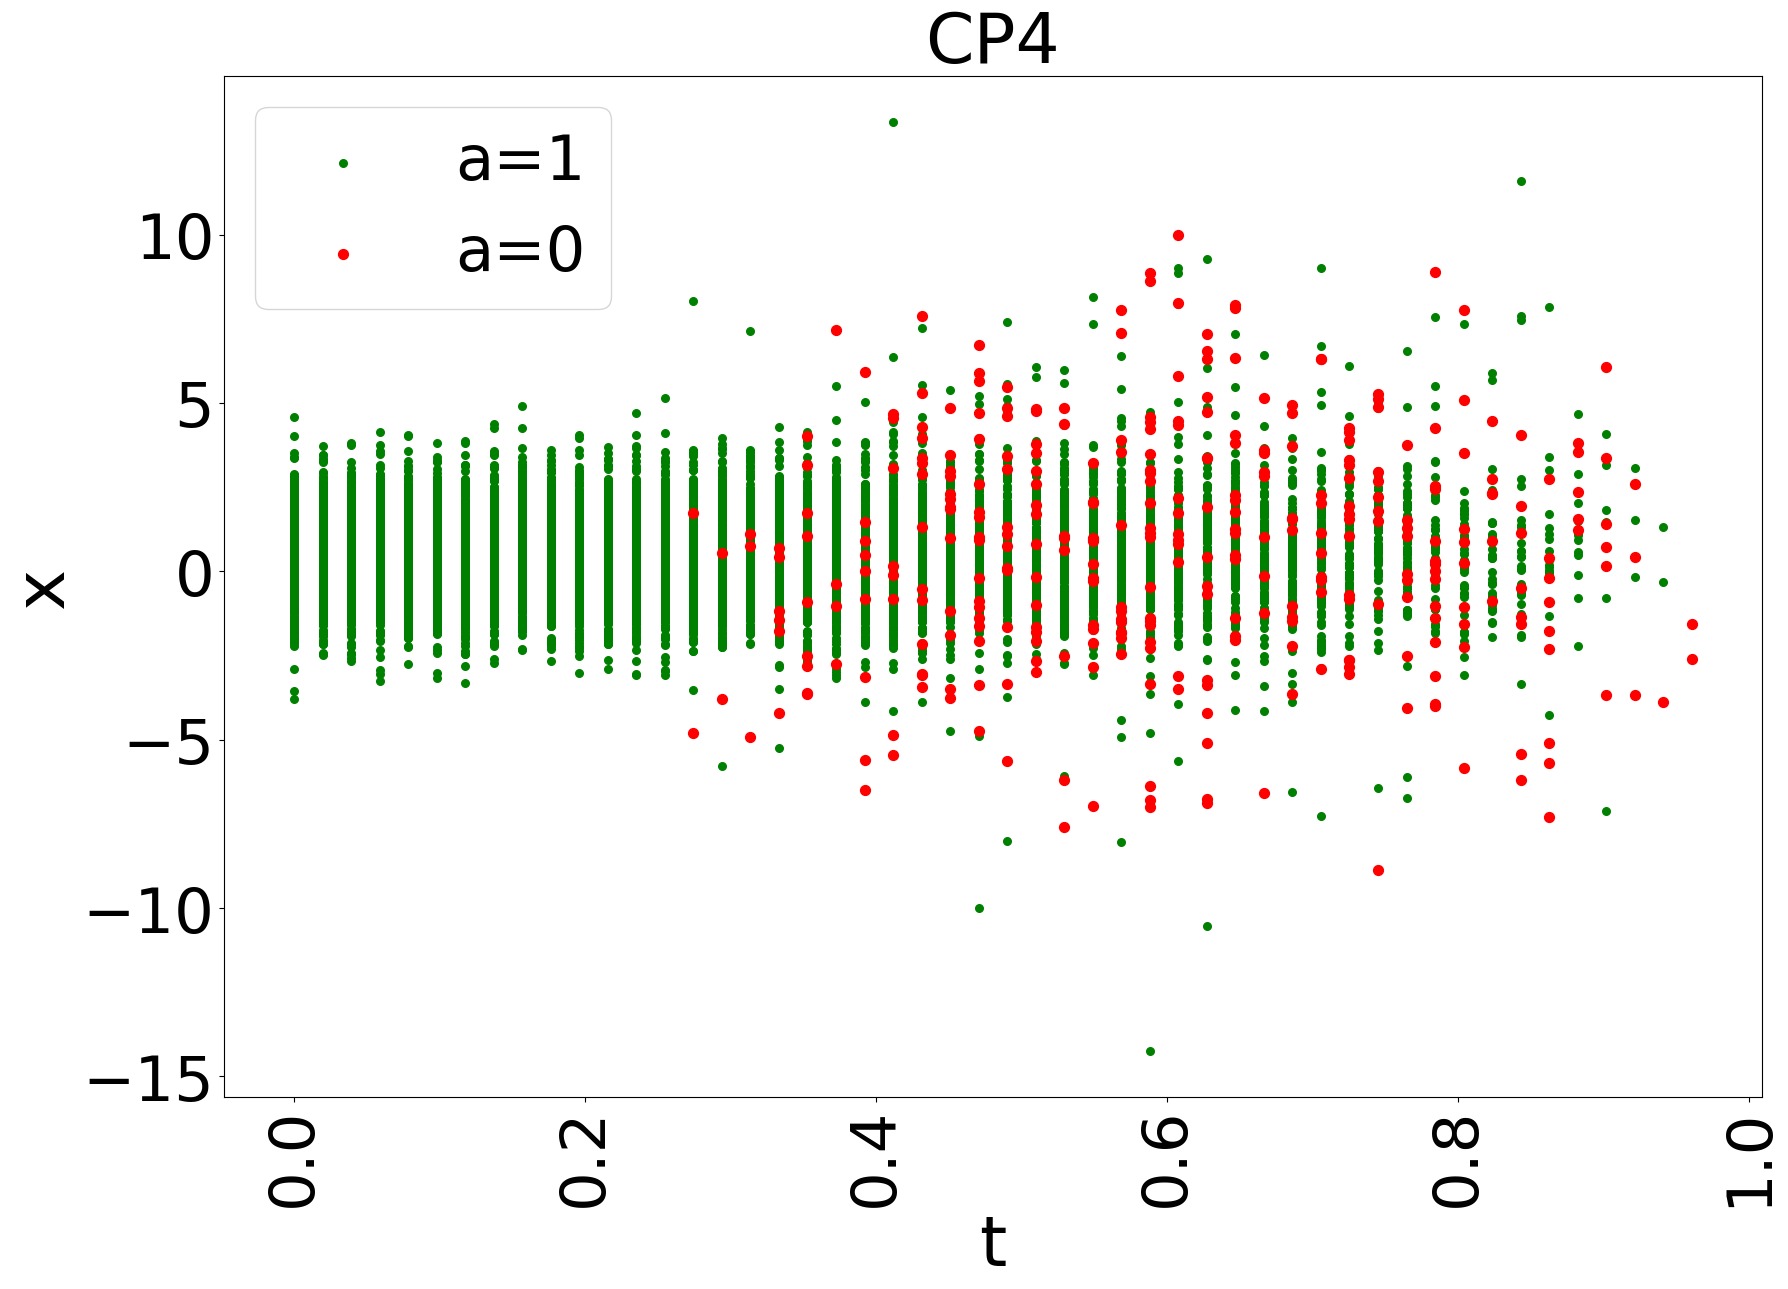

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:07<?, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


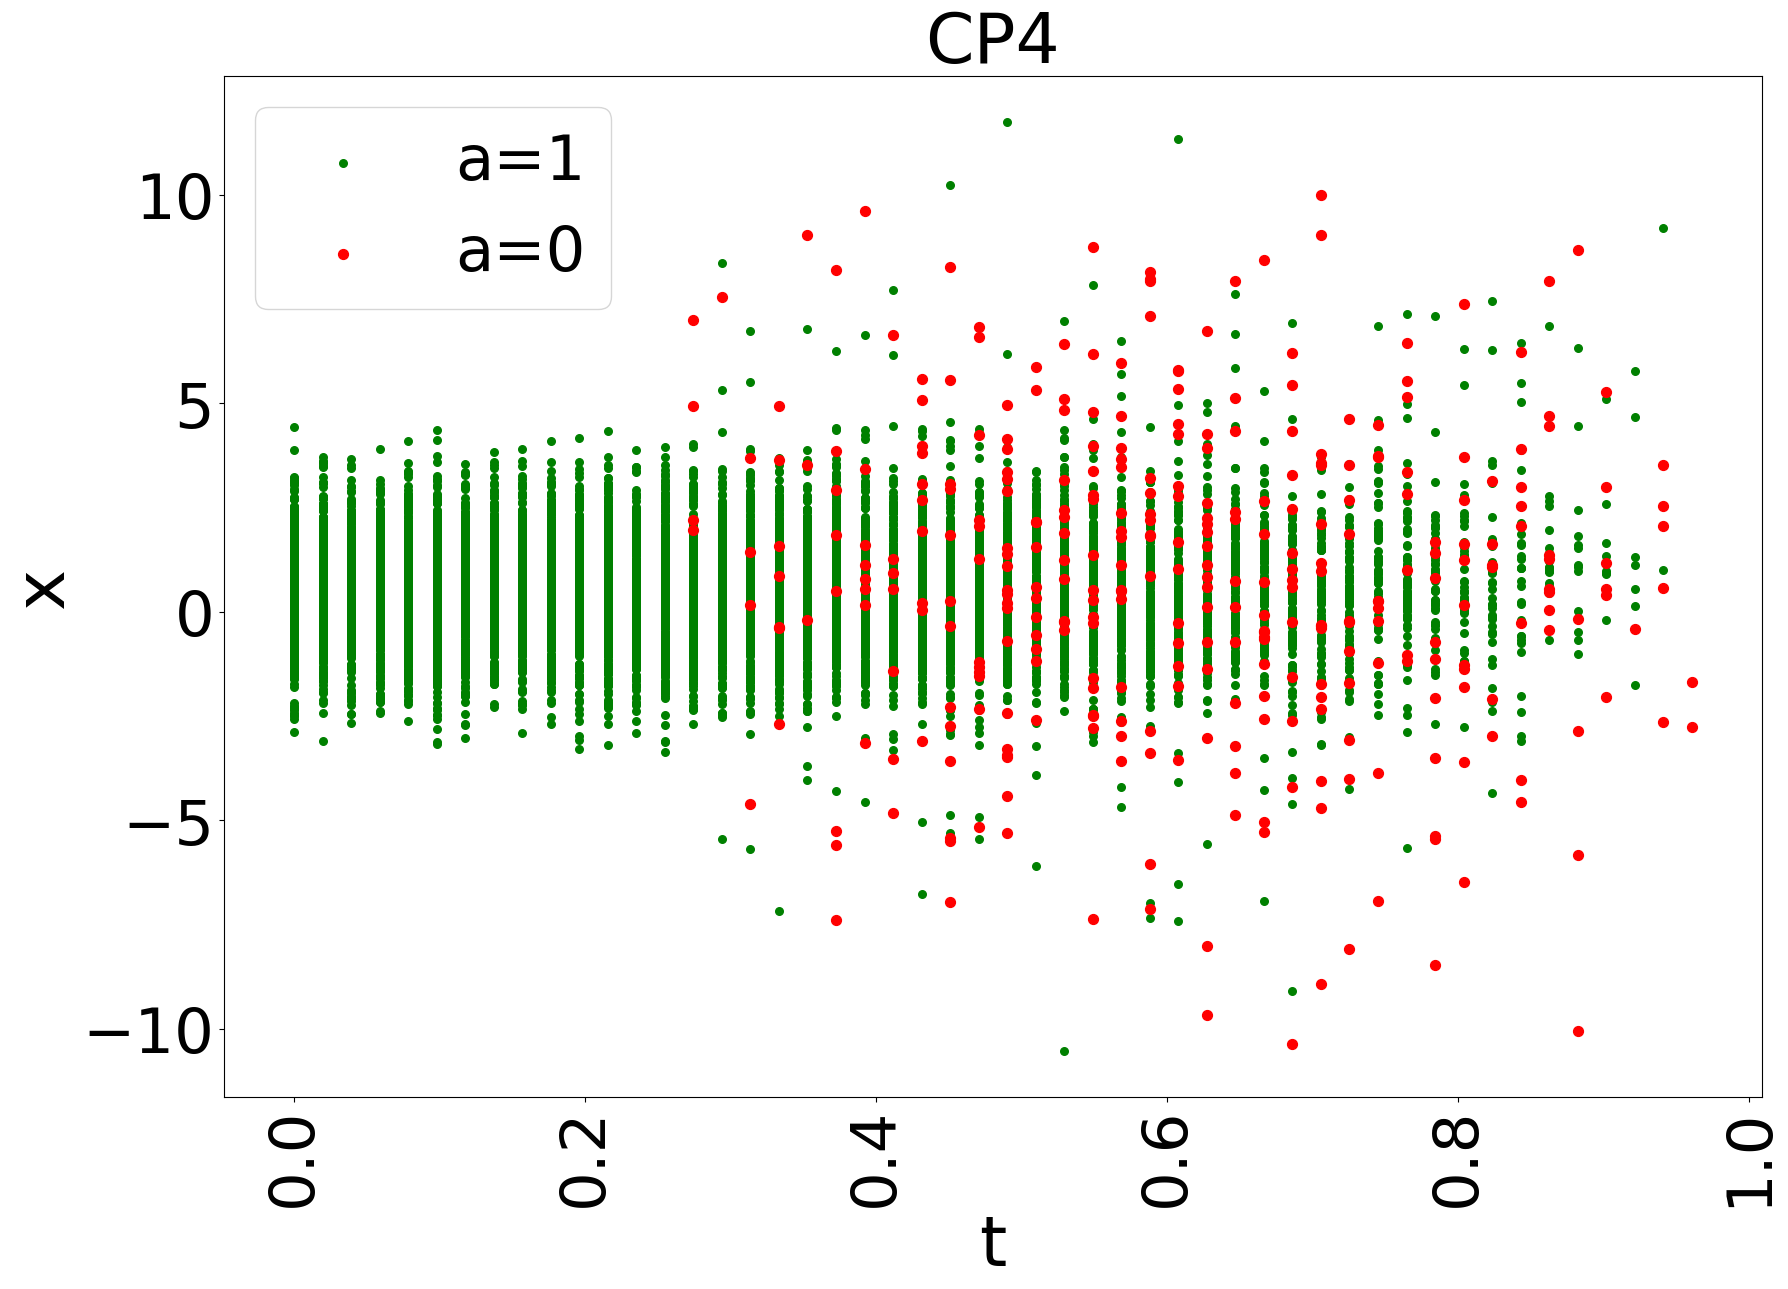

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  0%|          | 0/150 [00:00<?, ?it/s]

irl_y.shape: torch.Size([1785])


  1%|          | 1/150 [00:08<20:06,  8.10s/it]

irl_y.shape: torch.Size([1785])


  1%|▏         | 2/150 [00:15<18:33,  7.52s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


  2%|▏         | 3/150 [00:23<19:05,  7.79s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


  3%|▎         | 4/150 [00:30<18:49,  7.73s/it]

irl_y.shape: torch.Size([1785])


  4%|▍         | 6/150 [00:46<18:43,  7.80s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


  5%|▍         | 7/150 [00:54<18:31,  7.77s/it]

irl_y.shape: torch.Size([1785])


  5%|▌         | 8/150 [01:01<17:50,  7.54s/it]

irl_y.shape: torch.Size([1785])


  6%|▌         | 9/150 [01:09<18:10,  7.73s/it]

irl_y.shape: torch.Size([1785])


  7%|▋         | 11/150 [01:23<16:47,  7.25s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


  8%|▊         | 12/150 [01:33<18:49,  8.19s/it]

irl_y.shape: torch.Size([1785])


  9%|▊         | 13/150 [01:42<18:40,  8.18s/it]

irl_y.shape: torch.Size([1785])


  9%|▉         | 14/150 [01:50<18:31,  8.18s/it]

irl_y.shape: torch.Size([1785])


 10%|█         | 15/150 [01:57<17:45,  7.89s/it]

irl_y.shape: torch.Size([1785])


 11%|█▏        | 17/150 [02:12<17:01,  7.68s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 12%|█▏        | 18/150 [02:20<16:46,  7.63s/it]

irl_y.shape: torch.Size([1785])


 13%|█▎        | 19/150 [02:26<16:08,  7.39s/it]

irl_y.shape: torch.Size([1785])


 13%|█▎        | 20/150 [02:34<16:18,  7.52s/it]

irl_y.shape: torch.Size([1785])


 14%|█▍        | 21/150 [02:42<16:07,  7.50s/it]

irl_y.shape: torch.Size([1785])


 15%|█▌        | 23/150 [02:57<15:55,  7.53s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 16%|█▌        | 24/150 [03:05<15:58,  7.61s/it]

irl_y.shape: torch.Size([1785])


 17%|█▋        | 25/150 [03:13<15:55,  7.64s/it]

irl_y.shape: torch.Size([1785])


 17%|█▋        | 26/150 [03:20<15:54,  7.70s/it]

irl_y.shape: torch.Size([1785])


 19%|█▊        | 28/150 [03:35<15:10,  7.46s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 19%|█▉        | 29/150 [03:42<14:37,  7.26s/it]

irl_y.shape: torch.Size([1785])


 21%|██        | 31/150 [03:57<14:44,  7.44s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 21%|██▏       | 32/150 [04:04<14:27,  7.35s/it]

irl_y.shape: torch.Size([1785])


 22%|██▏       | 33/150 [04:13<14:58,  7.68s/it]

irl_y.shape: torch.Size([1785])


 23%|██▎       | 34/150 [04:19<14:14,  7.37s/it]

irl_y.shape: torch.Size([1785])


 23%|██▎       | 35/150 [04:28<14:41,  7.66s/it]

irl_y.shape: torch.Size([1785])


 25%|██▍       | 37/150 [04:43<14:30,  7.71s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 25%|██▌       | 38/150 [04:49<13:38,  7.31s/it]

irl_y.shape: torch.Size([1785])


 26%|██▌       | 39/150 [04:58<14:03,  7.60s/it]

irl_y.shape: torch.Size([1785])


 27%|██▋       | 41/150 [05:13<13:51,  7.62s/it]

irl_y.shape: torch.Size([1785])


 28%|██▊       | 42/150 [05:19<13:05,  7.28s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 29%|██▊       | 43/150 [05:28<13:41,  7.68s/it]

irl_y.shape: torch.Size([1785])


 30%|███       | 45/150 [05:42<12:44,  7.28s/it]

irl_y.shape: torch.Size([1785])


 31%|███       | 46/150 [05:48<12:06,  6.98s/it]

irl_y.shape: torch.Size([1785])
irl_y.shape: torch.Size([1785])


 31%|███▏      | 47/150 [05:55<12:16,  7.15s/it]

irl_y.shape: torch.Size([1785])


 32%|███▏      | 48/150 [06:03<12:10,  7.16s/it]

irl_y.shape: torch.Size([1785])


 33%|███▎      | 49/150 [06:10<12:07,  7.20s/it]

irl_y.shape: torch.Size([1785])


 33%|███▎      | 50/150 [06:19<12:57,  7.78s/it]

irl_y.shape: torch.Size([1785])


 34%|███▍      | 51/150 [06:27<13:06,  7.95s/it]

irl_y.shape: torch.Size([1785])


 35%|███▍      | 52/150 [06:41<12:36,  7.72s/it]


KeyboardInterrupt: 

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

Restarted pyenv (Python 3.12.3)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


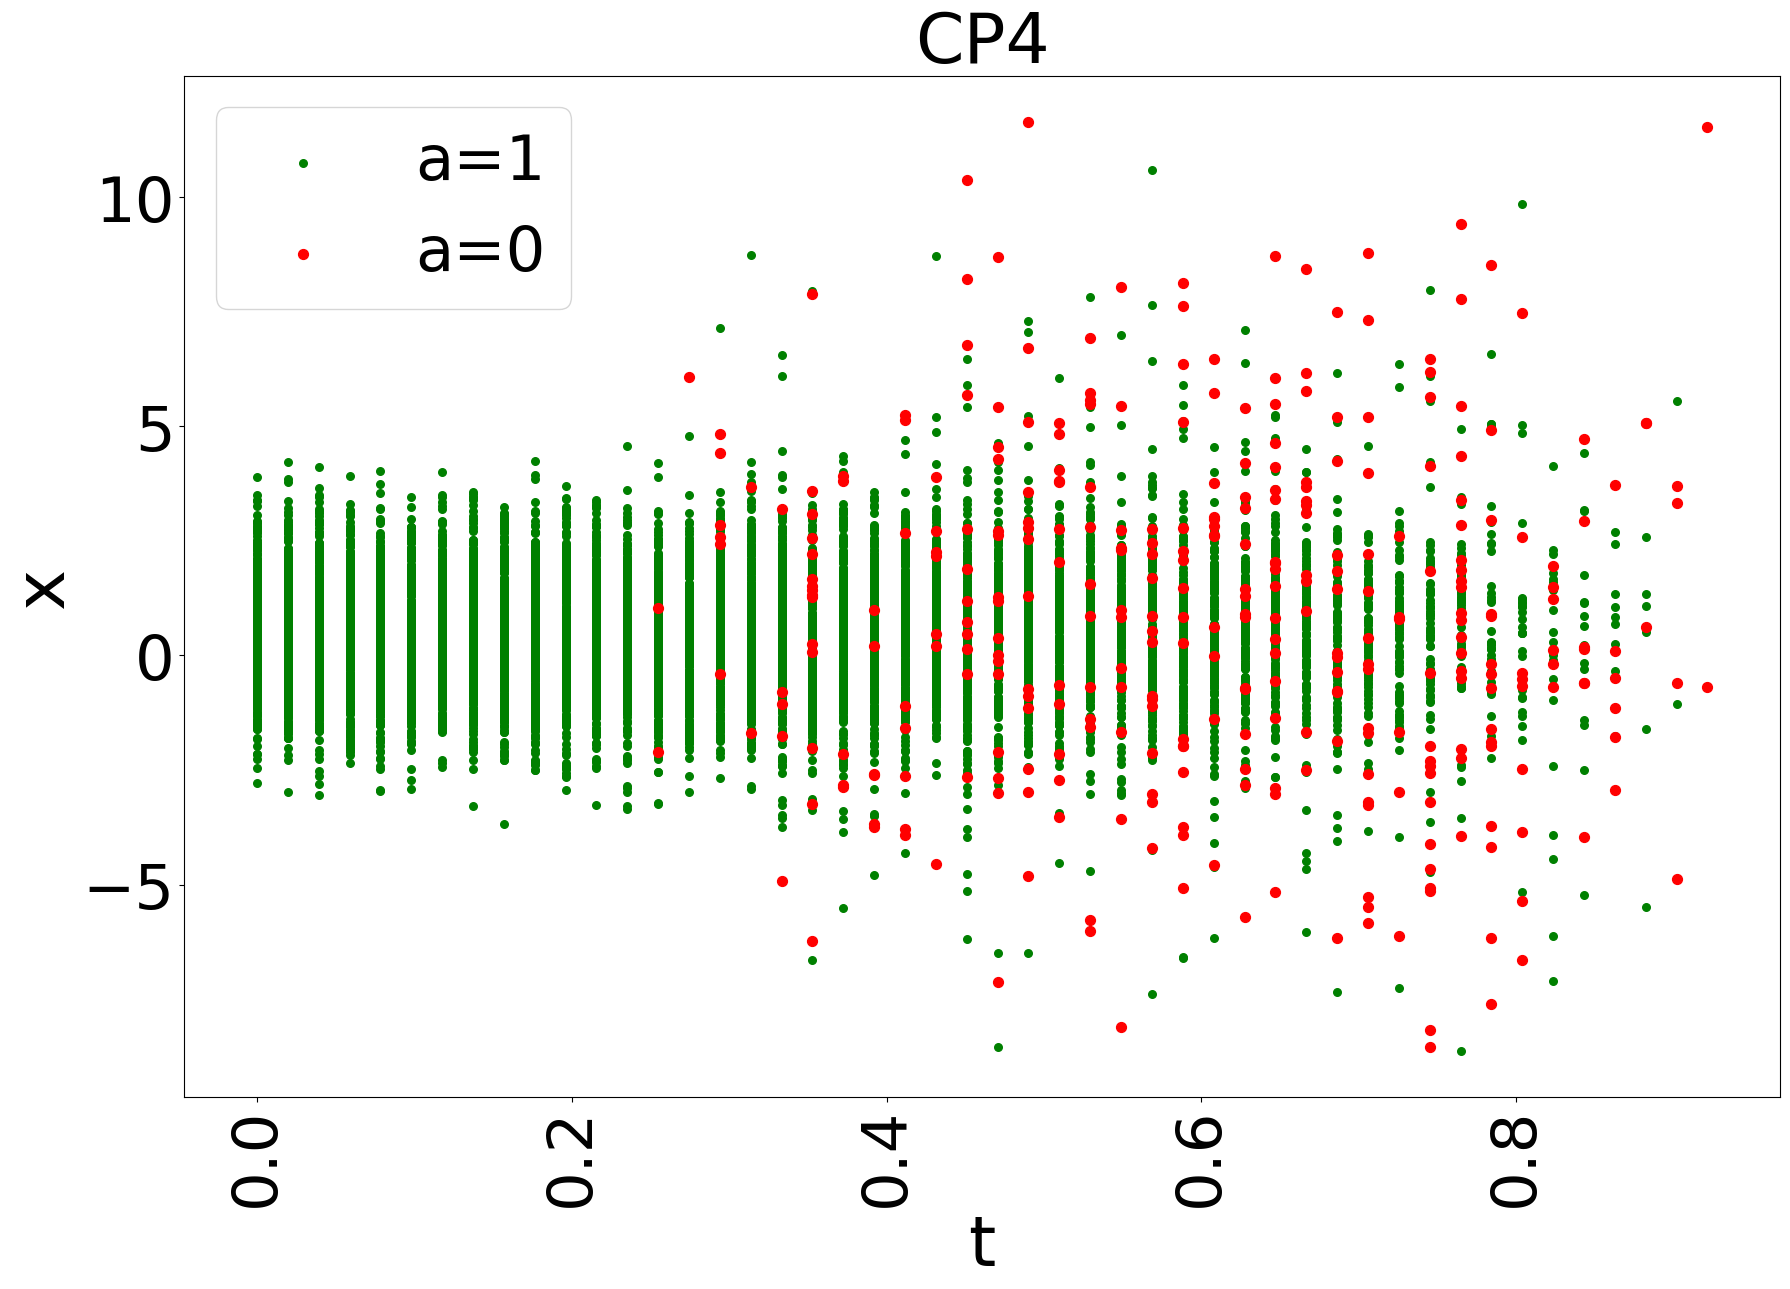

RANDOM SEED: 0
Start training
IQ-Learn
g_net ON CUDA: False
q_net ON CUDA: False


  1%|▏         | 2/150 [00:14<18:26,  7.47s/it]

Saving best model checkpoint with balanced acc: 0.5, avg Q-entropy: nan


 26%|██▌       | 39/150 [04:51<13:50,  7.48s/it]


KeyboardInterrupt: 

In [ ]:
from inverse_opt_stopping.data_preprocessing import shift_array, to_bool, preprocess_data, plot_inputs 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forward_algorithms.simulate_expert_data import Simulation
from inverse_opt_stopping.iq_learn_base import IQ_Agent, plot_st_reg_car
import os 
import shutil
sns.set_style("whitegrid")
DRIVER_ROC_AUC = []
DRIVER_F1 = []
DRIVER_ACCURACY = []
DRIVER_PRECISION = []
DRIVER_RECALL = []

BM_ROC_AUC = []
BM_F1 = []
BM_ACCURACY = []
BM_PRECISION = []
BM_RECALL = []
BM_PR_AUC = []

BM_MTTE = []
BM_MEMR = []
BM_BALANCED_ACC = []
import shutil
shutil.rmtree('./out', ignore_errors=True)

N_EPOCHS = 150
CROSS_VAL_SPLITS = 2
SEEDS = np.arange(5)
T_DOWNSAMPLE = 1
BATCH_SIZE = 128
Q_LR = 0.01
ENV_LR = 0.01
G_LR = 0.01
EPS = 0.1
dqs_only = []
for s in SEEDS:
    
    # Symmetrical BM results
    bm_sym = Simulation(problem='CP1', total_n=250)
    # bm_sym = Simulation(problem='symm_bm', total_n=500)
    # bm_sym = Simulation(problem='symm_bm_gG')
    # bm_sym = Simulation(problem='car')
    # bm_sym = Simulation(problem='oti')
    # bm_sym = Simulation(problem='bessel2')
    bm_expert_data = bm_sym.simulate_expert(episodes=100, max_path_length=150)
    bm_test_data = bm_sym.simulate_test(episodes=30, max_path_length=150)
    print(f'RANDOM SEED: {s}')
    # print(f"{bm_test_data['state_mem'].shape}")
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter([bm_expert_data['state_mem'][i][0] for i in range(len(bm_expert_data['state_mem']))], 
    #             [bm_expert_data['state_mem'][i][1] for i in range(len(bm_expert_data['state_mem']))], s=0.3)
    # plt.show()
    # st_dat = bm_expert_data['state_mem'][bm_expert_data['action_mem']==0]
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    # t1 = st_dat[:,2]==1/50
    # t2 = st_dat[:,2]==2/50
    # t3 = st_dat[:,2]==5/50
    # t4 = st_dat[:,2]==10/50
    # t5 = st_dat[:,2]==15/50
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.scatter(st_dat[t1][:,0], st_dat[t1][:,1],c='blue',s=1)
    # plt.scatter(st_dat[t2][:,0], st_dat[t2][:,1],c='green',s=1)
    # plt.scatter(st_dat[t3][:,0], st_dat[t3][:,1],c='orange',s=1)
    # plt.scatter(st_dat[t4][:,0], st_dat[t4][:,1],c='red',s=1)
    # plt.scatter(st_dat[t5][:,0], st_dat[t5][:,1],c='black',s=1)
    # plt.show()
    # plt.figure(figsize=(10,10),facecolor="w")
    # plt.rcParams['axes.facecolor'] = 'white'
    # st_dat = bm_test_data['state_mem'][bm_test_data['action_mem']==0]
    # plt.scatter(st_dat[:,0],st_dat[:,1],s=0.3)
    # plt.show()
    print(f'Start training')
    
    # IQ-Learn
    print('IQ-Learn')
    iq = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq.test(test_memory=bm_test_data, from_grid=False)
    # iq.test(test_memory=bm_test_data, from_grid=True)
    
    
    
    # import os
    # os.mkdir('./out') 
    # try: 
    #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling SMOTE
    print('IQ-Learning + oversampling SMOTE')
    iq_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_smote.test(test_memory=bm_test_data, from_grid=True)
    
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # shutil.rmtree('./out', ignore_errors=True)
    
    # IQ-Learning + oversampling CS-SMOTE
    print('IQ-Learning + oversampling CS-SMOTE')
    iq_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_cs_smote.test(test_memory=bm_test_data, from_grid=True)
   
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # Approximating P, no oversampling
    print('Approximating P, no oversampling')
    iq_p = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling=None, 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False,
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=5)
    iq_p.test(test_memory=bm_test_data, from_grid=False)
    # iq_p.test(test_memory=bm_test_data, from_grid=True)
   
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # except:
    #     print(f'Could not plot empty stopping region for iq_p')
    # shutil.rmtree('./out', ignore_errors=True)         
        
    # Approximating P + oversampling SMOTE
    print('Approximating P + oversampling SMOTE')
    iq_p_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_smote.test(test_memory=bm_test_data, from_grid=True)
    
    # os.mkdir('./out')
    # try:
    #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_smote')
    # shutil.rmtree('./out', ignore_errors=True)  
    
    # Approximating P + oversampling CS-SMOTE
    print('Approximating P + oversampling CS-SMOTE')
    iq_p_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
                        q_lr=Q_LR, env_lr=ENV_LR, g_lr=0,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False,
                        q_entropy=False, 
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_p_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=False)
    # iq_p_cs_smote.test(test_memory=bm_test_data, from_grid=True)

    # try:
    #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # except:
    #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # shutil.rmtree('./out', ignore_errors=True)     
    
    # Approximating g and P, no oversampling
    print('Approximating g and P, no oversampling')
    iq_diqs = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
                        approx_g=True, approx_dynamics=True, oversampling=None, 
                        q_lr=0.01, env_lr=0.01, g_lr=0.01,
                        epsilon=EPS,seed=s,
                        divergence='hellinger', cross_val_splits=2,
                        conservative=False, 
                        q_entropy=False
                        # discretiser=discretizer, 
                        # out_thresh=out_thresh
                        )
    iq_diqs.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    iq_diqs.test(test_memory=bm_test_data)

    
    
    # Approximating g and P, CS-LSMOTE oversampling
    # print('Approximating g and P, CS-LSMOTE oversampling')
    # iq_diqs_cs_smote = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling='CS-LSMOTE', 
    #                     q_lr=0.01, env_lr=0.01, g_lr=0.01,
    #                     epsilon=EPS,seed=s,
    #                     divergence='hellinger', cross_val_splits=2,
    #                     conservative=False, 
    #                     # discretiser=discretizer, 
    #                     # out_thresh=out_thresh
    #                     )
    # iq_diqs_cs_smote.train(mem=bm_expert_data, batch_size=BATCH_SIZE, n_epoches=N_EPOCHS)
    # iq_diqs_cs_smote.test(test_memory=bm_test_data)
    
    # dqs_only.append([iq_diqs.f1, iq_diqs.pr_auc, iq_diqs.mtte])
    
    # # CONSERVATIVE
    # # IQ-Learn
    # from binning import MDLP_Discretizer
    # discretizer = MDLP_Discretizer(features=np.arange(bm_expert_data['state_mem'].shape[1]))
    # discretizer.fit(bm_expert_data['state_mem'], bm_expert_data['action_mem'])

    # print('IQ-Learn')
    # iq_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_conserv.test(test_memory=bm_test_data)
    # # import os
    # # os.mkdir('./out') 
    # # try: 
    # #     plot_st_reg_bm(iq_iql, bm_test_data, name='IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql')
   
    
    # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling SMOTE
    # print('IQ-Learning + oversampling SMOTE')
    # iq_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_smote_conserv.test(test_memory=bm_test_data)
    
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_smote, bm_test_data, name='IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_smote')
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # IQ-Learning + oversampling CS-SMOTE
    # print('IQ-Learning + oversampling CS-SMOTE')
    # iq_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=False, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_iql_cs_smote, bm_test_data, name='IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_iql_cs_smote')    
    # # shutil.rmtree('./out', ignore_errors=True)
    
    # # Approximating P, no oversampling
    # print('Approximating P, no oversampling')
    # iq_p_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_p, bm_test_data, name='Model-based IQS')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_p')
    # # shutil.rmtree('./out', ignore_errors=True)         
        
    # # Approximating P + oversampling SMOTE
    # print('Approximating P + oversampling SMOTE')
    # iq_p_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_smote, bm_test_data, name='Model-based IQS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_smote')
    # # shutil.rmtree('./out', ignore_errors=True)  
    
    # # Approximating P + oversampling CS-SMOTE
    # print('Approximating P + oversampling CS-SMOTE')
    # iq_p_cs_smote_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=False, approx_dynamics=True, oversampling='CS-SMOTE', 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_p_cs_smote_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_p_cs_smote_conserv.test(test_memory=bm_test_data)
    # # os.mkdir('./out')
    # # try:
    # #     plot_st_reg_bm(iq_cs_smote, bm_test_data, name='Model-based IQS-CS-SMOTE')
    # # except:
    # #     print(f'Could not plot empty stopping region for iq_cs_smote')
    # # shutil.rmtree('./out', ignore_errors=True)     
    
    # # Approximating g and P, no oversampling
    # print('Approximating g and P, no oversampling')
    # iq_diqs_conserv = IQ_Agent(obs_dim=bm_expert_data['state_mem'][0].shape[0], 
    #                     approx_g=True, approx_dynamics=True, oversampling=None, 
    #                     q_lr=0.02, env_lr=0.02, g_lr=0.005,
    #                     epsilon=0.1,seed=s,
    #                     divergence='js', cross_val_splits=2,
    #                     conservative=True, 
    #                     discretiser=discretizer, 
    #                     out_thresh=0.0001
    #                     )
    # iq_diqs_conserv.train(mem=bm_expert_data, batch_size=75, n_epoches=N_EPOCHS)
    # iq_diqs_conserv.test(test_memory=bm_test_data)
    
    BM_F1.append([iq.f1, 
                  iq_smote.f1, 
                  iq_cs_smote.f1, 
                  iq_p.f1,
                  iq_p_smote.f1, 
                  iq_p_cs_smote.f1,
                  iq_diqs.f1,
                  iq_diqs_cs_smote.f1
                  # iq_conserv.f1, 
                  # iq_smote_conserv.f1, 
                  # iq_cs_smote_conserv.f1, 
                  # iq_p_conserv.f1,
                  # iq_p_smote_conserv.f1, 
                  # iq_p_cs_smote_conserv.f1,
                  # iq_diqs_conserv.f1
                 ])
    BM_PR_AUC.append([iq.pr_auc, 
                      iq_smote.pr_auc, 
                      iq_cs_smote.pr_auc, 
                      iq_p.pr_auc,
                      iq_p_smote.pr_auc, 
                      iq_p_cs_smote.pr_auc,
                      iq_diqs.pr_auc,
                      iq_diqs_cs_smote.pr_auc
                  # iq_conserv.pr_auc, 
                  # iq_smote_conserv.pr_auc, 
                  # iq_cs_smote_conserv.pr_auc, 
                  # iq_p_conserv.pr_auc,
                  # iq_p_smote_conserv.pr_auc, 
                  # iq_p_cs_smote_conserv.pr_auc,
                  # iq_diqs_conserv.pr_auc
                  ])    
    BM_MTTE.append([iq.mtte, 
                    iq_smote.mtte, 
                    iq_cs_smote.mtte, 
                    iq_p.mtte,
                    iq_p_smote.mtte, 
                    iq_p_cs_smote.mtte,
                    iq_diqs.mtte,
                    iq_diqs_cs_smote.mtte
                  # iq_conserv.mtte, 
                  # iq_smote_conserv.mtte, 
                  # iq_cs_smote_conserv.mtte, 
                  # iq_p_conserv.mtte,
                  # iq_p_smote_conserv.mtte, 
                  # iq_p_cs_smote_conserv.mtte,
                  # iq_diqs_conserv.mtte
                                    ])
    BM_MEMR.append([iq.memr, 
                    iq_smote.memr, 
                    iq_cs_smote.memr, 
                    iq_p.memr,
                    iq_p_smote.memr, 
                    iq_p_cs_smote.memr,
                    iq_diqs.memr,
                    iq_diqs_cs_smote.memr
                  # iq_conserv.memr, 
                  # iq_smote_conserv.memr, 
                  # iq_cs_smote_conserv.memr, 
                  # iq_p_conserv.memr,
                  # iq_p_smote_conserv.memr, 
                  # iq_p_cs_smote_conserv.memr,
                  # iq_diqs_conserv.memr
                    ])
    BM_BALANCED_ACC.append([
                  iq.balanced_accuracy, 
                  iq_smote.balanced_accuracy, 
                  iq_cs_smote.balanced_accuracy, 
                  iq_p.balanced_accuracy,
                  iq_p_smote.balanced_accuracy, 
                  iq_p_cs_smote.balanced_accuracy,
                  iq_diqs.balanced_accuracy,
                  iq_diqs_cs_smote.balanced_accuracy
                  # iq_conserv.balanced_accuracy, 
                  # iq_smote_conserv.balanced_accuracy, 
                  # iq_cs_smote_conserv.balanced_accuracy, 
                  # iq_p_conserv.balanced_accuracy,
                  # iq_p_smote_conserv.balanced_accuracy, 
                  # iq_p_cs_smote_conserv.balanced_accuracy,
                  # iq_diqs_conserv.balanced_accuracy
                    ])
    
    # BM_F1.append([iq_iql.f1, iq_diqs.f1])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_diqs.pr_auc])    
    # BM_MTTE.append([iq_iql.mtte, iq_diqs.mtte])
    # BM_MEMR.append([iq_iql.memr, iq_diqs.memr])

np.save(f'outputs/car_{T_DOWNSAMPLE}_f1.npy', np.array(BM_F1))
np.save(f'outputs/car_{T_DOWNSAMPLE}_pr_auc.npy', np.array(BM_PR_AUC))
np.save(f'outputs/car_{T_DOWNSAMPLE}_mtte.npy', np.array(BM_MTTE)*T_DOWNSAMPLE)
np.save(f'outputs/car_{T_DOWNSAMPLE}_memr.npy', np.array(BM_MEMR))
np.save(f'outputs/car_{T_DOWNSAMPLE}_balanced_acc.npy', np.array(BM_BALANCED_ACC))
    # BM_EMR
    # BM_ROC_AUC.append([iq_iql.roc_auc, iq_p.roc_auc, iq_diqs.roc_auc])
    # BM_F1.append([iq_iql.f1, iq_p.f1, iq_diqs.f1])
    # BM_ACCURACY.append([iq_iql.accuracy, iq_p.accuracy, iq_diqs.accuracy])
    # BM_PRECISION.append([iq_iql.precision, iq_p.precision, iq_diqs.precision])
    # BM_RECALL.append([iq_iql.recall, iq_p.recall, iq_diqs.recall])
    # BM_PR_AUC.append([iq_iql.pr_auc, iq_p.pr_auc, iq_diqs.pr_auc])

In [ ]:
!pip install torch-discounted-cumsum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.4/185.4 kB 3.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... 

Connected to pyenv (Python 3.12.3)

In [ ]:
import torch

In [ ]:
tt = torch.tensor([1,2,3,4,5])

In [ ]:
from torch_discounted_cumsum import discounted_cumsum_right

ModuleNotFoundError: No module named 'torch_discounted_cumsum'

In [ ]:
discounted_cumsum_right(tt,1)

NameError: name 'discounted_cumsum_right' is not defined

In [ ]:
import torch

In [ ]:
tt = torch.tensor([1,2,3,4,5])
from torch_discounted_cumsum import discounted_cumsum_right

ModuleNotFoundError: No module named 'torch_discounted_cumsum'